# Necessary libraries

In [1]:
#!pip install pystan==2.19.1.1 convertdate==2.4.0 lunarcalendar==0.0.9 holidays==0.13 fbprophet

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import lagrange
from scipy.interpolate import CubicSpline, InterpolatedUnivariateSpline, Akima1DInterpolator
from datetime import datetime, timedelta
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
#from datetime import timedelta
#import datetime
#import fbprophet
#from matplotlib import pyplot
from pandas import to_datetime
from statsmodels.tsa.arima_model import ARIMA
#from fbprophet import Prophet
#from pmdarima.arima import auto_arima
#import pmdarima
from scipy import interpolate
#from fbprophet import Prophet
from matplotlib import pyplot
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
import plotly.graph_objs as go
import sklearn.model_selection
from scipy import stats
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow import keras
from imblearn.over_sampling import SMOTE
from scipy.interpolate import CubicSpline as CS
from statistics import mean
import math
from fbprophet import Prophet
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import tensorflow as tf
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

2023-10-25 17:43:38.317563: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-25 17:43:38.338412: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-25 17:43:38.338868: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-25 17:43:38.787289: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
#!pip install pystan==2.19.1.1 lunarcalendar==0.0.9 holidays==0.13 fbprophet

In [4]:
df_for=pd.read_csv("6_df_interpolated_for_forecasting_aug10.csv")
df_for=df_for.drop(["Unnamed: 0"],axis=1)
df_for

Date    Area Gender   Race    Ethinicity  Wound
0        2016-10-26  4.0000      M  White  Non-Hispanic      1
1        2016-10-27  4.0000      M  White  Non-Hispanic      1
2        2016-10-28  4.0000      M  White  Non-Hispanic      1
3        2016-10-29  4.0000      M  White  Non-Hispanic      1
4        2016-10-30  4.0000      M  White  Non-Hispanic      1
...             ...     ...    ...    ...           ...    ...
1290115  2023-01-05  2.7064      F  White  Non-Hispanic  17884
1290116  2023-01-06  2.7064      F  White  Non-Hispanic  17884
1290117  2023-01-07  2.7064      F  White  Non-Hispanic  17884
1290118  2023-01-08  2.7064      F  White  Non-Hispanic  17884
1290119  2023-01-09  2.7064      F  White  Non-Hispanic  17884

[1290120 rows x 6 columns]

In [5]:
def make_input_for_arima(df):    
    #display(df)
    df=df.reset_index()
    total_n=df.shape[0]
    n=math.ceil(0.15*total_n)
    dff=pd.concat([df, df.tail(n), df.tail(n)]).drop_duplicates(keep=False)
    #display(test)
    #display(dff)
    sample_row=dff.sample(1)
    a=int(sample_row.index.values)
    b=int(sample_row.index.values)+n
    print(a)
    print(b)
    test=df[a:b]
    train=pd.concat([df, test, test]).drop_duplicates(keep=False)
    # #display(train)
    return (test,train,a,b)

In [6]:
def model_holtwinters(df, test, train):
    #fit1 = sm.tsa.statespace.SARIMAX(train.Area, order=(2, 1, 4),seasonal_order=(0,1,1,7),initialization='approximate_diffuse').fit()
    fit1 = ExponentialSmoothing(np.asarray(train['Area']) ,seasonal_periods=2 ,trend='add', seasonal='add').fit()

    y_hat_avg = test.copy()
    y_hat_avg['Holtwinters'] = fit1.forecast(len(test))
    #print(y_hat_avg['ARIMA'])
    plt.figure(figsize=(16,8))
    #plt.plot( train['Area'], label='Train')
    #plt.plot(test['Area'], label='Test')
    plt.plot(df['Area'],label='Original')
    plt.plot(y_hat_avg['Holtwinters'], label='Forecasted by Holtwinters')
    plt.legend(loc='best')
    #plt.axhline(0)
    plt.grid()
    plt.xlabel('Days')
    plt.ylabel('Wound Area')
    plt.show()




    #Accuracy measure of the model (to be done next)
    forecast=y_hat_avg.Holtwinters
    actual=test.Area
    training_series=train.Area
    testing_series=test.Area
    prediction_series= y_hat_avg.Holtwinters



    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
     #as R-square value does not for forecasted value and actual value because forecasted values are 14 more than actual values, thus I am taking only the forecasted values minusing the last 14 values of the forecasted dataframe.
    # df = df.iloc[:-2]
    #forecast_without_last14=forecast.iloc[:-14]
    #actual_without_nan=actual.dropna()
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    #corr= np.corrcoef(forecast_without_last14,actual_without_nan)[0,1]
    r_square= corr**2
    return (rmse, r_square)

In [7]:
def model_arima(test, train, df):

    # Assuming you have your DataFrame 'df' containing 'ds', 'y', and other columns
    # Sort the DataFrame by date
    df['ds'] = pd.to_datetime(df['ds'])
    df = df.sort_values('ds')

    # Initialize the AutoARIMA model
    arima_model = StatsForecast(
        models=[AutoARIMA(season_length=7)],  # You can adjust the season_length as needed
        freq='d'
    )

    # Initialize an empty DataFrame to store predictions
    predictions = []

    # Iterate over specific past dates for which you want predictions
    #specific_dates = ['2019-03-11', '2019-03-12', '2019-03-13']  # Replace with your desired dates
    specific_dates=test['ds'].values
    for date in specific_dates:
        # Filter data up to the specific date
        train_data = df[df['ds'] <= date]
        #train_data=train

        # Fit the model using the filtered data
        arima_model.fit(train_data)

        # Predict using the model for the specific date
        forecast_df = arima_model.predict(1)  # Predict one step (one day)

        # Extract the predicted y value for the specific date
        predicted_y = forecast_df['AutoARIMA'].values[0]

        # Append the prediction to the predictions DataFrame
        predictions.append({'ds': date, 'predicted_y': predicted_y})

    # Print the predictions
    #print(predictions)

    y_hat_avg = test.copy()
    y_hat_avg['ARIMA']=pd.DataFrame(predictions)['predicted_y'].values

#     print(y_hat_avg['ARIMA'])
    plt.figure(figsize=(16,8))
    #plt.plot( train['y'], label='Train')
    #plt.plot(test['y'], label='Test')
    plt.plot(df['y'],label='Original')
    plt.plot(y_hat_avg['ARIMA'], label='Forecasted by AutoARIMA')
    plt.legend(loc='best')
    #plt.axhline(0)
    plt.grid()
    plt.xlabel('Days')
    plt.ylabel('Wound Area')
    plt.show()




    #Accuracy measure of the model (to be done next)
    forecast=y_hat_avg.ARIMA
    actual=test.y
    training_series=train.y
    testing_series=test.y
    prediction_series= y_hat_avg.ARIMA



    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
     #as R-square value does not for forecasted value and actual value because forecasted values are 14 more than actual values, thus I am taking only the forecasted values minusing the last 14 values of the forecasted dataframe.
    # df = df.iloc[:-2]
    forecast_without_last14=forecast.iloc[:-14]
    actual_without_nan=actual.dropna()
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    #corr= np.corrcoef(forecast_without_last14,actual_without_nan)[0,1]
    r_square= corr**2
    return (rmse, r_square)

In [8]:
def model_arima(df, test, train):
    # Assuming you have your DataFrame 'df' containing 'ds', 'y', and other columns
    # Sort the DataFrame by date
    df['ds'] = pd.to_datetime(df['ds'])
    df = df.sort_values('ds')

    # Initialize the AutoARIMA model
    arima_model = StatsForecast(
        models=[AutoARIMA(season_length=7)],  # You can adjust the season_length as needed
        freq='d'
    )

    # Initialize an empty DataFrame to store predictions
    predictions = []

    # Iterate over specific past dates for which you want predictions
    #specific_dates = ['2019-03-11', '2019-03-12', '2019-03-13']  # Replace with your desired dates
    specific_dates=test['ds'].values
    for date in specific_dates:
        # Filter data up to the specific date
        train_data = df[df['ds'] <= date]
        #train_data=train

        # Fit the model using the filtered data
        arima_model.fit(train_data)

        # Predict using the model for the specific date
        forecast_df = arima_model.predict(1)  # Predict one step (one day)

        # Extract the predicted y value for the specific date
        predicted_y = forecast_df['AutoARIMA'].values[0]

        # Append the prediction to the predictions DataFrame
        predictions.append({'ds': date, 'predicted_y': predicted_y})

    # Print the predictions
    #print(predictions)

    y_hat_avg = test.copy()
    y_hat_avg['ARIMA']=pd.DataFrame(predictions)['predicted_y'].values

    #     print(y_hat_avg['ARIMA'])
    plt.figure(figsize=(16,8))
    #plt.plot( train['y'], label='Train')
    #plt.plot(test['y'], label='Test')
    plt.plot(df['y'],label='Original')
    plt.plot(y_hat_avg['ARIMA'], label='Forecasted by AutoARIMA')
    plt.legend(loc='best')
    #plt.axhline(0)
    plt.grid()
    plt.xlabel('Days')
    plt.ylabel('Wound Area')
    plt.show()




    #Accuracy measure of the model (to be done next)
    forecast=y_hat_avg.ARIMA
    actual=test.y
    training_series=train.y
    testing_series=test.y
    prediction_series= y_hat_avg.ARIMA



    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    # df = df.iloc[:-2]
    forecast_without_last14=forecast.iloc[:-14]
    actual_without_nan=actual.dropna()
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    r_square= corr**2
    return (rmse, r_square)

In [9]:
def model_prophet(df, test, train):
    # prepare expected column names
    dff=df
    dff.columns = ['ds', 'y']
    dff['ds']= to_datetime(dff['ds'])
    # define the model
    model = Prophet(daily_seasonality=True)
    #model=Prophet()
    # fit the model
    model.fit(dff)

    #print(test.Date.iloc[0])

    # define the period for which we want a prediction
    future = []
    for j in range(0, len(test)):
        date = test.ds.iloc[j]
        future.append([date])
    future = pd.DataFrame(future)
    future.columns = ['ds']
    future['ds']= to_datetime(future['ds'])
    # use the model to make a forecast
    forecast = model.predict(future)
    
    y_hat_avg = test.copy()
    y_hat_avg['Prophet']=pd.DataFrame(forecast)['yhat'].values
    
    plt.figure(figsize=(16,8))
    #plt.plot( train['y'], label='Train')
    #plt.plot(test['y'], label='Test')
    plt.plot(df['y'],label='Original')
    plt.plot(y_hat_avg['Prophet'], label='Forecasted by Prophet')
    plt.legend(loc='best')
    #plt.axhline(0)
    plt.grid()
    plt.xlabel('Days')
    plt.ylabel('Wound Area')
    
    pyplot.show()

    #Accuracy measure of Prophet
    forecastP=forecast.yhat
    actual=test.y
    training_series=train.y
    testing_series=test.y
    prediction_series= forecast.yhat

    forecastPP=forecastP.reset_index()
    actualPP=actual.reset_index()
    training_seriesPP=training_series.reset_index()
    testing_seriesPP=testing_series.reset_index()
    prediction_seriesPP=prediction_series.reset_index()
    rmse = np.mean((forecastPP.yhat - actualPP.y)**2)**.5  # RMSE
    corr= np.corrcoef(forecastPP.yhat,actualPP.y)[0,1]     #corr
    r_square= corr**2  
    
    return (rmse, r_square)

In [10]:
def model_LSTM(df,random_number_start,random_number_end):
    # Load and preprocess your DataFrame
    data = df  # Load your DataFrame
    data['Date'] = pd.to_datetime(data['Date'])  # Convert 'Date' column to datetime
    dataframe=df.copy()
    
    # Normalize the 'Area' values
    scaler = MinMaxScaler()
    data['Area'] = scaler.fit_transform(data['Area'].values.reshape(-1, 1))

    # Create sequences and target values
    sequence_length = 1  # Adjust as needed
    sequences = []
    target_values = []

#     random_number_start=random.randint(0,data.shape[0]-int(0.20*data.shape[0]))
#     random_number_end=random_number_start+int(0.20*data.shape[0])

    data_test=data[random_number_start:random_number_end]
    remove_index=list(data_test.index.values)
    data_train=data.drop(remove_index,axis=0)

    # Make train dataset
    for i in range(len(data_train) - sequence_length):
        sequences.append(data_train['Area'].values[i:i+sequence_length])
        target_values.append(data_train['Area'].values[i+sequence_length])

    X_train = np.array(sequences)
    y_train = np.array(target_values)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

    # Make test dataset
    sequences = []
    target_values = []
    for i in range(len(data_test) - sequence_length):
        sequences.append(data_test['Area'].values[i:i+sequence_length])
        target_values.append(data_test['Area'].values[i+sequence_length])

    X_test = np.array(sequences)
    y_test = np.array(target_values)
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Build the LSTM model
    model = Sequential()
    #units=int(df.shape[0])
    
    
    model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 1), return_sequences=True))
    
#     if df.shape[0]<40:
#         model.add(LSTM(50, activation='relu', return_sequences=True))
#         model.add(LSTM(50, activation='relu', return_sequences=True))
#         model.add(LSTM(50, activation='relu', return_sequences=True))
#         print("Number of total LSTM Blocks:",5)
    
#     else:
#         for k in range(0, int(df.shape[0]/20)-2):
#             model.add(LSTM(50, activation='relu', return_sequences=True))
#         print("Number of total LSTM Blocks:",k+3)

    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse',metrics=tf.metrics.MeanAbsoluteError())

    print("Total number of visit days after interpolation",df.shape[0])
    # Train the model on the training data
    model.fit(X_train, y_train, epochs=50, batch_size=16,verbose=0)

    # Make predictions on the entire dataset
    predicted_values_test = model.predict(X_test)
    predicted_values_train = model.predict(X_train)

    # Inverse transform predictions and target values
    predicted_values_test = scaler.inverse_transform(predicted_values_test)
    predicted_values_train = scaler.inverse_transform(predicted_values_train)
    y_train_original = scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()
    y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

    # Create arrays for plotting the entire time series
    train_dates = data_train['Date'].iloc[:-sequence_length]
    test_dates = data_test['Date'].iloc[:-sequence_length]
    all_dates=dataframe['Date'].iloc[:-sequence_length]
    all_values=dataframe['Area'].iloc[:-sequence_length]
    
    #appended_series_date = train_dates.append(test_dates, ignore_index=True)
    #appended_series_area = y_train_original.append(y_test_original, ignore_index=True)


    # Plot the entire time series data: train, test, and predicted values
    plt.figure(figsize=(16, 8))
    #plt.plot(train_dates, y_train_original, label='Train Actual')
    #plt.plot(test_dates, y_test_original, label='Test Actual')
    plt.plot(all_dates.index,all_values,label='Original')
    plt.plot(test_dates.index, predicted_values_test, label='Forecasted by LSTM')
    plt.xlabel('Days')
    plt.ylabel('Area Value')
    #plt.title('Time Series Forecasting with LSTM')
    plt.legend()
    plt.grid(True)
    plt.show()


    actual=y_test_original
    forecast=predicted_values_test
    
#     print(actual)
#     print(forecast.flatten())

    corr= np.corrcoef(actual,forecast.flatten())[0,1]
    r_square= corr**2  #r_square

    #print("R-square:",r_square)

    y_hat_avg = pd.DataFrame(y_test).copy()
    y_hat_avg['LSTM']=pd.DataFrame(forecast)[0].values


    training_series=pd.DataFrame(y_train)[0]
    testing_series=pd.DataFrame(y_test)[0]
    prediction_series= y_hat_avg.LSTM

    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return (rmse, r_square)

In [11]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

def model_BiLSTM(df,random_number_start,random_number_end):
    # Load and preprocess your DataFrame
    data = df  # Load your DataFrame
    data['Date'] = pd.to_datetime(data['Date'])  # Convert 'Date' column to datetime
    dataframe=df.copy()

    # Normalize the 'Area' values
    scaler = MinMaxScaler()
    data['Area'] = scaler.fit_transform(data['Area'].values.reshape(-1, 1))

    # Create sequences and target values
    sequence_length = 1  # Adjust as needed
    sequences = []
    target_values = []

#     random_number_start = random.randint(0, data.shape[0] - int(0.20 * data.shape[0]))
#     random_number_end = random_number_start + int(0.20 * data.shape[0])

    data_test = data[random_number_start:random_number_end]
    remove_index = list(data_test.index.values)
    data_train = data.drop(remove_index, axis=0)

    # Make train dataset
    for i in range(len(data_train) - sequence_length):
        sequences.append(data_train['Area'].values[i:i + sequence_length])
        target_values.append(data_train['Area'].values[i + sequence_length])

    X_train = np.array(sequences)
    y_train = np.array(target_values)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

    # Make test dataset
    sequences = []
    target_values = []
    for i in range(len(data_test) - sequence_length):
        sequences.append(data_test['Area'].values[i:i + sequence_length])
        target_values.append(data_test['Area'].values[i + sequence_length])

    X_test = np.array(sequences)
    y_test = np.array(target_values)
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Build the BiLSTM model
    model = Sequential()
    forward_layer = LSTM(50, return_sequences=True)
    backward_layer = LSTM(50, activation='relu', return_sequences=True,go_backwards=True)
    model.add(Bidirectional(forward_layer, backward_layer=backward_layer,input_shape=(sequence_length, 1)))

    #model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(sequence_length, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    print("Total number of visit days after interpolation", df.shape[0])
    # Train the model on the training data
    model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)

    # Make predictions on the entire dataset
    predicted_values_test = model.predict(X_test)
    #predicted_values_test=float(predicted_values_test)
    #predicted_values_train = model.predict(X_train)


    # Reshape predicted_values_test to 2D
    predicted_values_test_2d = predicted_values_test.reshape(-1, 1)

    #predicted_values_test_2d=predicted_values_test_2d.flatten()
    # Perform inverse transformation
    predicted_values_test_inverse = scaler.inverse_transform(predicted_values_test_2d)#.flatten()

    # Inverse transform predictions and target values
    #predicted_values_test = scaler.inverse_transform(predicted_values_test)
    #predicted_values_train = scaler.inverse_transform(predicted_values_train)
    y_train_original = scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()
    y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

    # Create arrays for plotting the entire time series
    train_dates = data_train['Date'].iloc[:-sequence_length]
    test_dates = data_test['Date'].iloc[:-sequence_length]
    all_dates=dataframe['Date'].iloc[:-sequence_length]
    all_values=dataframe['Area'].iloc[:-sequence_length]
    
    # Plot the entire time series data: train, test, and predicted values
    plt.figure(figsize=(16, 8))
    #plt.plot(train_dates, y_train_original, label='Train Actual')
    #plt.plot(test_dates, y_test_original, label='Test Actual')
    plt.plot(all_dates,all_values,label='Original')
    print("test_dates shape:" ,test_dates.shape)    
    print("predicted_values_test_inverse shape:" ,predicted_values_test_inverse.shape)
    plt.plot(test_dates, predicted_values_test_inverse, label='Forecasted by BiLSTM')
    plt.xlabel('Date')
    plt.ylabel('Area Value')
    #plt.title('Time Series Forecasting with BiLSTM')
    plt.legend()
    plt.grid(True)
    plt.show()

    actual = y_test_original
    forecast = predicted_values_test_inverse
    
    corr= np.corrcoef(actual,forecast.flatten())[0,1]
    r_square= corr**2  #r_square


    y_hat_avg = pd.DataFrame(y_test).copy()
    y_hat_avg['BiLSTM'] = pd.DataFrame(forecast)[0].values

    training_series = pd.DataFrame(y_train)[0]
    testing_series = pd.DataFrame(y_test)[0]
    prediction_series = y_hat_avg.BiLSTM

    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return rmse, r_square

## Counting the number of wounds from patients from different categories and running Prophet model

Done 0.0 %
Wound: 1
26
46


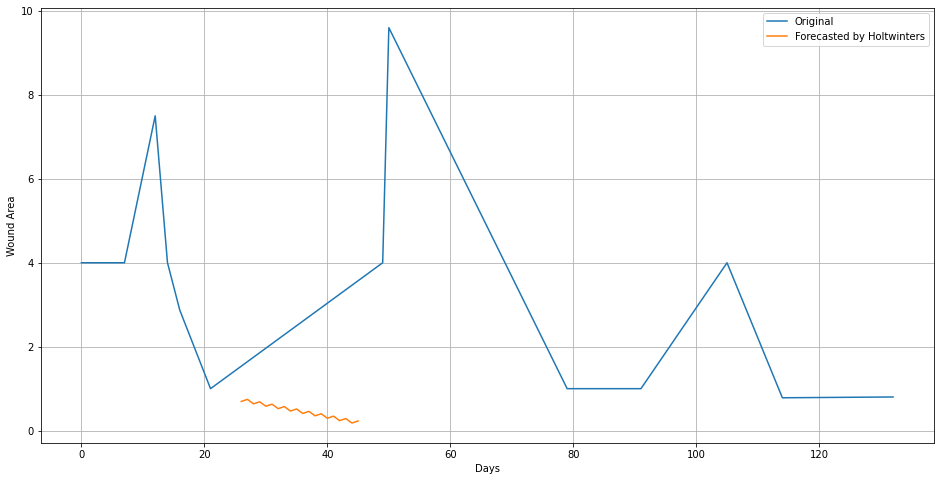

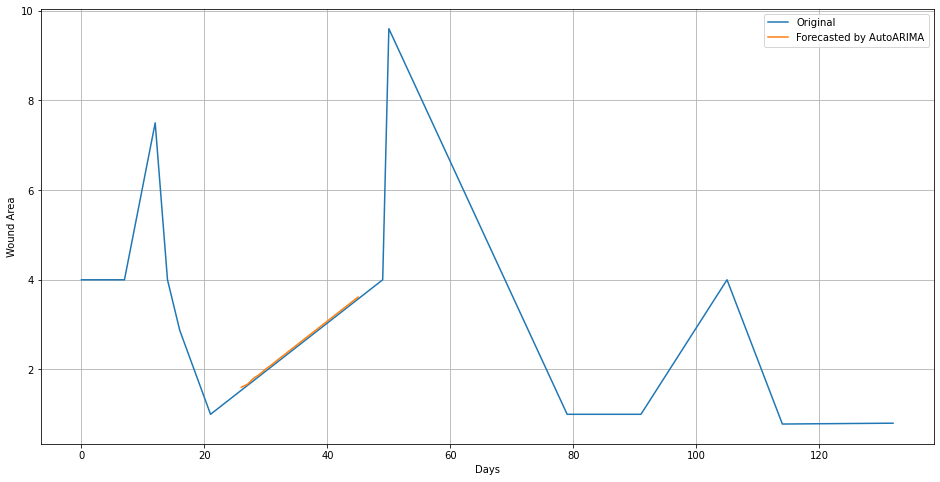

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.04723
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      54       144.636   2.29465e-05       81.8486   2.746e-07       0.001      109  LS failed, Hessian reset 
      84       144.637   8.91213e-09       74.7236      0.5662      0.5662      150   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


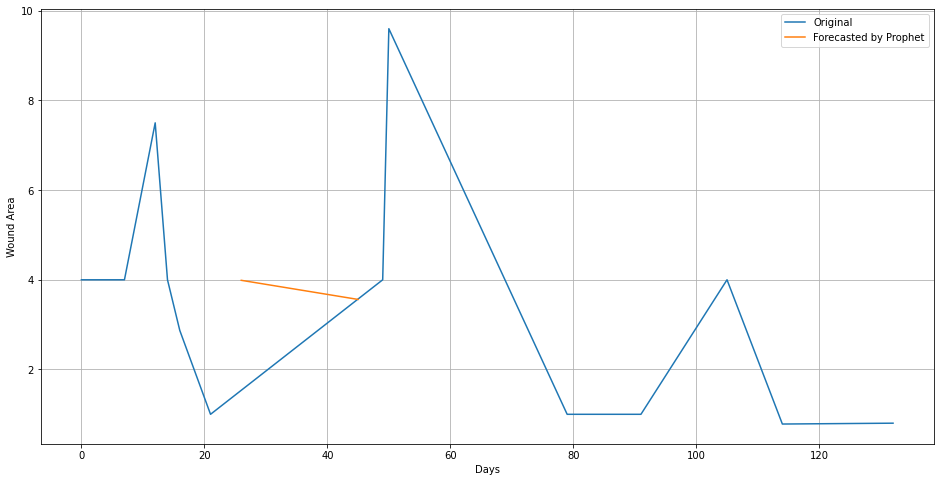

2023-10-25 17:43:57.477207: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-25 17:43:57.477436: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-25 17:43:57.676249: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the 

Total number of visit days after interpolation 133
4/4 [==============================] - 0s 761us/step


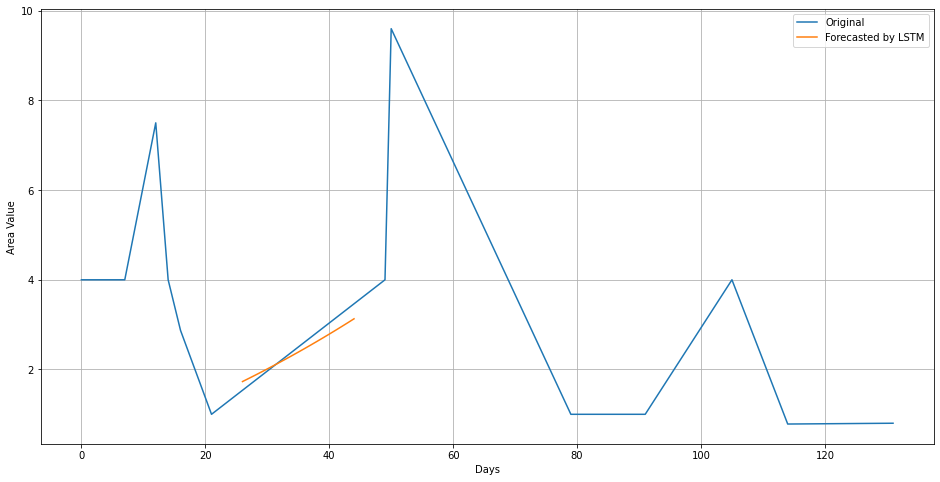

Total number of visit days after interpolation 133
1/1 [==============================] - 0s 221ms/step
test_dates shape: (19,)
predicted_values_test_inverse shape: (19, 1)


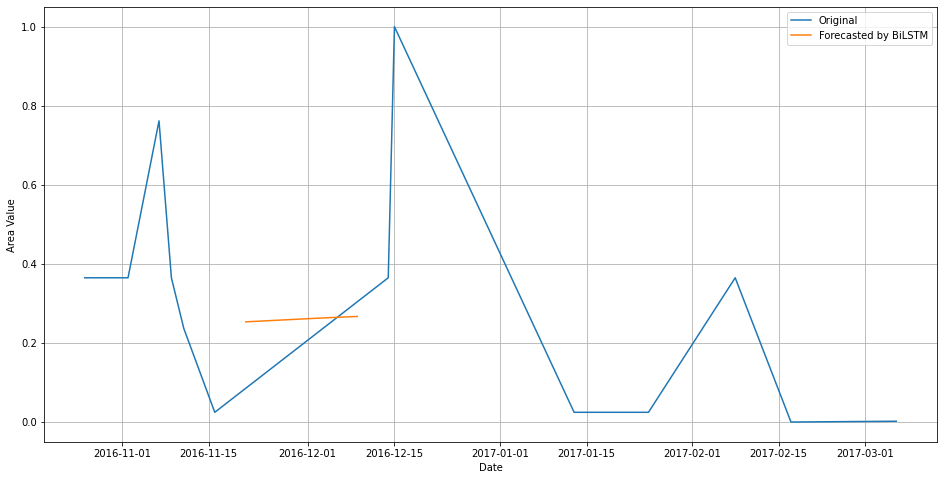

Done 0.00670331143584931 %
Wound: 2
26
39


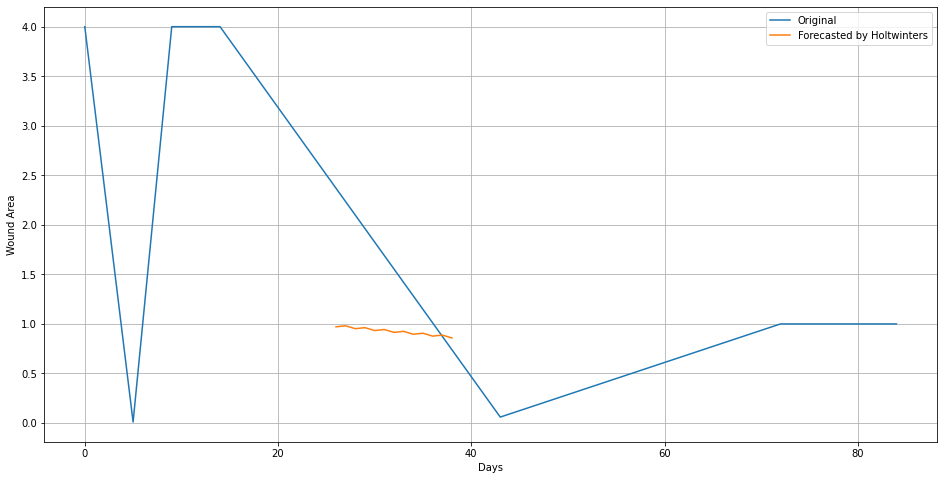

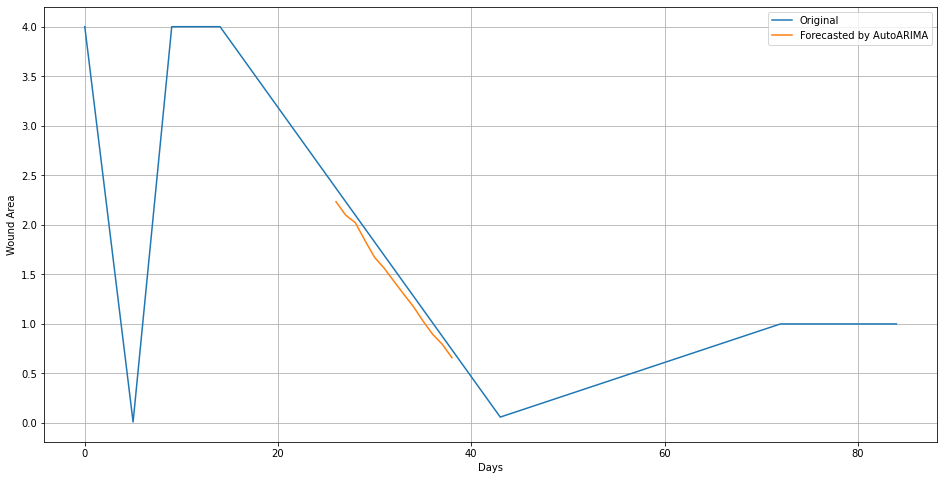

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Initial log joint probability = -77.9364
Iteration  1. Log joint probability =    50.8756. Improved by 128.812.
Iteration  2. Log joint probability =    76.6817. Improved by 25.8061.
Iteration  3. Log joint probability =    81.4686. Improved by 4.78691.
Iteration  4. Log joint probability =    81.7862. Improved by 0.317593.
Iteration  5. Log joint probability =    81.8051. Improved by 0.0188342.
Iteration  6. Log joint probability =    81.8643. Improved by 0.0592532.
Iteration  7. Log joint probability =    81.8724. Improved by 0.00811655.
Iteration  8. Log joint probability =    81.9566. Improved by 0.084213.
Iteration  9. Log joint probability =    81.9652. Improved by 0.00855911.
Iteration 10. Log joint probability =    81.9686. Improved by 0.00343382.
Iteration 11. Log joint probability =    81.9706. Improved by 0.00195578.
Iteration 12. Log joint probability =     81.977. Improved by 0.0064146.
Iteration 13. Log joint probability =    81.9885. Improved by 0.0114663.
Iteration 14.

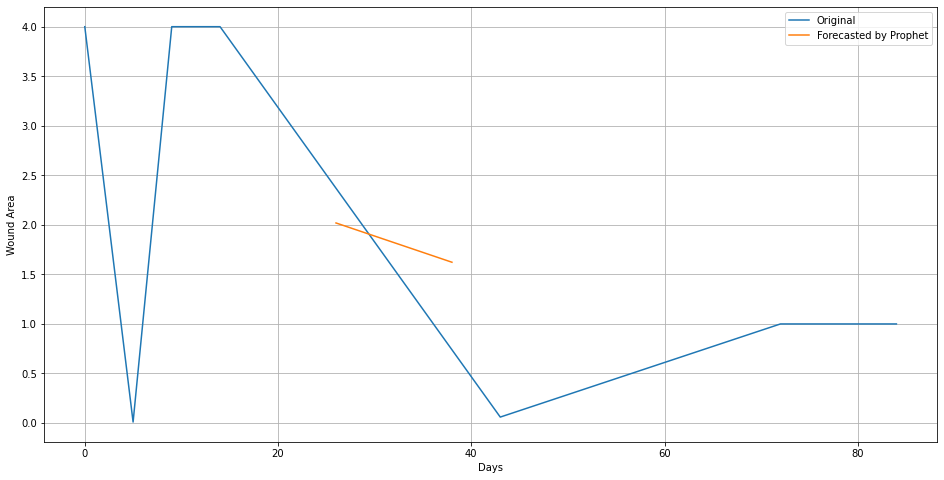

Total number of visit days after interpolation 85
3/3 [==============================] - 0s 909us/step


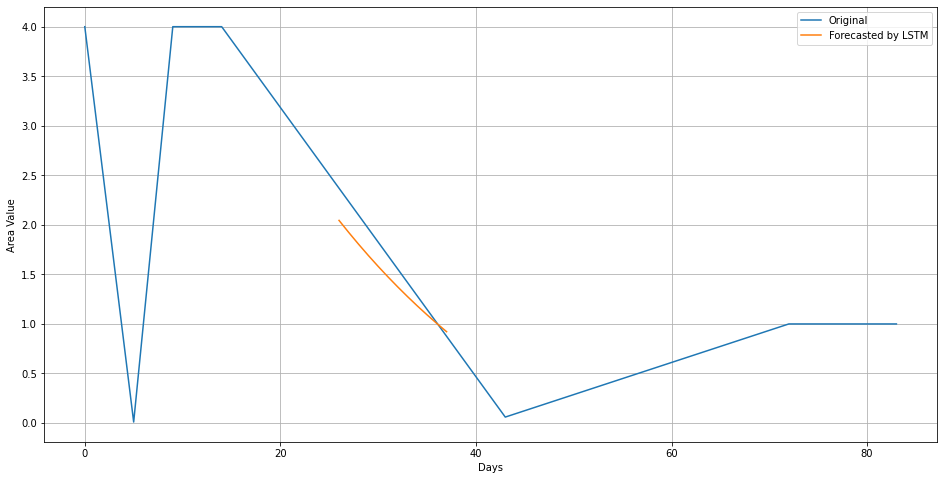

Total number of visit days after interpolation 85
1/1 [==============================] - 0s 222ms/step
test_dates shape: (12,)
predicted_values_test_inverse shape: (12, 1)


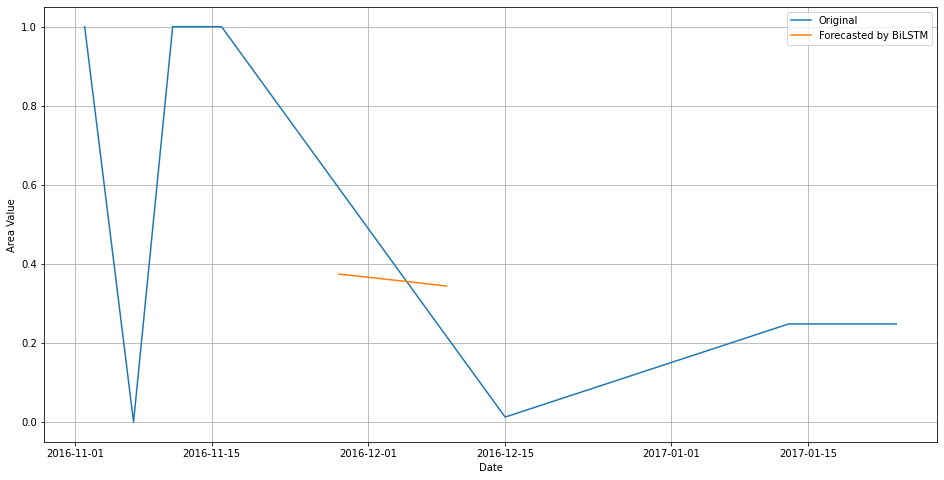

Done 0.01340662287169862 %
Wound: 3
10
12


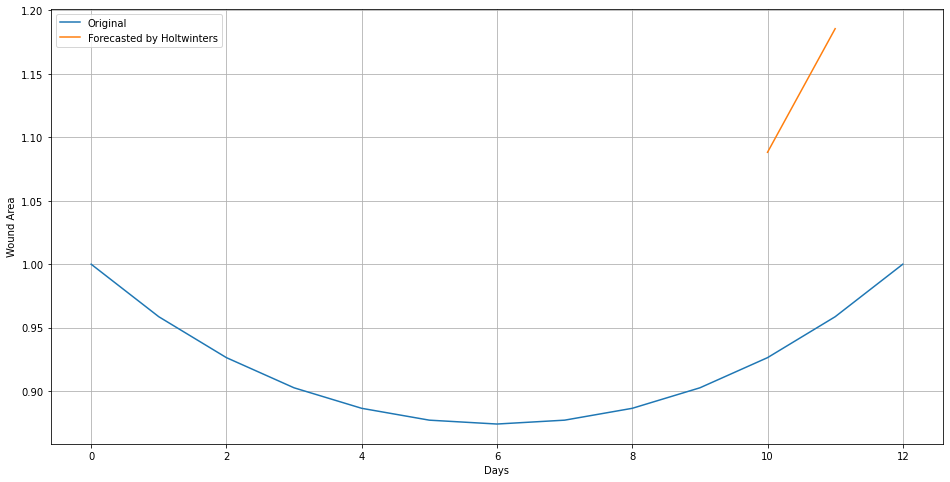

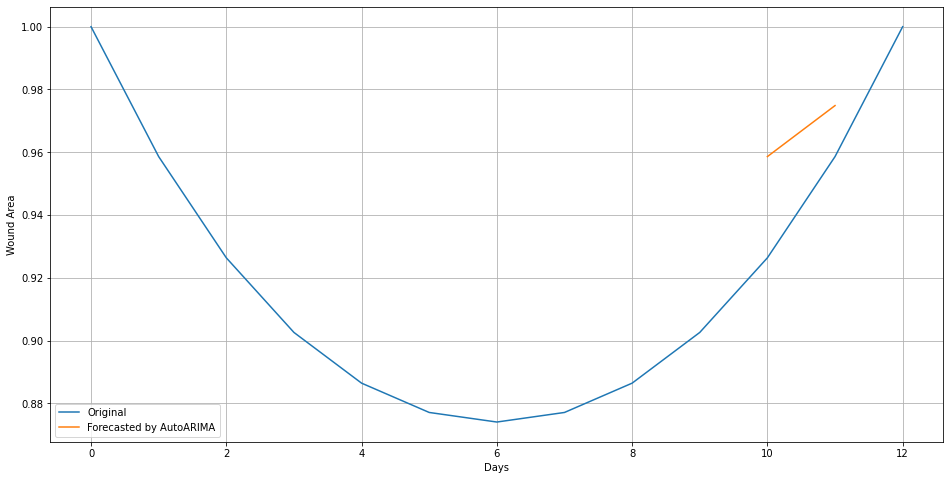

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 9.



Initial log joint probability = -24.3502
Iteration  1. Log joint probability =    12.2809. Improved by 36.6312.
Iteration  2. Log joint probability =    16.9866. Improved by 4.70569.
Iteration  3. Log joint probability =    29.6127. Improved by 12.6261.
Iteration  4. Log joint probability =    30.6495. Improved by 1.03683.
Iteration  5. Log joint probability =    33.3024. Improved by 2.65287.
Iteration  6. Log joint probability =    34.2095. Improved by 0.907118.
Iteration  7. Log joint probability =    34.2593. Improved by 0.0497576.
Iteration  8. Log joint probability =    34.2675. Improved by 0.00824367.
Iteration  9. Log joint probability =    34.3269. Improved by 0.0593844.
Iteration 10. Log joint probability =    34.3427. Improved by 0.0157604.
Iteration 11. Log joint probability =    35.6237. Improved by 1.28109.
Iteration 12. Log joint probability =    35.7795. Improved by 0.155723.
Iteration 13. Log joint probability =    35.8969. Improved by 0.117477.
Iteration 14. Log joint

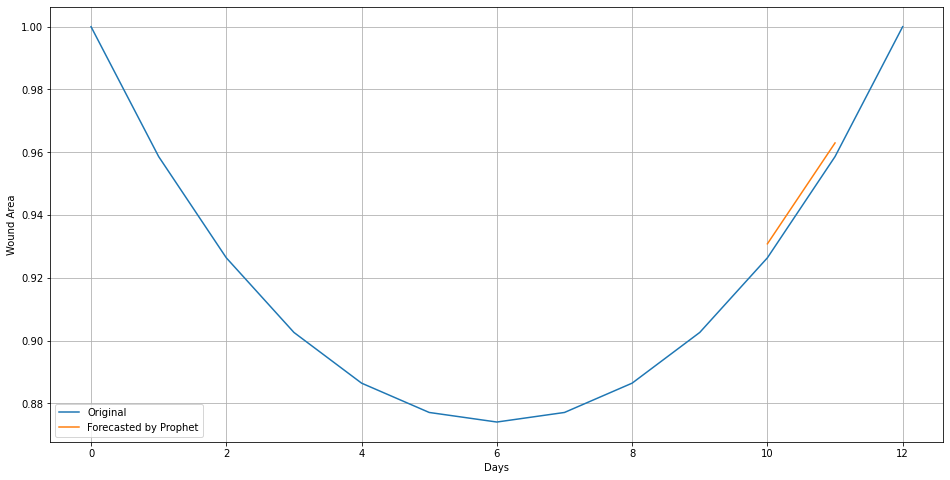

Total number of visit days after interpolation 13


1/1 [==============================] - 0s 8ms/step


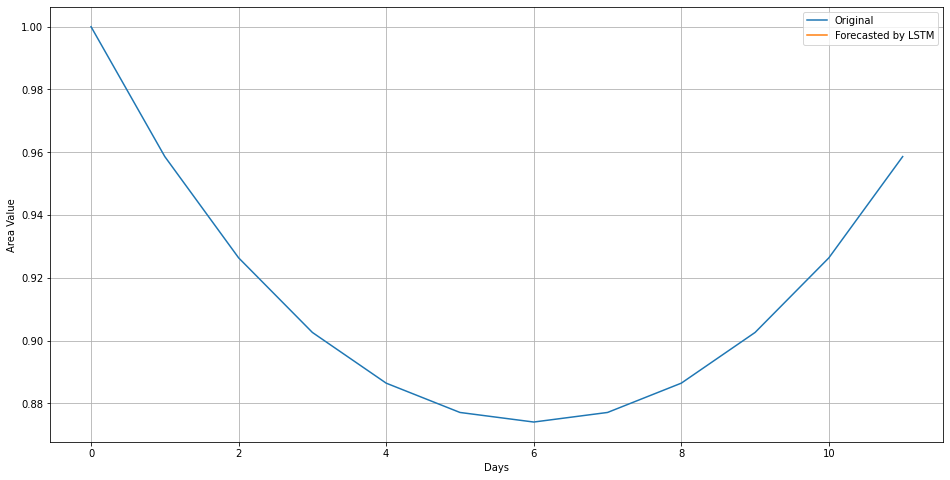

Total number of visit days after interpolation 13


1/1 [==============================] - 0s 213ms/step
test_dates shape: (1,)
predicted_values_test_inverse shape: (1, 1)


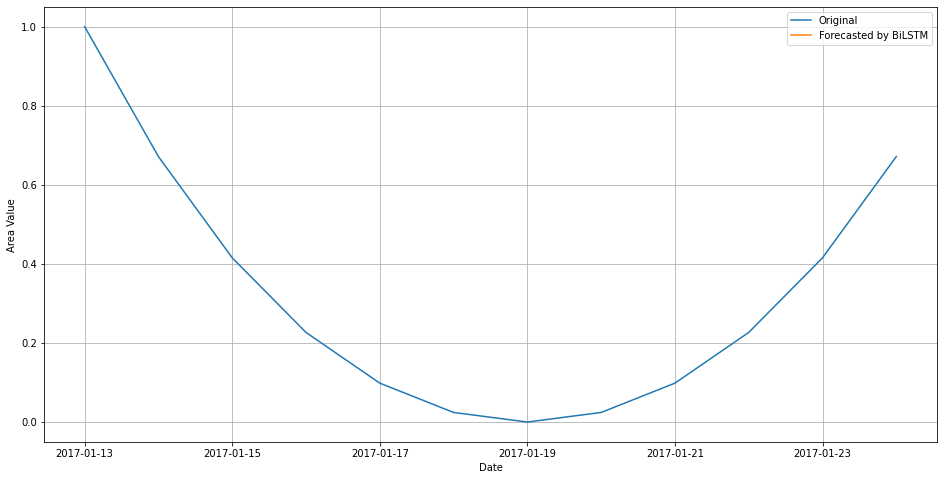

Done 0.020109934307547928 %
Wound: 4
2
5


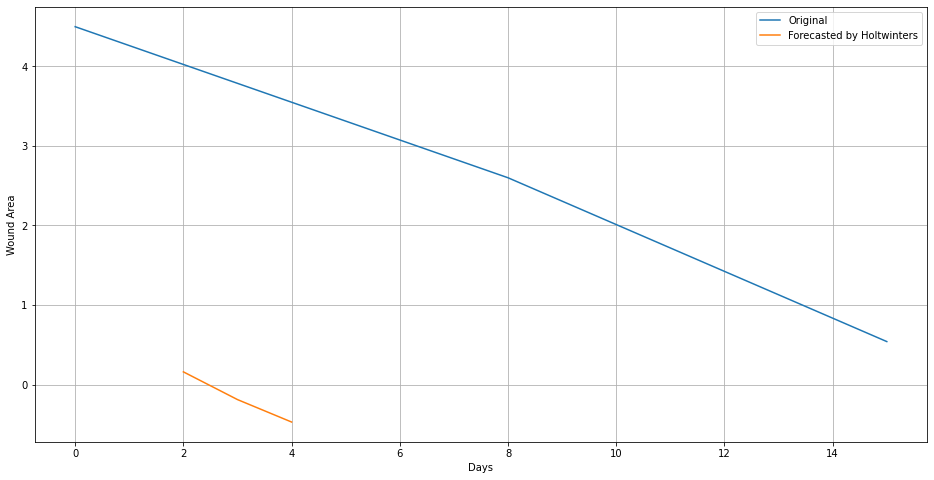

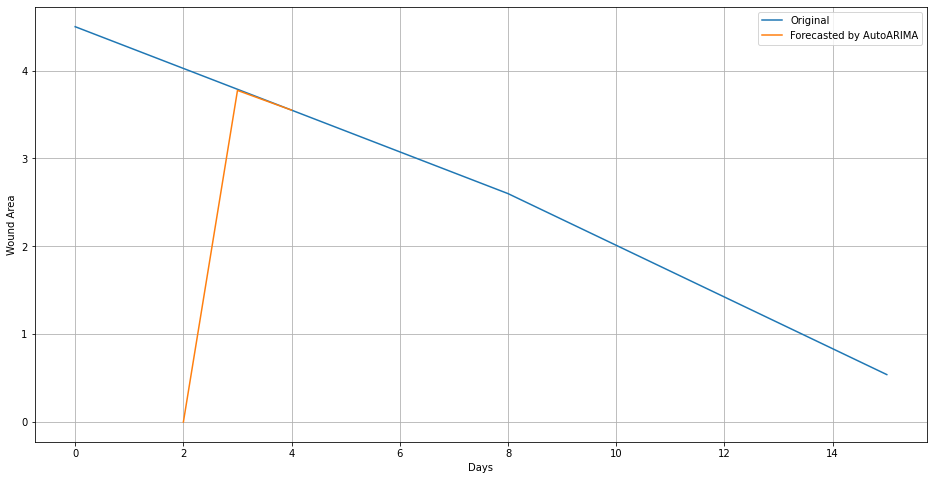

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 11.



Initial log joint probability = -41.7995
Iteration  1. Log joint probability =    27.9257. Improved by 69.7252.
Iteration  2. Log joint probability =    42.4025. Improved by 14.4768.
Iteration  3. Log joint probability =    49.2688. Improved by 6.86632.
Iteration  4. Log joint probability =    58.7221. Improved by 9.45326.
Iteration  5. Log joint probability =    59.6852. Improved by 0.9631.
Iteration  6. Log joint probability =    59.7316. Improved by 0.046418.
Iteration  7. Log joint probability =    59.8805. Improved by 0.148928.
Iteration  8. Log joint probability =    60.6456. Improved by 0.76514.
Iteration  9. Log joint probability =    69.7685. Improved by 9.12288.
Iteration 10. Log joint probability =    79.2078. Improved by 9.43927.
Iteration 11. Log joint probability =    89.2253. Improved by 10.0175.
Iteration 12. Log joint probability =    98.4733. Improved by 9.24801.
Iteration 13. Log joint probability =    100.947. Improved by 2.47345.
Iteration 14. Log joint probabilit

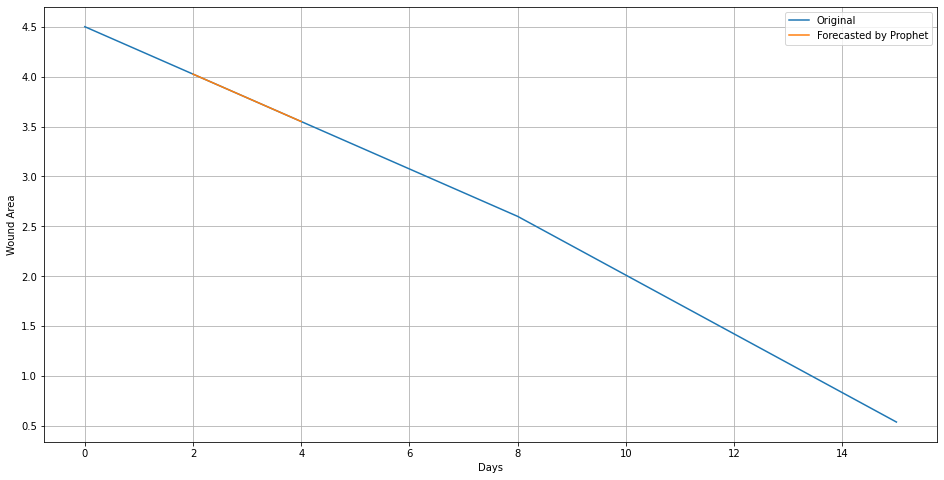

Total number of visit days after interpolation 16
1/1 [==============================] - 0s 9ms/step


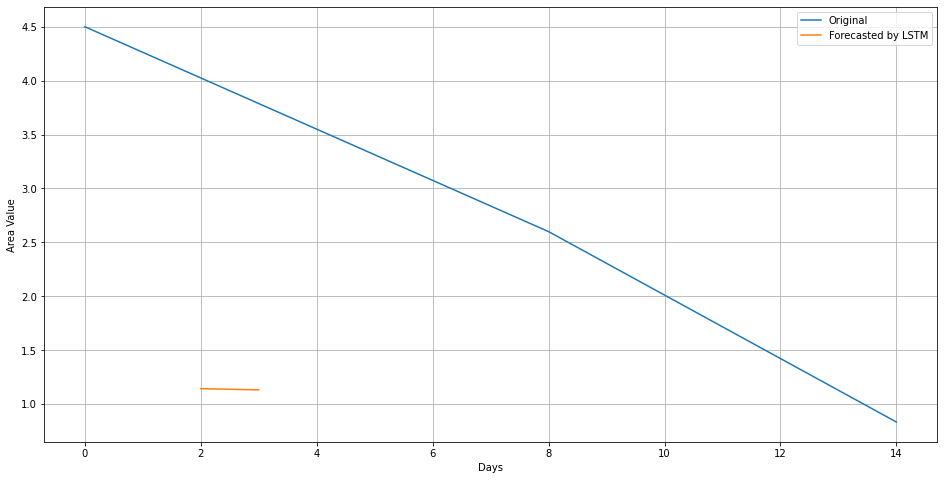

Total number of visit days after interpolation 16
1/1 [==============================] - 0s 217ms/step
test_dates shape: (2,)
predicted_values_test_inverse shape: (2, 1)


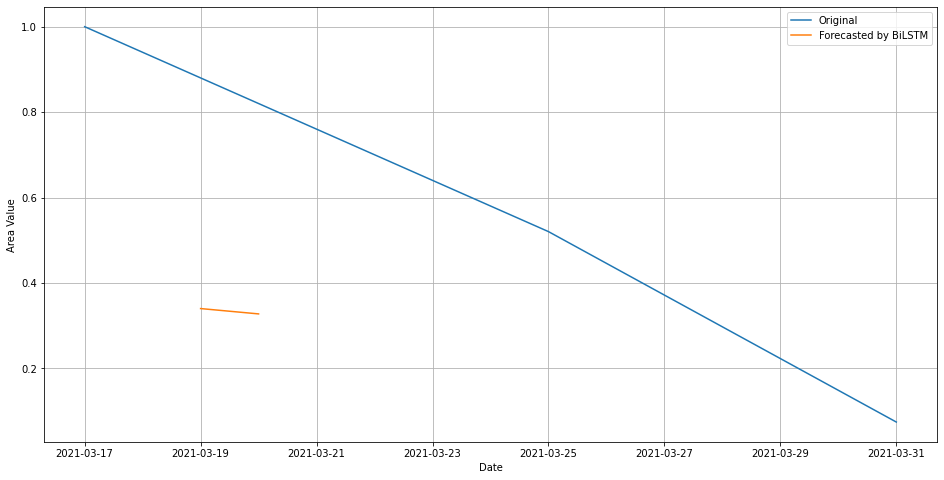

Done 0.02681324574339724 %
Wound: 5
4
7


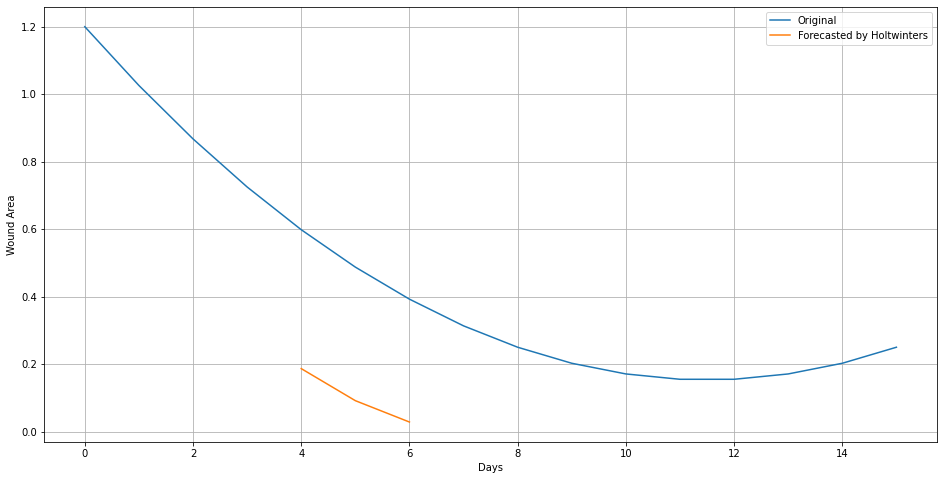

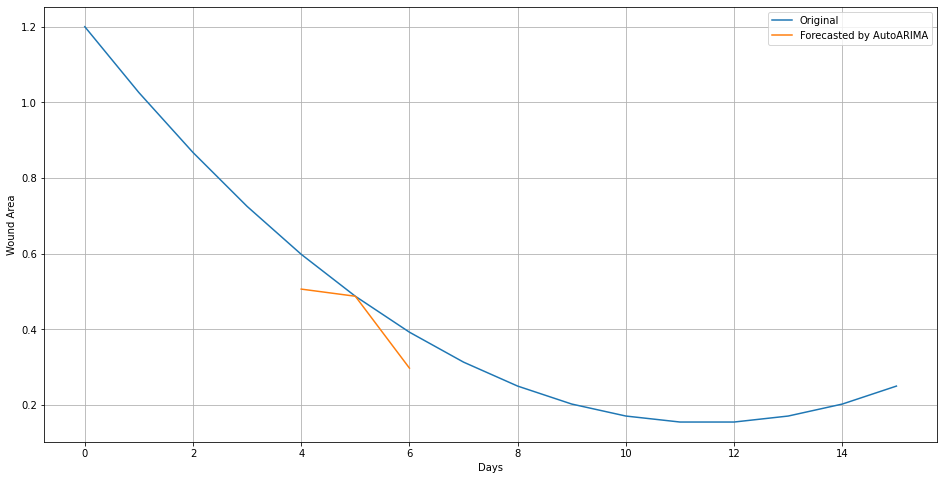

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 11.



Initial log joint probability = -42.3418
Iteration  1. Log joint probability =    9.70306. Improved by 52.0449.
Iteration  2. Log joint probability =    19.7769. Improved by 10.0739.
Iteration  3. Log joint probability =    21.9322. Improved by 2.15532.
Iteration  4. Log joint probability =    23.8605. Improved by 1.92821.
Iteration  5. Log joint probability =    24.5736. Improved by 0.713138.
Iteration  6. Log joint probability =    24.6496. Improved by 0.0760481.
Iteration  7. Log joint probability =    24.9082. Improved by 0.258587.
Iteration  8. Log joint probability =    25.0541. Improved by 0.145852.
Iteration  9. Log joint probability =    25.0732. Improved by 0.0190831.
Iteration 10. Log joint probability =    25.1102. Improved by 0.036991.
Iteration 11. Log joint probability =    25.1783. Improved by 0.068108.
Iteration 12. Log joint probability =     25.206. Improved by 0.0277864.
Iteration 13. Log joint probability =    25.2286. Improved by 0.0225874.
Iteration 14. Log join

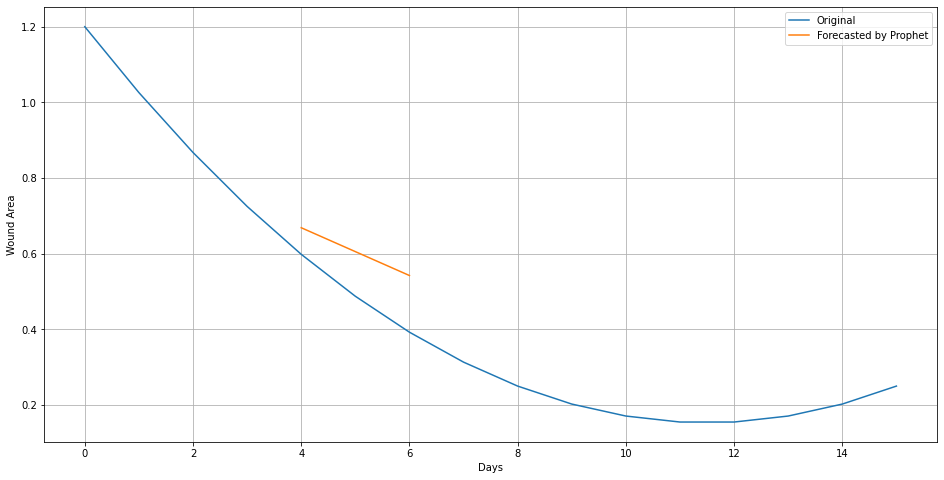

Total number of visit days after interpolation 16
1/1 [==============================] - 0s 8ms/step


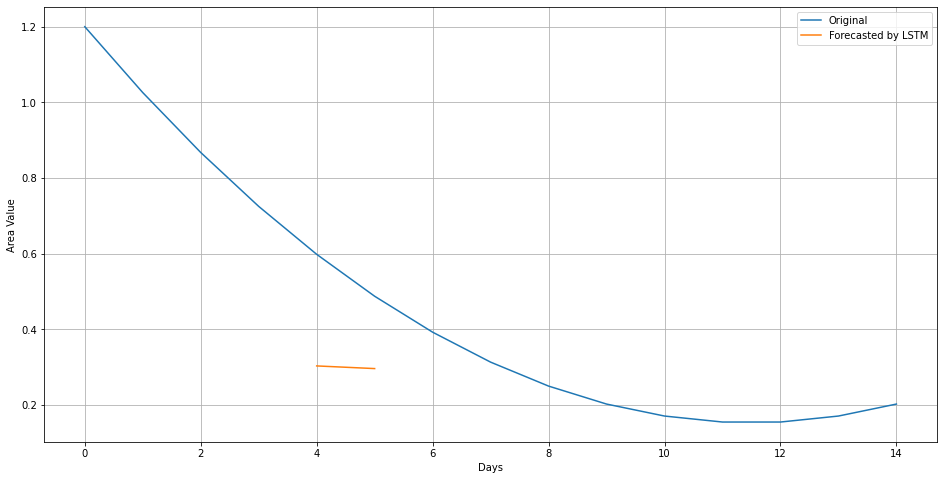

Total number of visit days after interpolation 16
1/1 [==============================] - 0s 216ms/step
test_dates shape: (2,)
predicted_values_test_inverse shape: (2, 1)


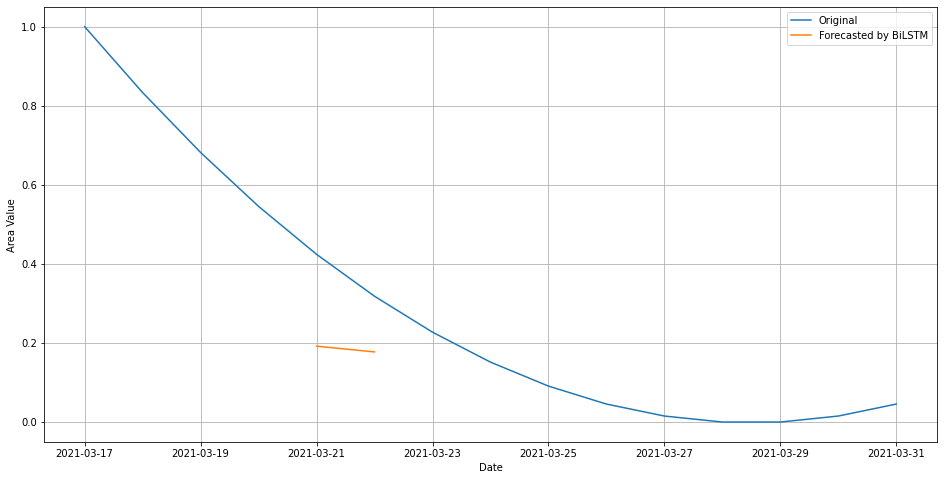

Done 0.03351655717924655 %
Wound: 6
122
174


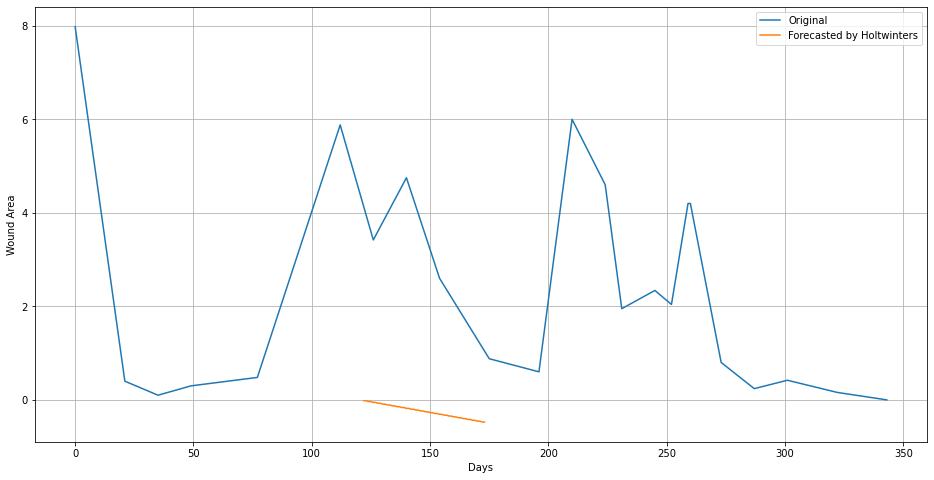

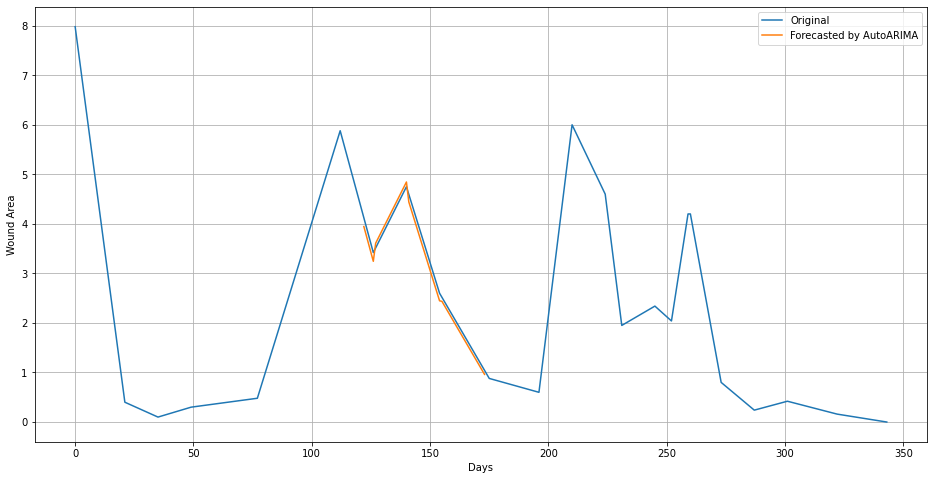

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -30.562
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       341.672   0.000462894       61.6592      0.5657      0.5657      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     129       342.787     0.0047503       62.3251   5.423e-05       0.001      204  LS failed, Hessian reset 
     182       343.233   0.000305709       66.6604   4.428e-06       0.001      311  LS failed, Hessian reset 
     199       343.242   7.22527e-07       37.0629       0.393       0.393      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     222       343.242   3.19666e-09       80.7438     0.00589     0.00589      379   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


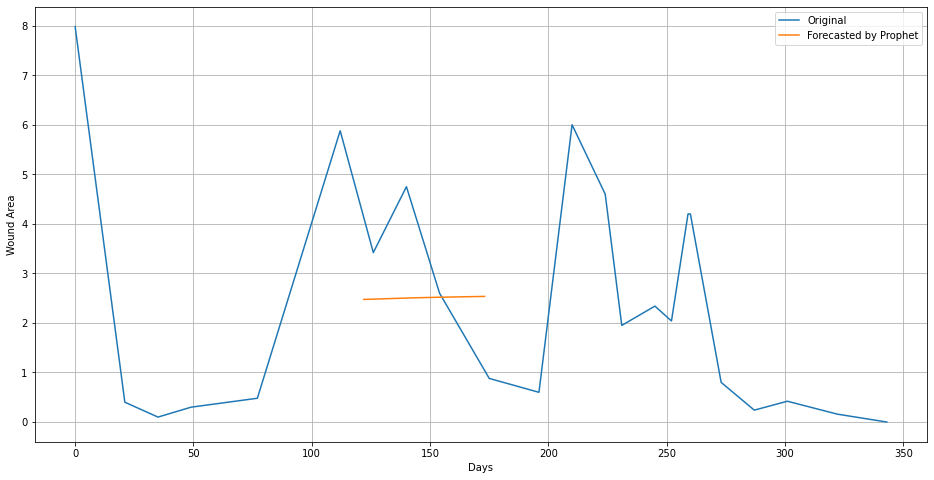

Total number of visit days after interpolation 344
10/10 [==============================] - 0s 942us/step


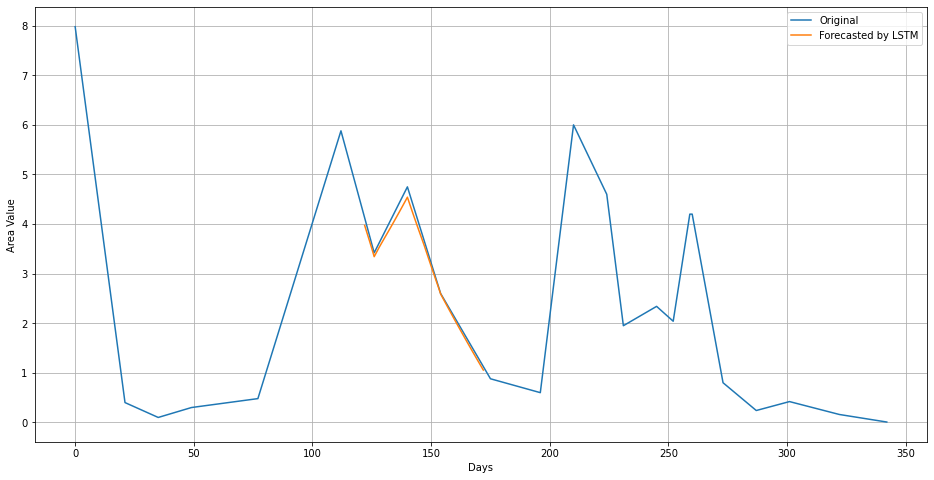

Total number of visit days after interpolation 344
2/2 [==============================] - 0s 2ms/step
test_dates shape: (51,)
predicted_values_test_inverse shape: (51, 1)


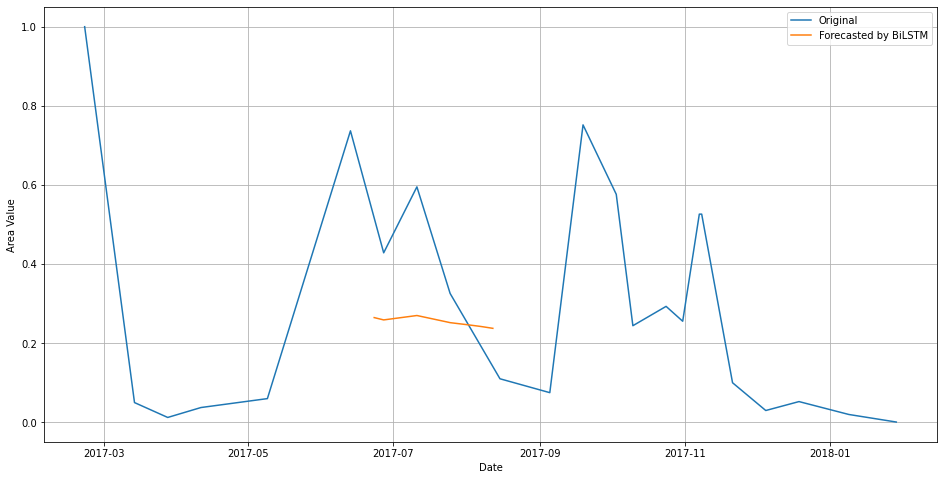

Done 0.040219868615095855 %
Wound: 7
6
9


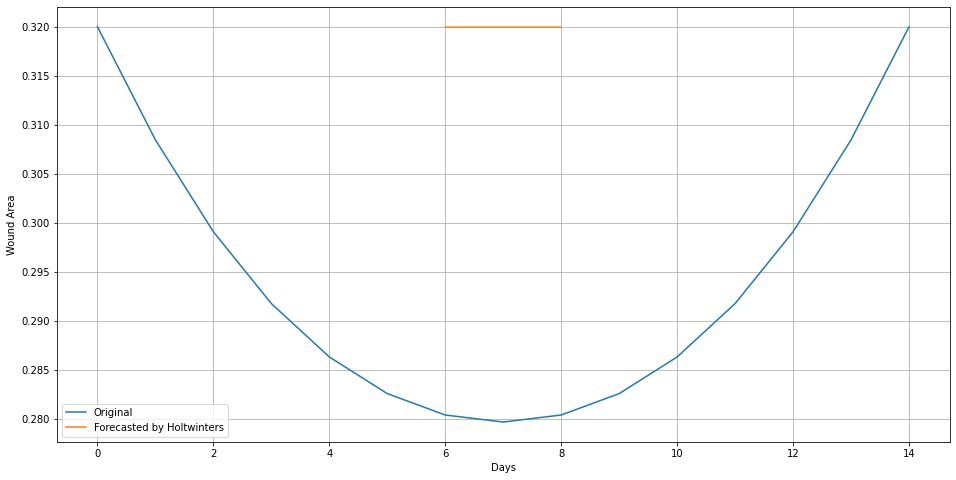

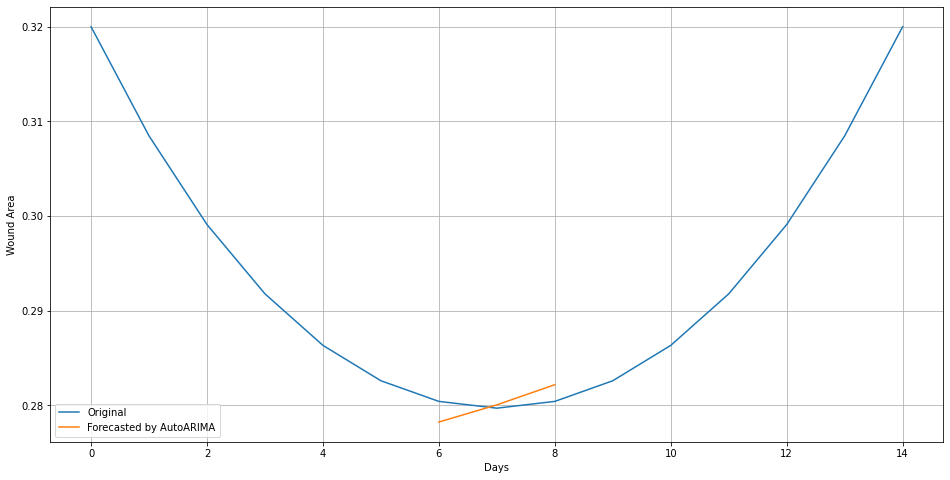

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 11.



Initial log joint probability = -40.9209
Iteration  1. Log joint probability =    15.4392. Improved by 56.3601.
Iteration  2. Log joint probability =    22.2015. Improved by 6.76221.
Iteration  3. Log joint probability =    32.3305. Improved by 10.129.
Iteration  4. Log joint probability =    39.1655. Improved by 6.83506.
Iteration  5. Log joint probability =    39.7801. Improved by 0.614602.
Iteration  6. Log joint probability =    39.8261. Improved by 0.0459259.
Iteration  7. Log joint probability =    39.8576. Improved by 0.0315101.
Iteration  8. Log joint probability =     39.867. Improved by 0.00945698.
Iteration  9. Log joint probability =    42.8497. Improved by 2.98262.
Iteration 10. Log joint probability =    44.6035. Improved by 1.75382.
Iteration 11. Log joint probability =    45.4268. Improved by 0.823342.
Iteration 12. Log joint probability =    47.7543. Improved by 2.32752.
Iteration 13. Log joint probability =    49.6795. Improved by 1.92517.
Iteration 14. Log joint pro

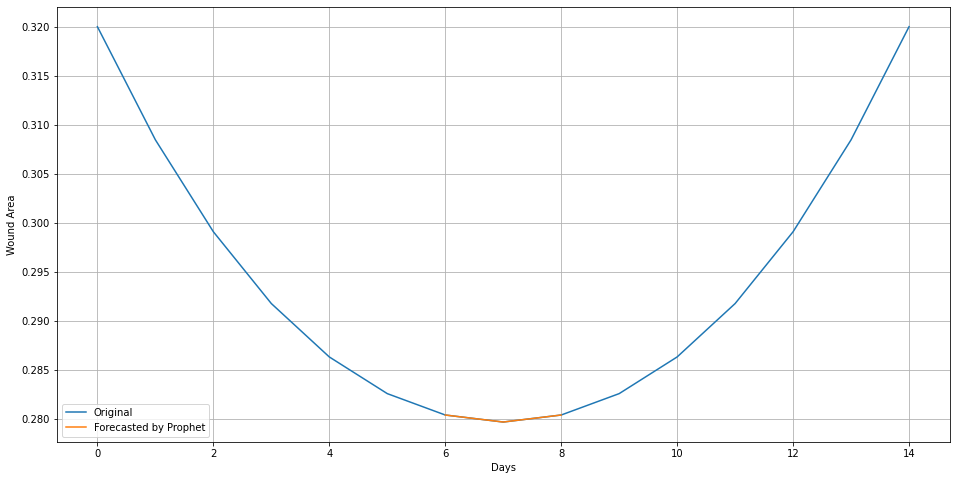

Total number of visit days after interpolation 15
1/1 [==============================] - 0s 9ms/step


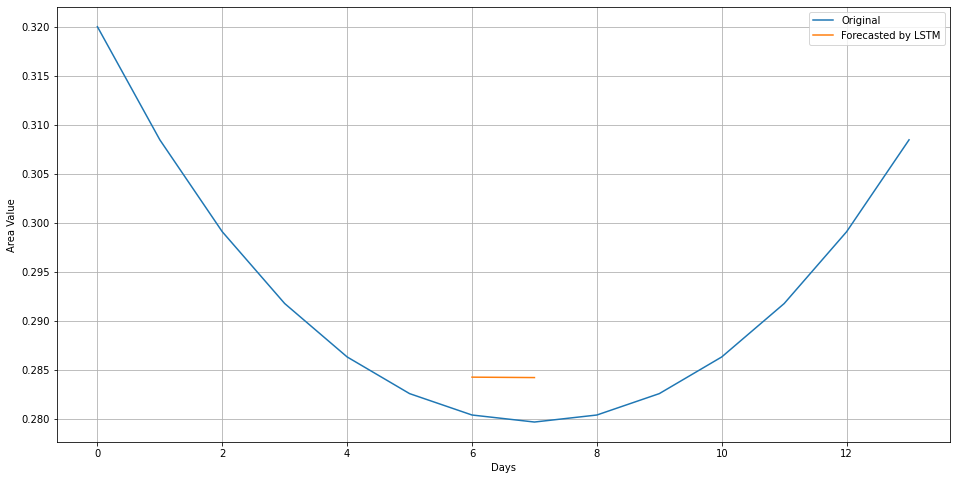

Total number of visit days after interpolation 15
1/1 [==============================] - 1s 566ms/step
test_dates shape: (2,)
predicted_values_test_inverse shape: (2, 1)


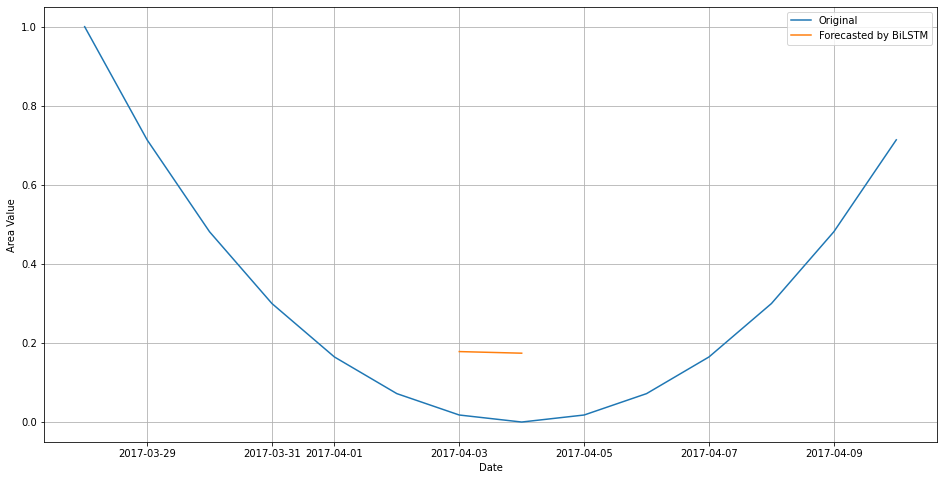

Done 0.04692318005094517 %
Wound: 8
12
18


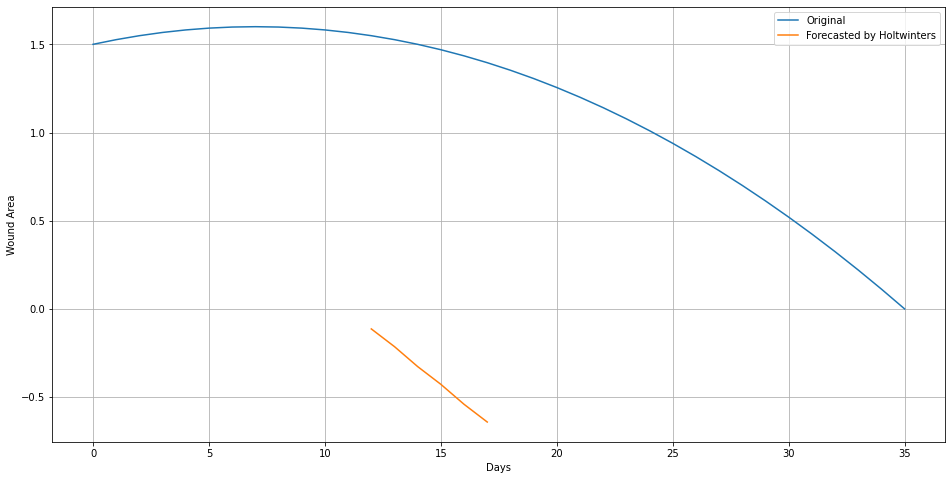

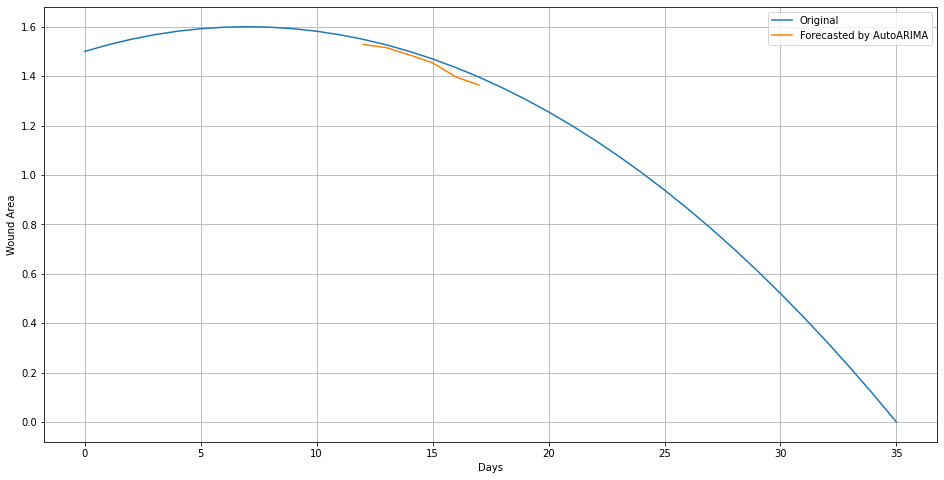

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Initial log joint probability = -29.3603
Iteration  1. Log joint probability =    18.3637. Improved by 47.7241.
Iteration  2. Log joint probability =    47.7219. Improved by 29.3582.
Iteration  3. Log joint probability =    51.5151. Improved by 3.79316.
Iteration  4. Log joint probability =    54.4527. Improved by 2.93762.
Iteration  5. Log joint probability =    55.2022. Improved by 0.749472.
Iteration  6. Log joint probability =    55.2217. Improved by 0.0195413.
Iteration  7. Log joint probability =    55.2325. Improved by 0.0108395.
Iteration  8. Log joint probability =    55.3754. Improved by 0.142821.
Iteration  9. Log joint probability =    55.4184. Improved by 0.0430484.
Iteration 10. Log joint probability =    55.5384. Improved by 0.120015.
Iteration 11. Log joint probability =    55.5693. Improved by 0.0308853.
Iteration 12. Log joint probability =    55.6356. Improved by 0.0662583.
Iteration 13. Log joint probability =    55.8433. Improved by 0.207721.
Iteration 14. Log joi

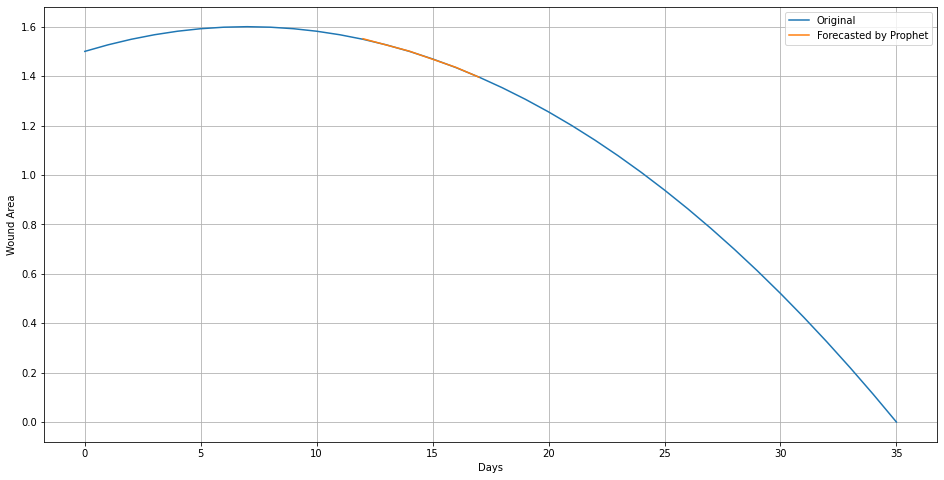

Total number of visit days after interpolation 36
1/1 [==============================] - 0s 8ms/step


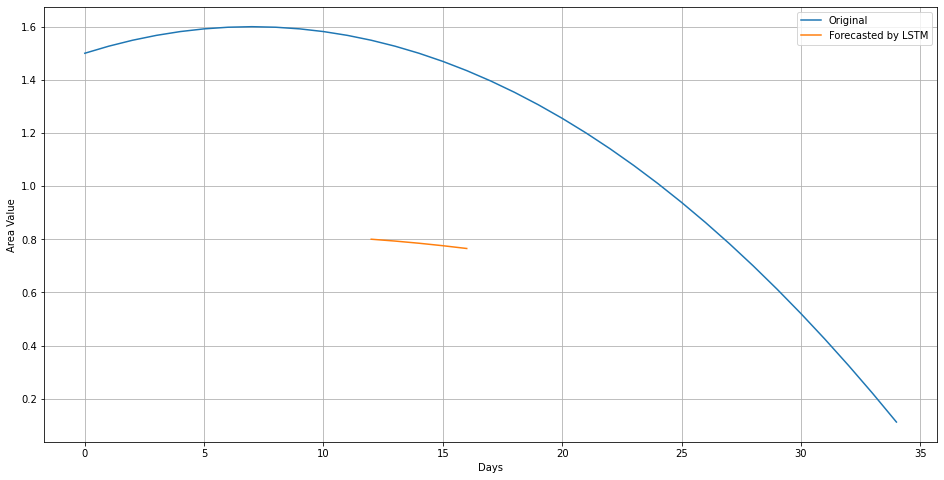

Total number of visit days after interpolation 36
1/1 [==============================] - 0s 226ms/step
test_dates shape: (5,)
predicted_values_test_inverse shape: (5, 1)


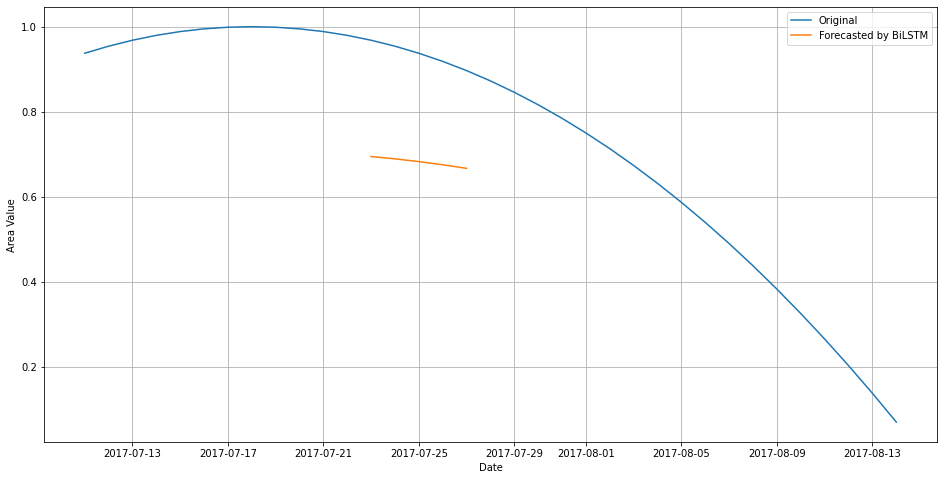

Done 0.05362649148679448 %
Wound: 9
28
66


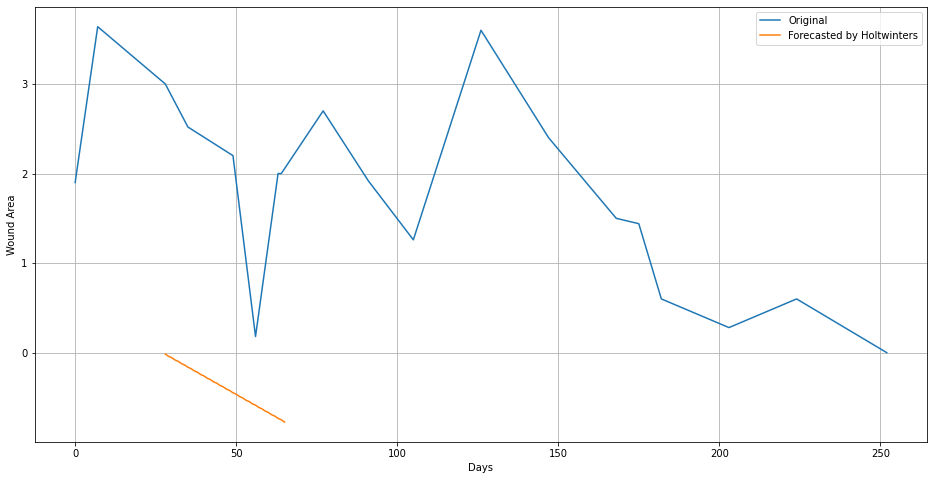

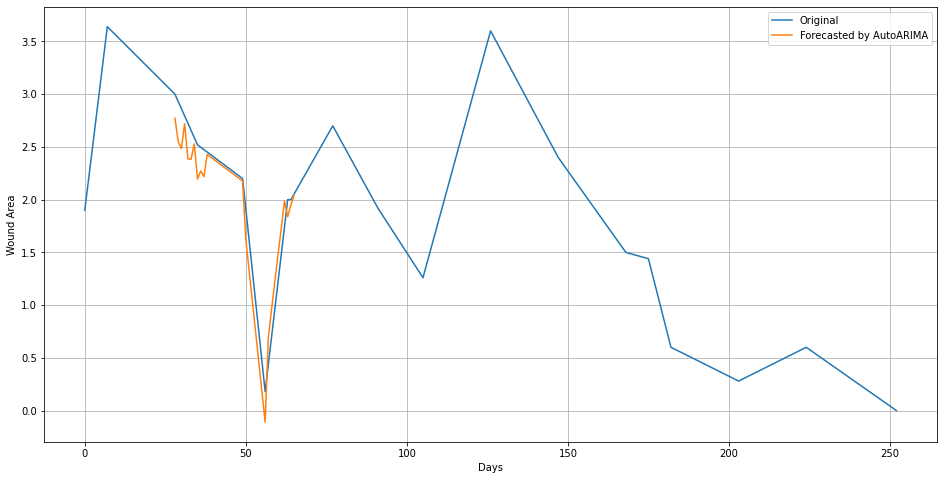

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -13.5515
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       302.679   0.000136044       85.5755           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       302.766   6.38694e-05       66.5013      0.7086      0.7086      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       302.782   5.56949e-05       81.7459       4.694      0.4694      379   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     381       303.051   5.34625e-09       69.9442   7.384e-05           1      493   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


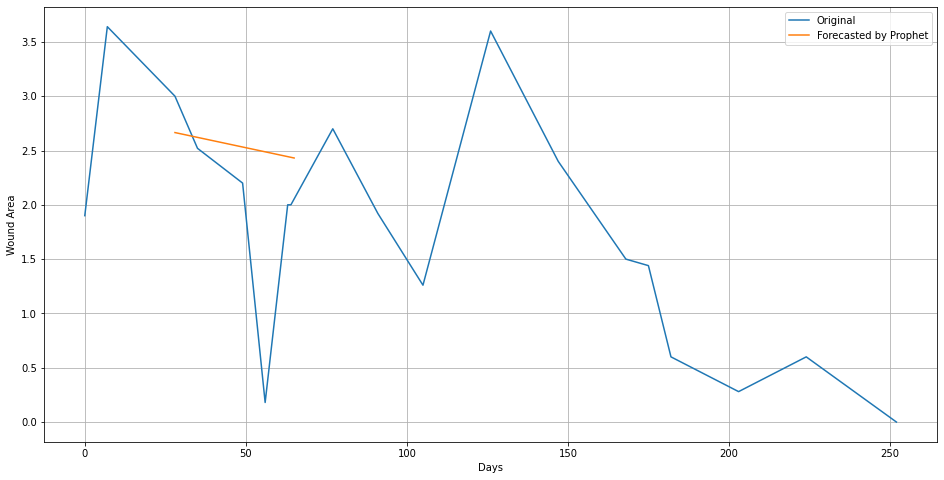

Total number of visit days after interpolation 253
7/7 [==============================] - 0s 1ms/step


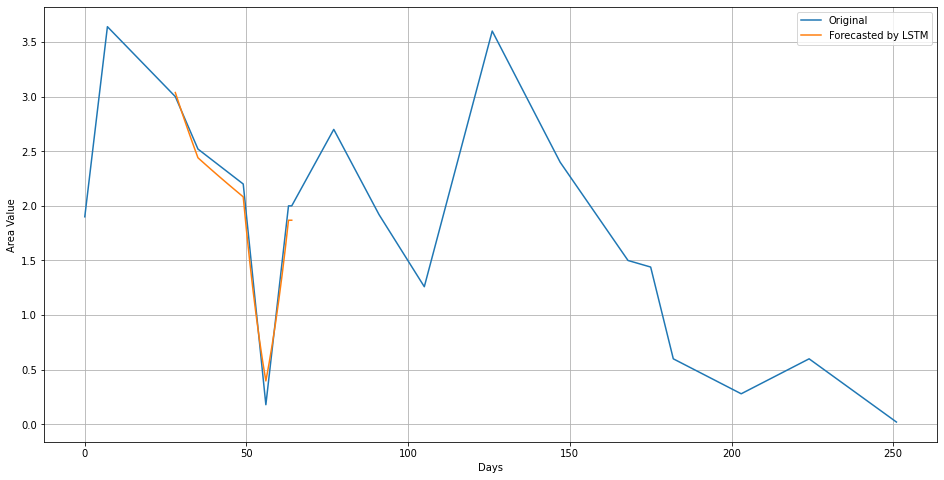

Total number of visit days after interpolation 253
2/2 [==============================] - 0s 1ms/step
test_dates shape: (37,)
predicted_values_test_inverse shape: (37, 1)


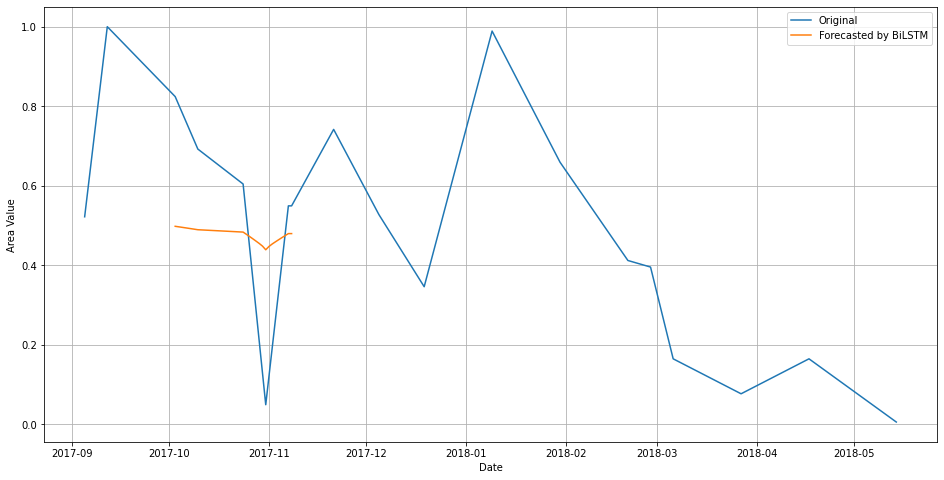

Done 0.06032980292264378 %
Wound: 10
13
36


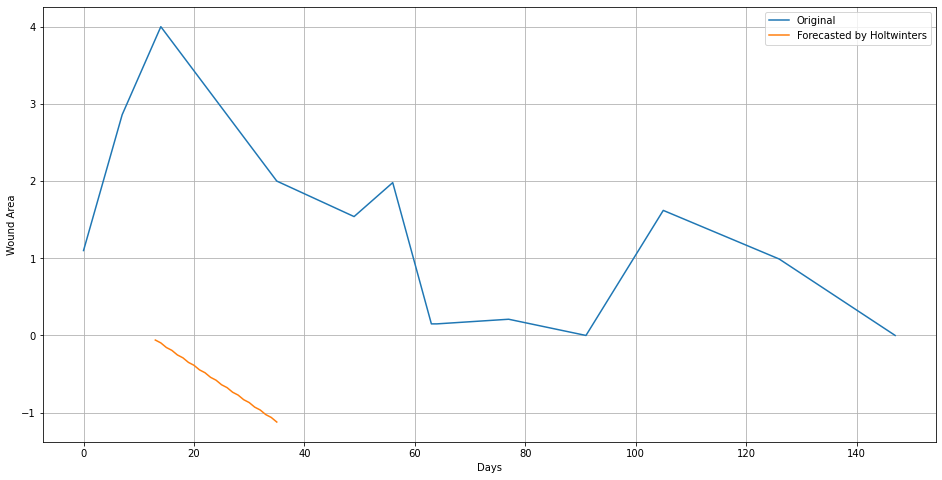

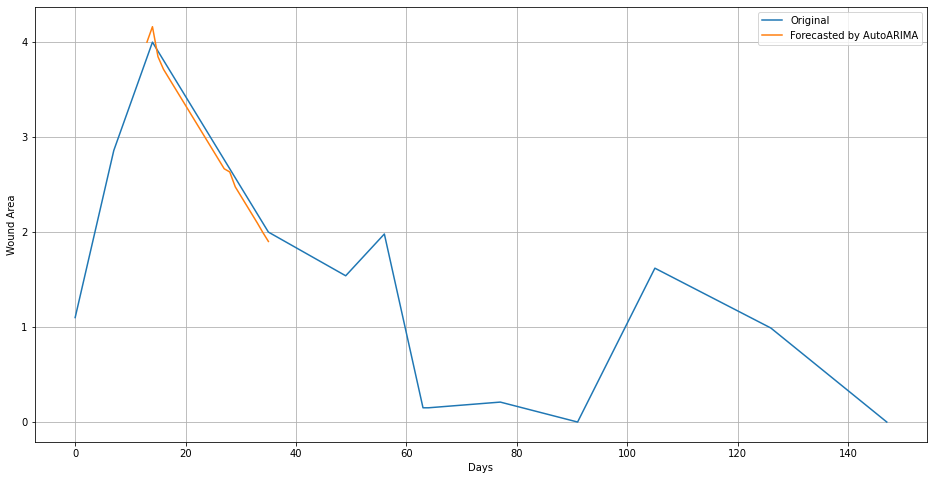

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -8.5879
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       176.436   1.96401e-06       69.0752      0.3315      0.3315      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     146       176.725    0.00235084       73.4872   2.478e-05       0.001      239  LS failed, Hessian reset 
     199        176.93   8.12433e-07       75.1916      0.5992      0.5992      310   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     221        176.93   1.06378e-06       80.4177   1.173e-08       0.001      374  LS failed, Hessian reset 
     239        176.93   7.68164e-09       71.2875      0.6305      0.6305      398   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


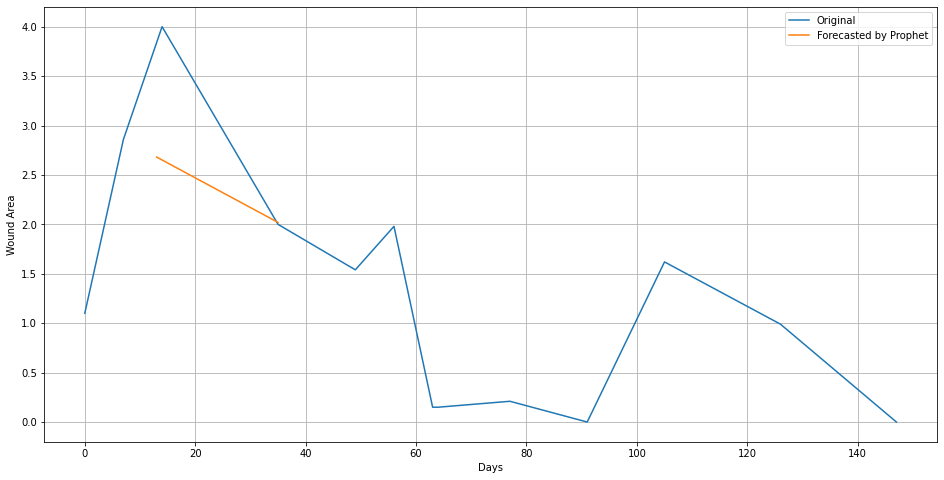

Total number of visit days after interpolation 148
4/4 [==============================] - 0s 969us/step


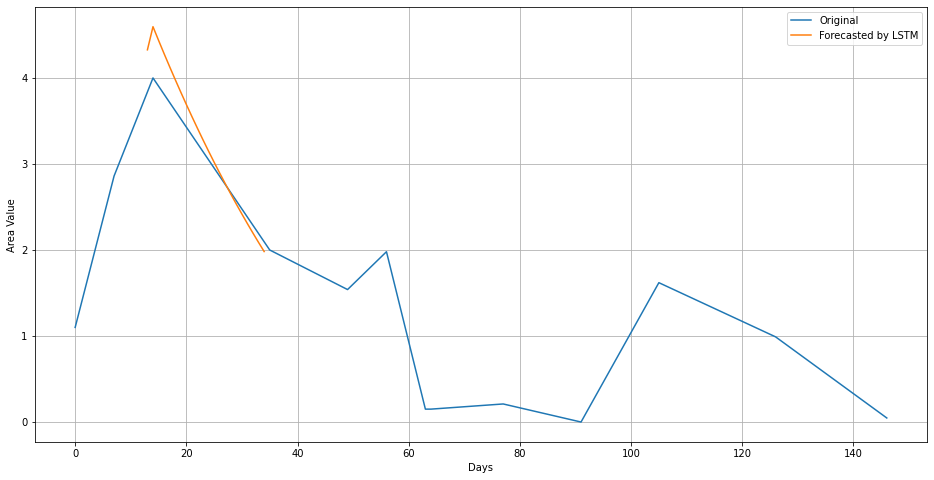

Total number of visit days after interpolation 148
1/1 [==============================] - 0s 222ms/step
test_dates shape: (22,)
predicted_values_test_inverse shape: (22, 1)


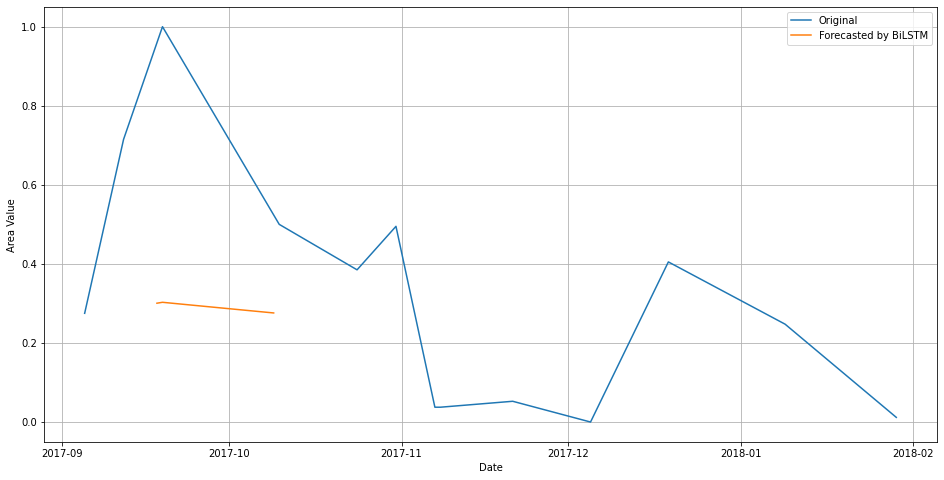

Done 0.0670331143584931 %
Wound: 11
14
21


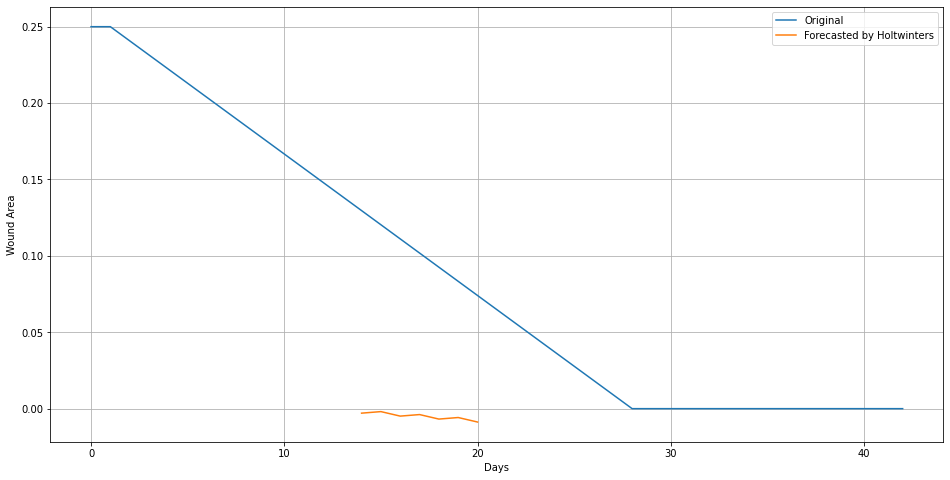

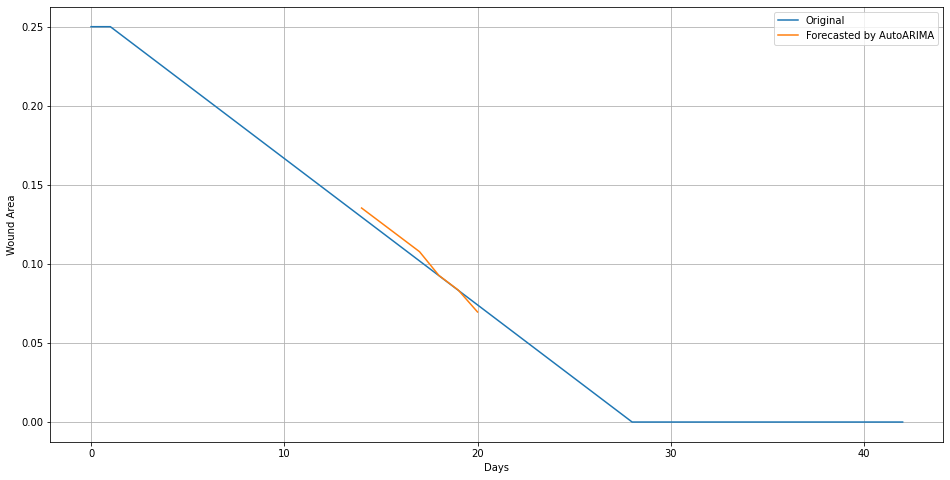

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Initial log joint probability = -35.1009
Iteration  1. Log joint probability =    33.0833. Improved by 68.1842.
Iteration  2. Log joint probability =     61.277. Improved by 28.1937.
Iteration  3. Log joint probability =    73.8823. Improved by 12.6053.
Iteration  4. Log joint probability =    77.5348. Improved by 3.65251.
Iteration  5. Log joint probability =    78.3533. Improved by 0.818453.
Iteration  6. Log joint probability =    78.4273. Improved by 0.0740177.
Iteration  7. Log joint probability =    78.5914. Improved by 0.16407.
Iteration  8. Log joint probability =    78.5975. Improved by 0.00615244.
Iteration  9. Log joint probability =    78.8244. Improved by 0.226864.
Iteration 10. Log joint probability =    78.8428. Improved by 0.0183784.
Iteration 11. Log joint probability =    78.8429. Improved by 0.000109156.
Iteration 12. Log joint probability =    78.8949. Improved by 0.0520583.
Iteration 13. Log joint probability =     78.921. Improved by 0.0260901.
Iteration 14. Log 

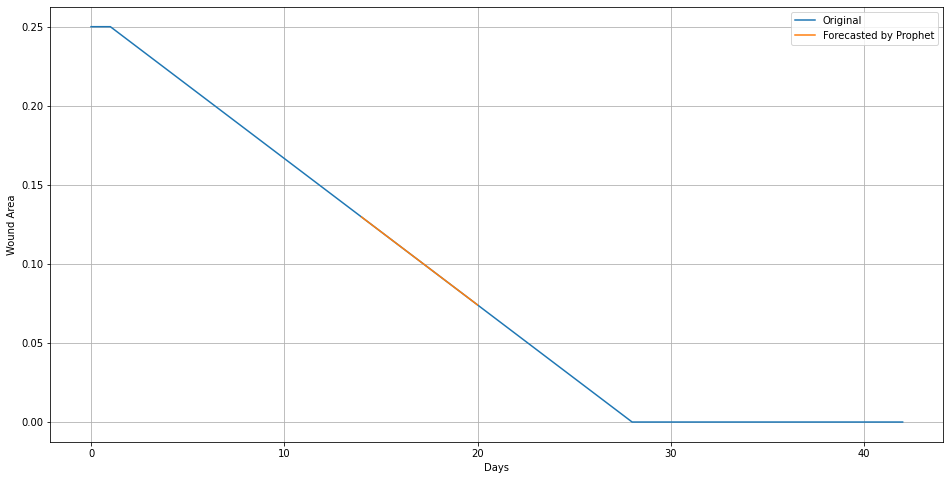

Total number of visit days after interpolation 43
2/2 [==============================] - 0s 1ms/step


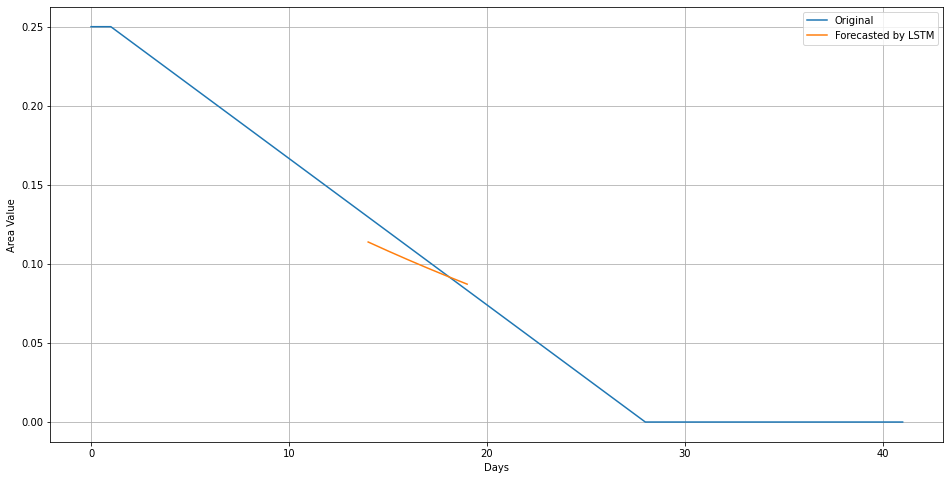

Total number of visit days after interpolation 43
1/1 [==============================] - 0s 222ms/step
test_dates shape: (6,)
predicted_values_test_inverse shape: (6, 1)


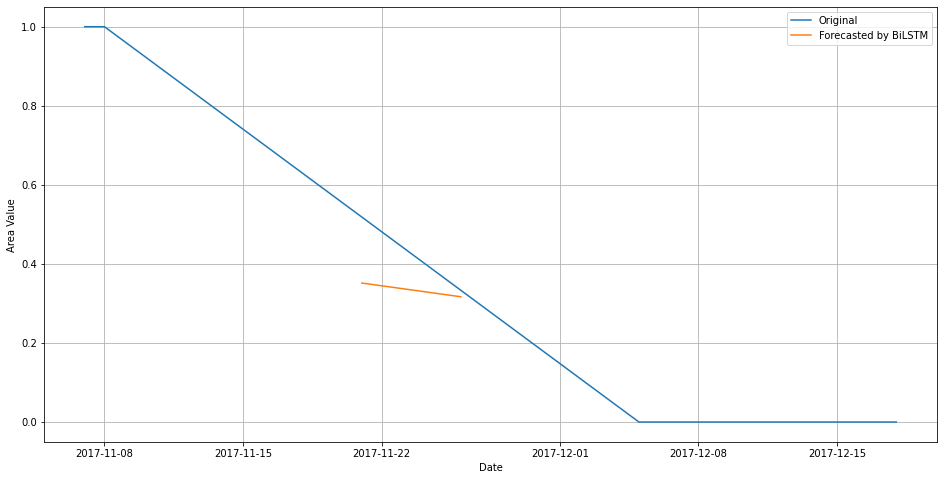

Done 0.0737364257943424 %
Wound: 12
10
13


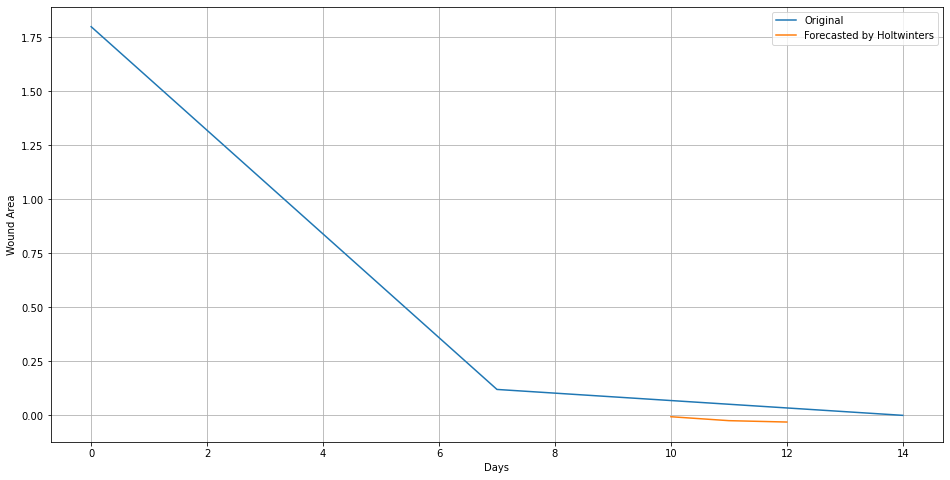

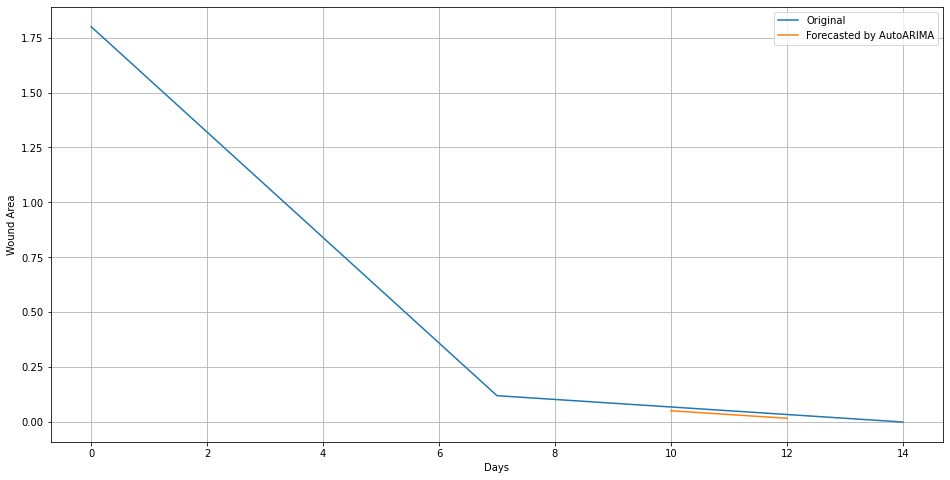

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 11.



Initial log joint probability = -41.3221
Iteration  1. Log joint probability =    1.84178. Improved by 43.1639.
Iteration  2. Log joint probability =    2.34584. Improved by 0.504061.
Iteration  3. Log joint probability =    21.8926. Improved by 19.5468.
Iteration  4. Log joint probability =    21.9419. Improved by 0.0492302.
Iteration  5. Log joint probability =    21.9562. Improved by 0.0143761.
Iteration  6. Log joint probability =    21.9684. Improved by 0.012127.
Iteration  7. Log joint probability =    22.0366. Improved by 0.0682595.
Iteration  8. Log joint probability =    22.2581. Improved by 0.221468.
Iteration  9. Log joint probability =     22.277. Improved by 0.0189168.
Iteration 10. Log joint probability =    22.2952. Improved by 0.0182089.
Iteration 11. Log joint probability =    22.4081. Improved by 0.112913.
Iteration 12. Log joint probability =    22.4359. Improved by 0.0277402.
Iteration 13. Log joint probability =    22.4546. Improved by 0.0187515.
Iteration 14. Log

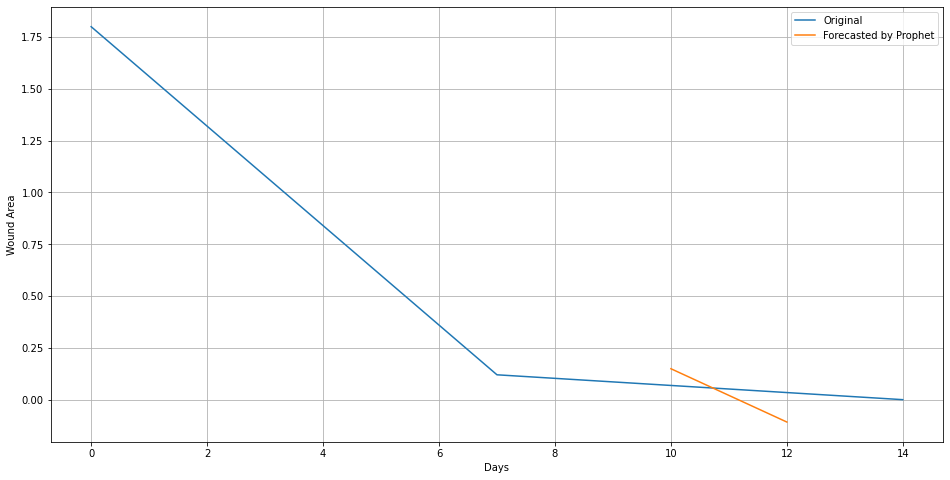

Total number of visit days after interpolation 15
1/1 [==============================] - 0s 8ms/step


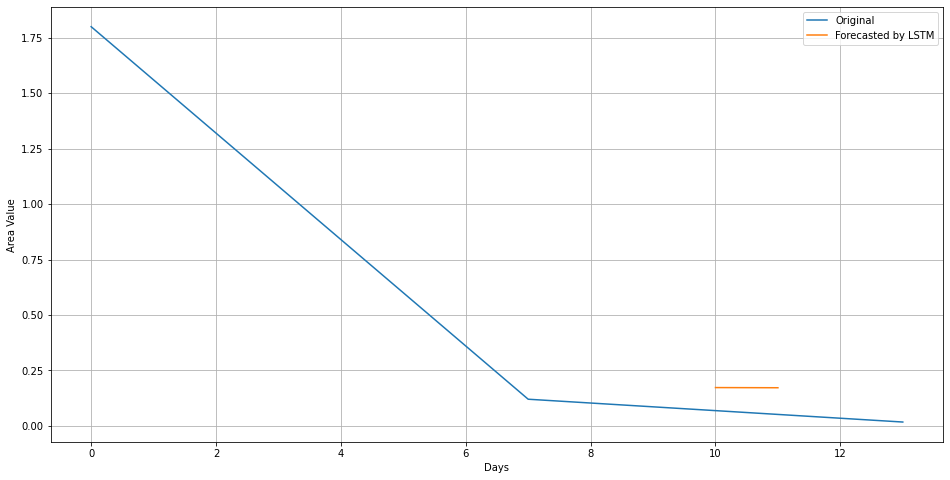

Total number of visit days after interpolation 15
1/1 [==============================] - 0s 218ms/step
test_dates shape: (2,)
predicted_values_test_inverse shape: (2, 1)


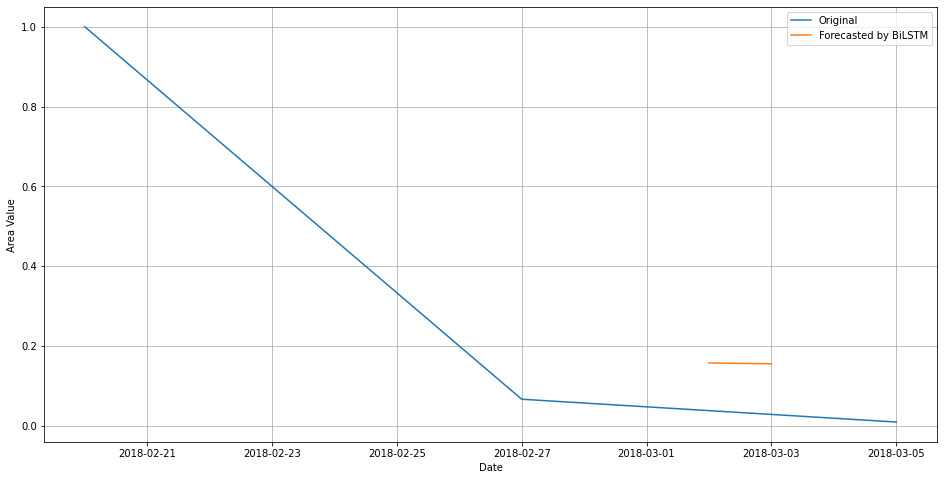

Done 0.08043973723019171 %
Wound: 13
295
375


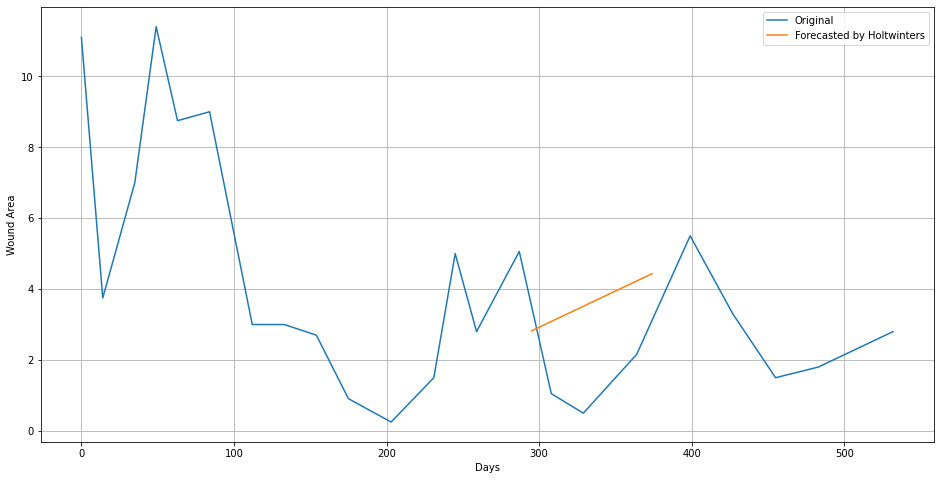

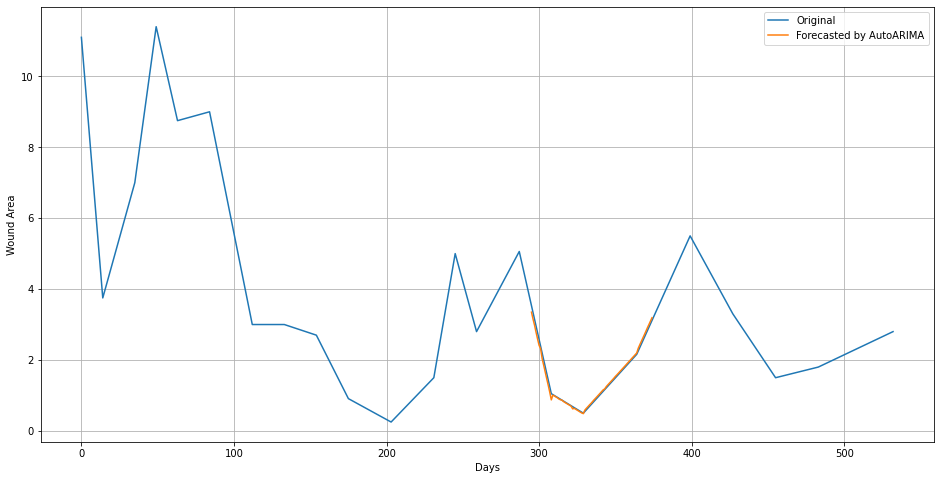

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -38.2458
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.537    0.00277418       72.9233      0.5636      0.5636      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     133       720.602    0.00435421       88.1041   5.185e-05       0.001      211  LS failed, Hessian reset 
     182        720.98   1.05572e-08       62.1563      0.2935     0.02935      286   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


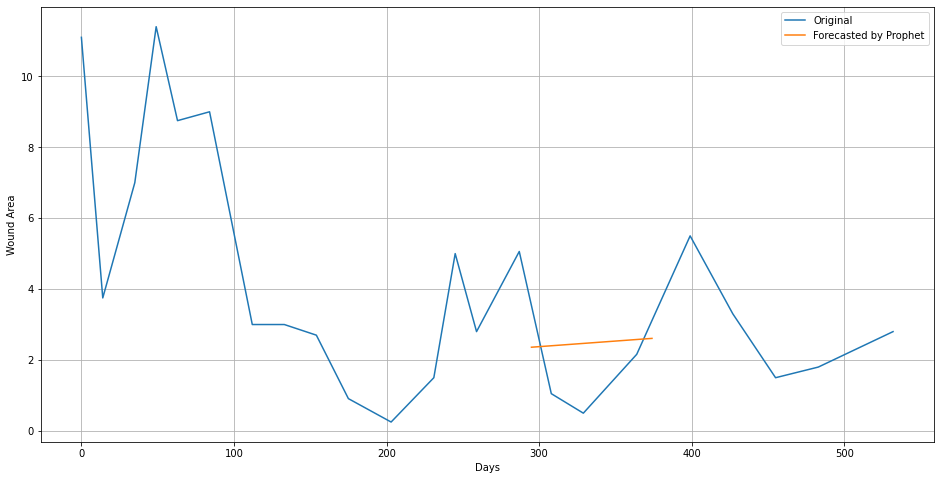

Total number of visit days after interpolation 533
15/15 [==============================] - 0s 819us/step


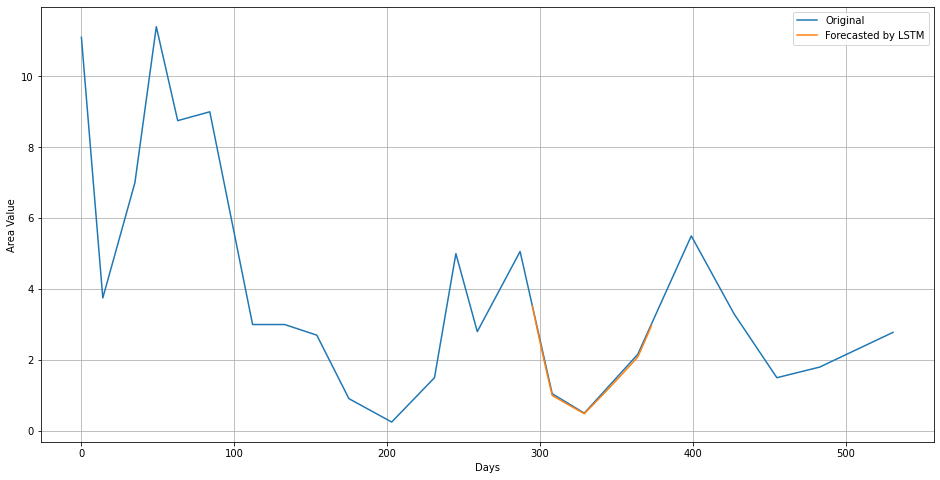

Total number of visit days after interpolation 533
3/3 [==============================] - 0s 1ms/step
test_dates shape: (79,)
predicted_values_test_inverse shape: (79, 1)


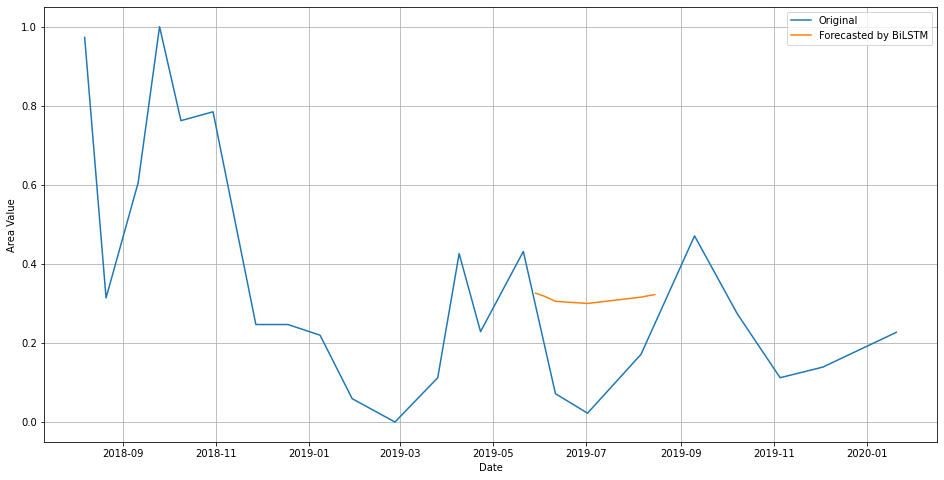

Done 0.08714304866604103 %
Wound: 14
55
68


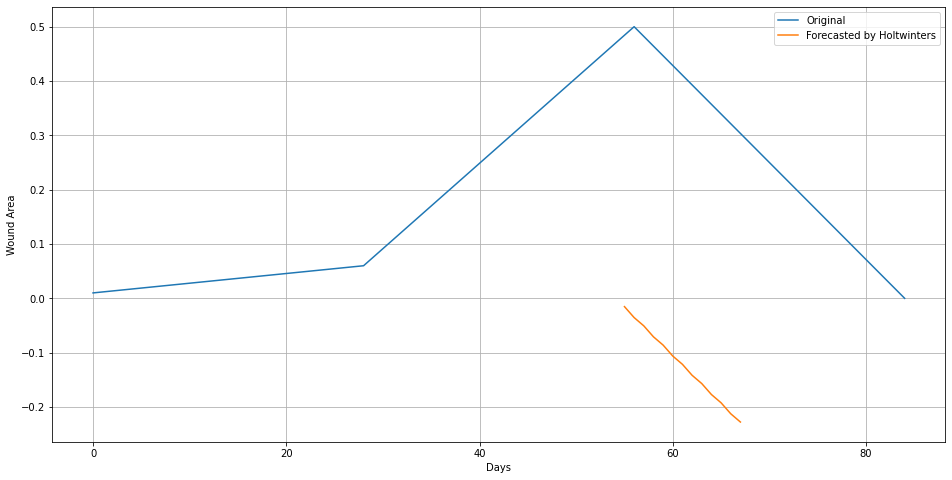

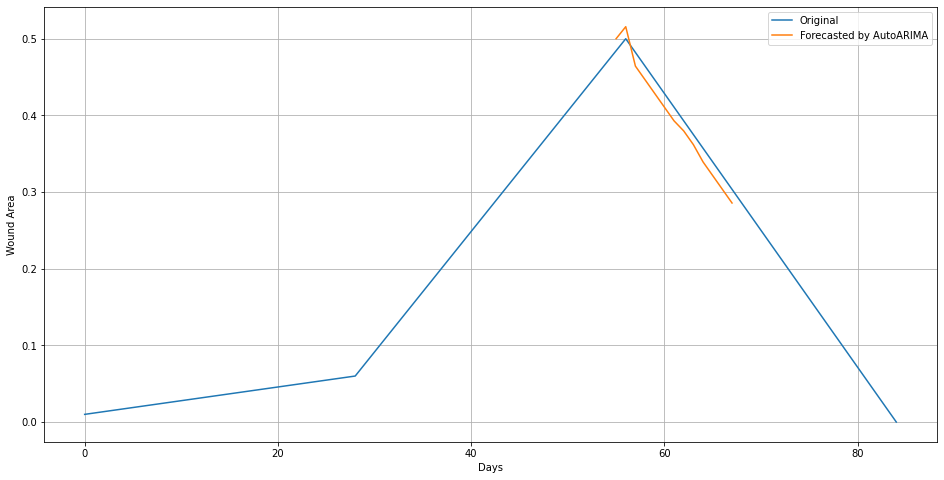

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Initial log joint probability = -82.7443
Iteration  1. Log joint probability =    16.3959. Improved by 99.1402.
Iteration  2. Log joint probability =    26.5435. Improved by 10.1476.
Iteration  3. Log joint probability =    59.2008. Improved by 32.6573.
Iteration  4. Log joint probability =    59.4371. Improved by 0.236363.
Iteration  5. Log joint probability =    59.9668. Improved by 0.529718.
Iteration  6. Log joint probability =    60.4375. Improved by 0.470628.
Iteration  7. Log joint probability =    60.6749. Improved by 0.237476.
Iteration  8. Log joint probability =    60.7537. Improved by 0.0787329.
Iteration  9. Log joint probability =    63.1454. Improved by 2.39172.
Iteration 10. Log joint probability =    63.1868. Improved by 0.0414334.
Iteration 11. Log joint probability =    63.2743. Improved by 0.0875244.
Iteration 12. Log joint probability =    63.2964. Improved by 0.0220379.
Iteration 13. Log joint probability =    67.6212. Improved by 4.32482.
Iteration 14. Log joint

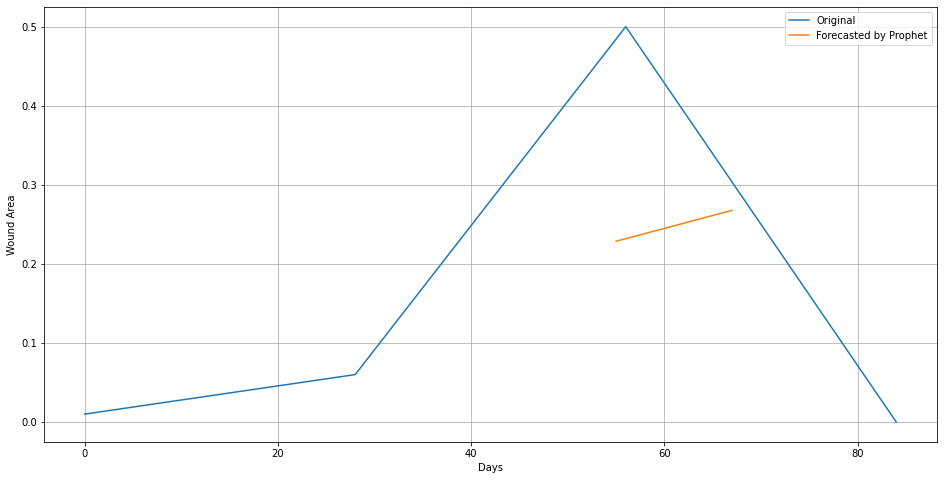

Total number of visit days after interpolation 85
3/3 [==============================] - 0s 845us/step


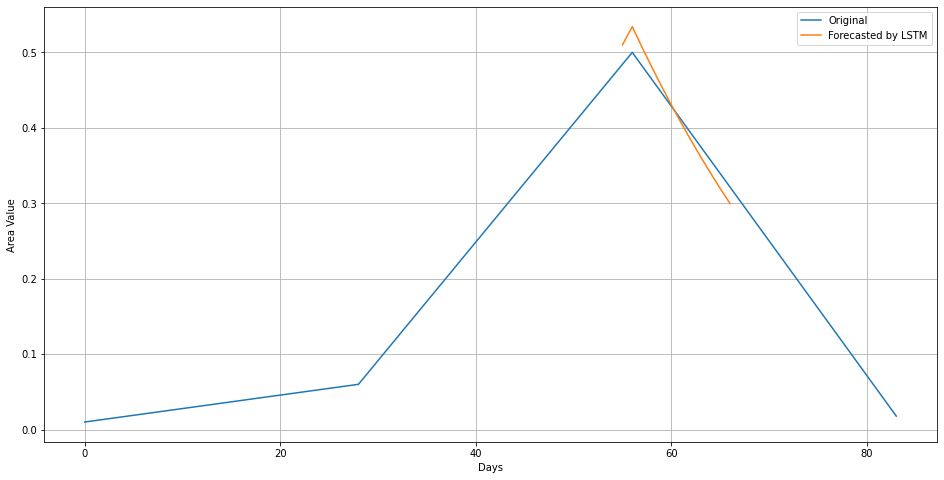

Total number of visit days after interpolation 85
1/1 [==============================] - 1s 573ms/step
test_dates shape: (12,)
predicted_values_test_inverse shape: (12, 1)


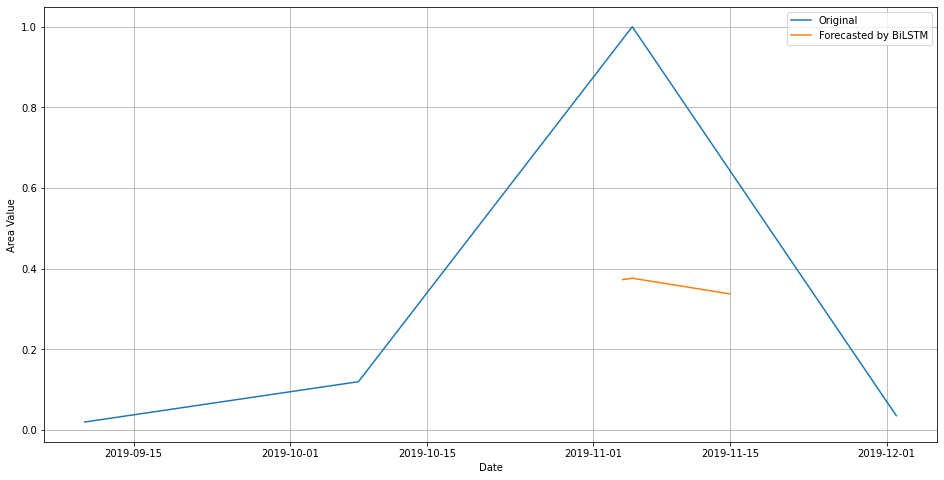

Done 0.09384636010189033 %
Wound: 15
66
106


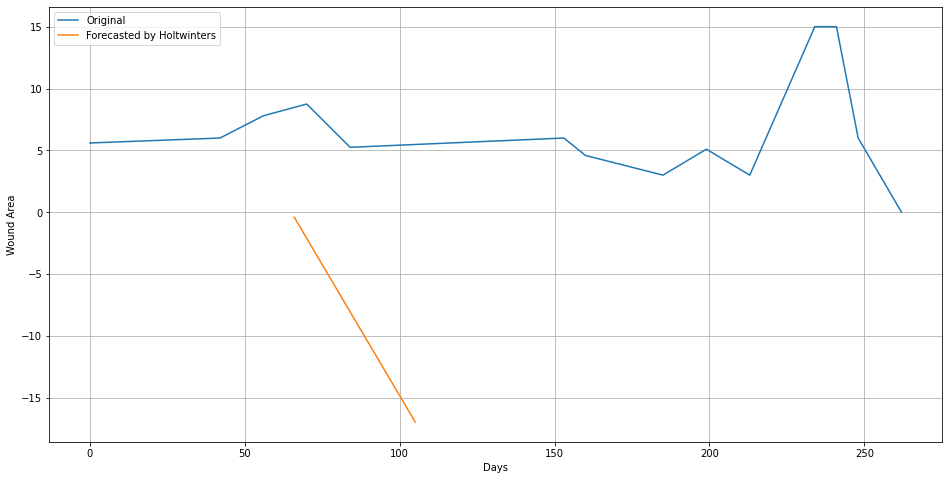

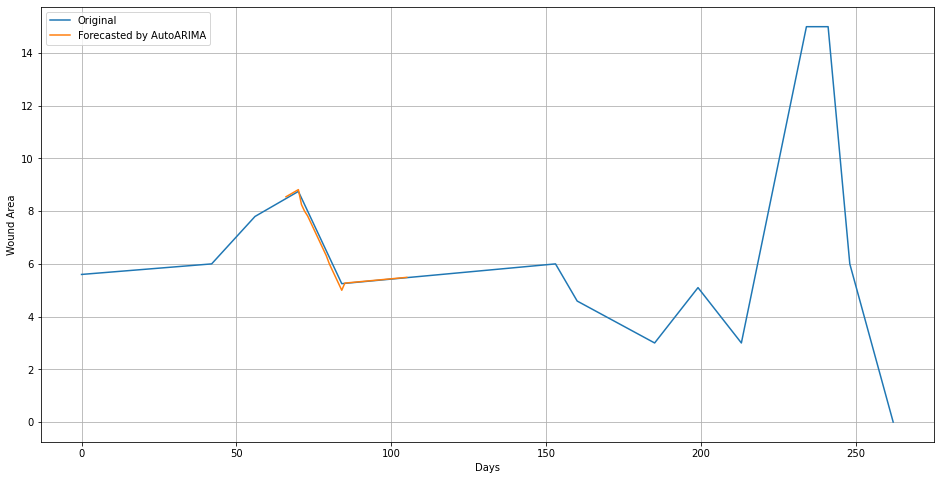

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -13.9819
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         331.6    0.00149264       91.9269      0.2697           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       331.868   2.67923e-07       89.5903           1           1      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     210       331.868   8.32547e-09       75.9497       0.548       0.548      264   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


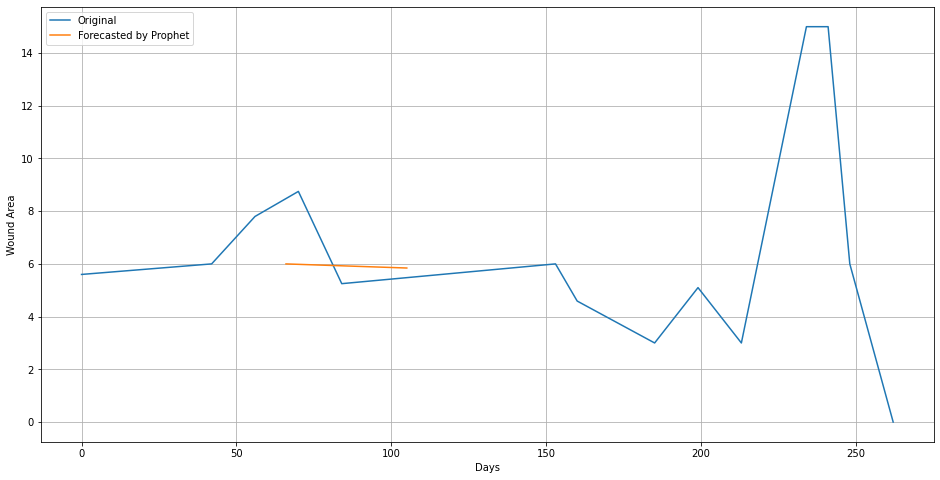

Total number of visit days after interpolation 263
7/7 [==============================] - 0s 682us/step


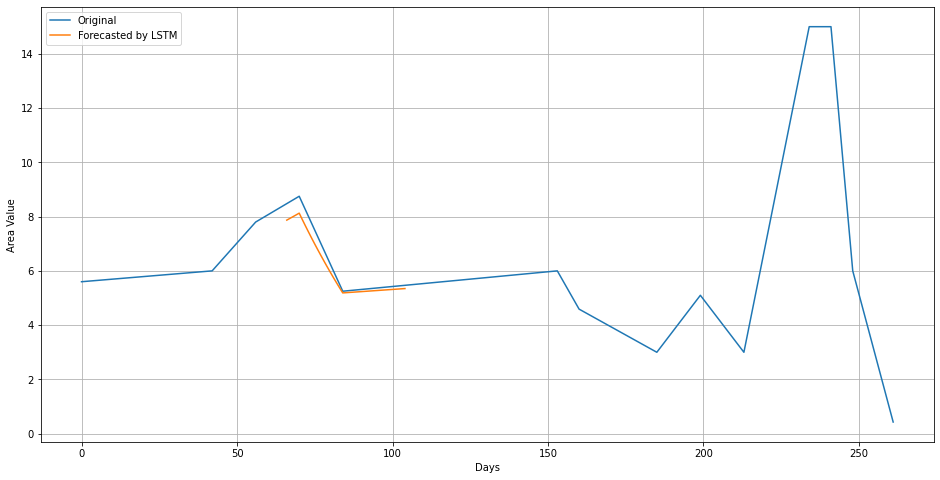

Total number of visit days after interpolation 263
2/2 [==============================] - 0s 2ms/step
test_dates shape: (39,)
predicted_values_test_inverse shape: (39, 1)


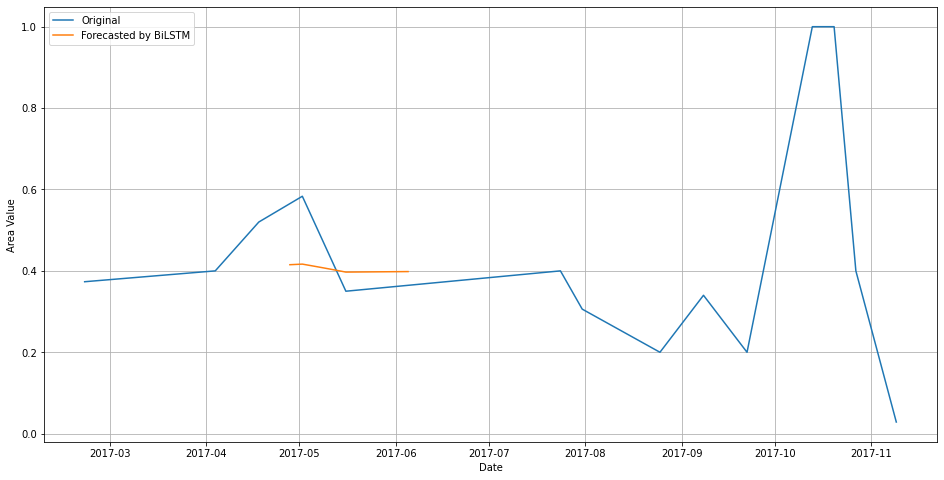

Done 0.10054967153773965 %
Wound: 16
10
16


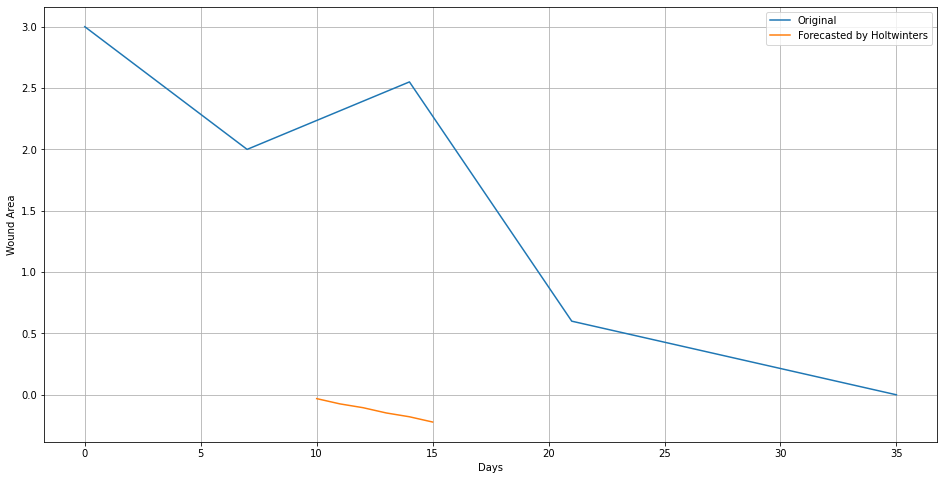

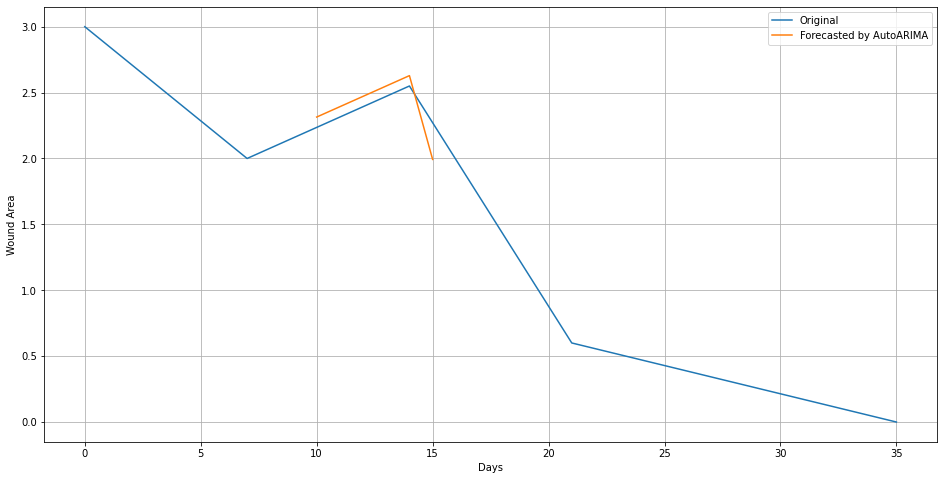

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Initial log joint probability = -28.1757
Iteration  1. Log joint probability =    26.2758. Improved by 54.4515.
Iteration  2. Log joint probability =     53.764. Improved by 27.4883.
Iteration  3. Log joint probability =    57.4878. Improved by 3.7238.
Iteration  4. Log joint probability =    57.7712. Improved by 0.283395.
Iteration  5. Log joint probability =    58.0614. Improved by 0.290202.
Iteration  6. Log joint probability =    58.3456. Improved by 0.284194.
Iteration  7. Log joint probability =    58.5766. Improved by 0.231017.
Iteration  8. Log joint probability =    58.6246. Improved by 0.0479496.
Iteration  9. Log joint probability =    58.7047. Improved by 0.0801075.
Iteration 10. Log joint probability =    58.7354. Improved by 0.0306938.
Iteration 11. Log joint probability =    58.9423. Improved by 0.206878.
Iteration 12. Log joint probability =    58.9681. Improved by 0.0258484.
Iteration 13. Log joint probability =    59.2617. Improved by 0.293554.
Iteration 14. Log join

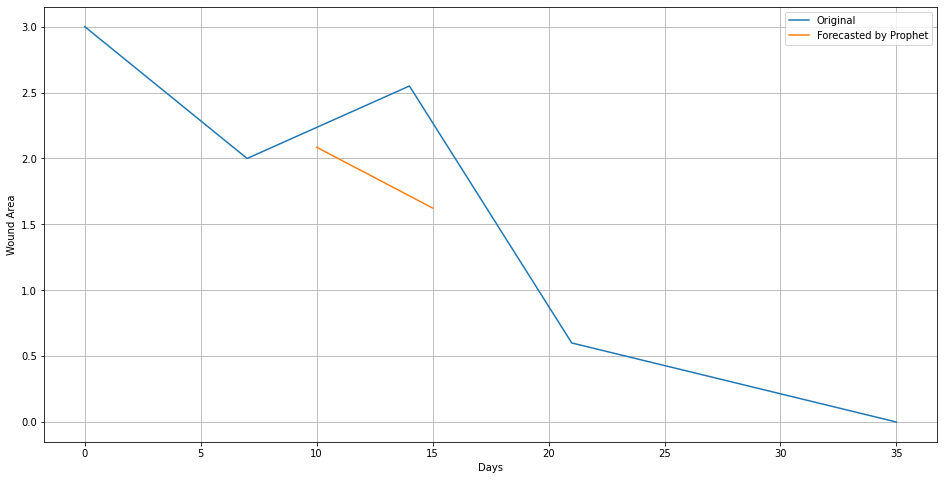

Total number of visit days after interpolation 36
1/1 [==============================] - 0s 9ms/step


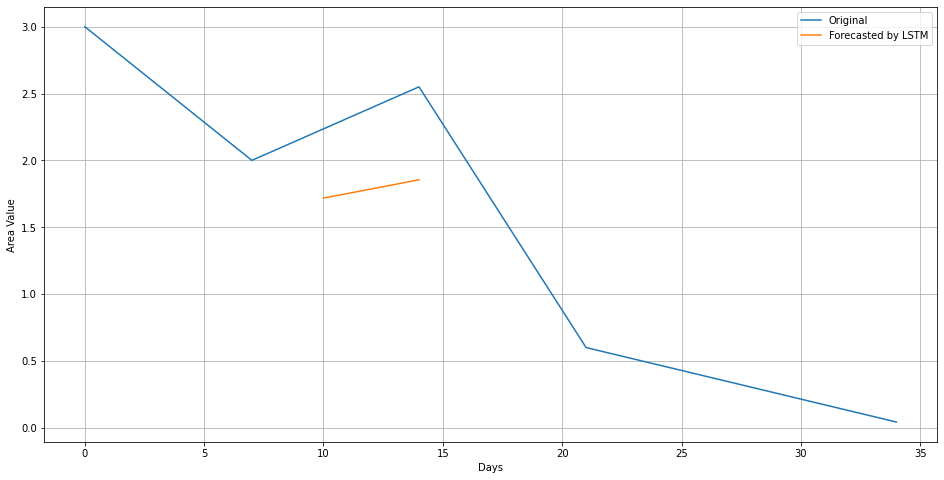

Total number of visit days after interpolation 36
1/1 [==============================] - 0s 220ms/step
test_dates shape: (5,)
predicted_values_test_inverse shape: (5, 1)


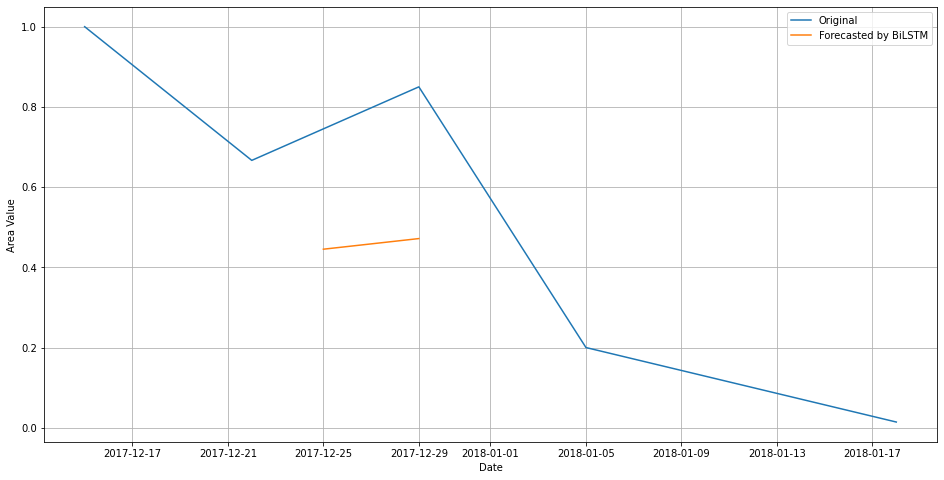

Done 0.10725298297358896 %
Wound: 17
20
32


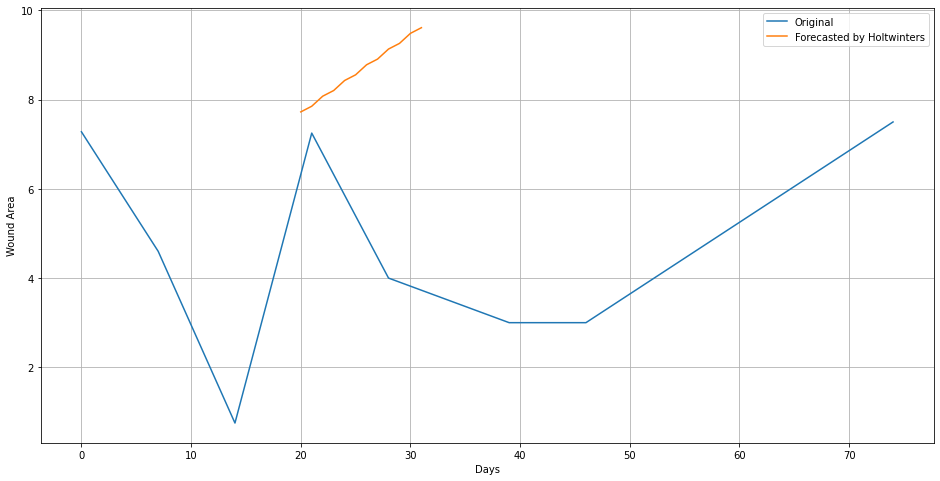

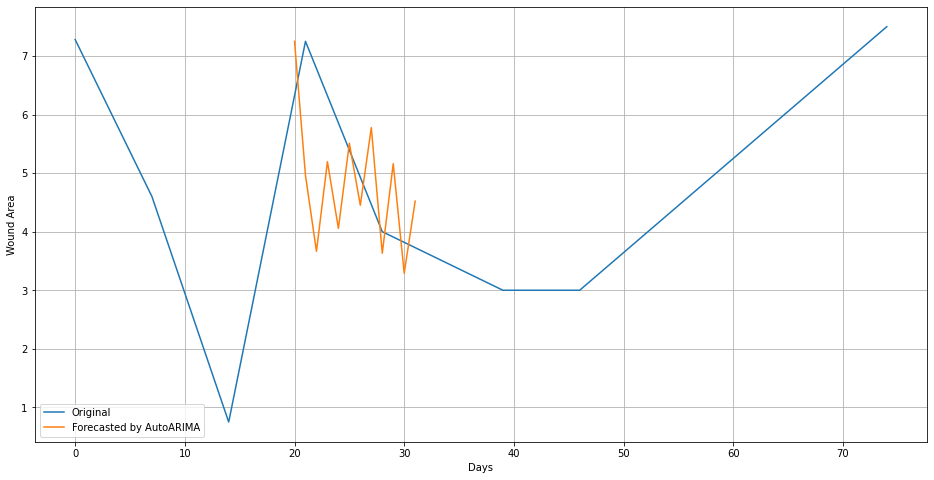

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Initial log joint probability = -70.7986
Iteration  1. Log joint probability =    43.7549. Improved by 114.554.
Iteration  2. Log joint probability =    75.6281. Improved by 31.8732.
Iteration  3. Log joint probability =    79.1552. Improved by 3.52711.
Iteration  4. Log joint probability =    80.1301. Improved by 0.974826.
Iteration  5. Log joint probability =     80.131. Improved by 0.000974172.
Iteration  6. Log joint probability =    80.1364. Improved by 0.00536391.
Iteration  7. Log joint probability =    80.1426. Improved by 0.00621332.
Iteration  8. Log joint probability =    80.1652. Improved by 0.0225643.
Iteration  9. Log joint probability =     80.189. Improved by 0.0238473.
Iteration 10. Log joint probability =    80.4871. Improved by 0.298108.
Iteration 11. Log joint probability =    80.5165. Improved by 0.0293972.
Iteration 12. Log joint probability =    80.5194. Improved by 0.00282572.
Iteration 13. Log joint probability =    80.5612. Improved by 0.0418739.
Iteration 14

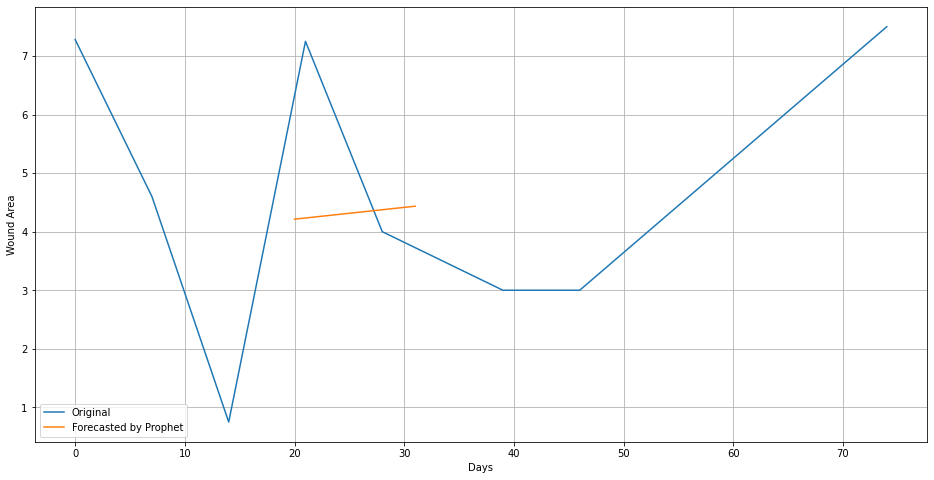

Total number of visit days after interpolation 75
2/2 [==============================] - 0s 1ms/step


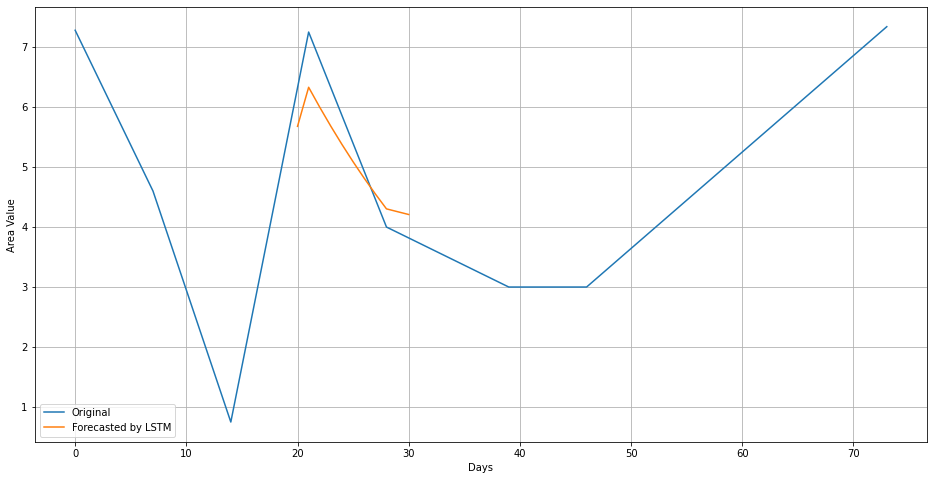

Total number of visit days after interpolation 75
1/1 [==============================] - 0s 222ms/step
test_dates shape: (11,)
predicted_values_test_inverse shape: (11, 1)


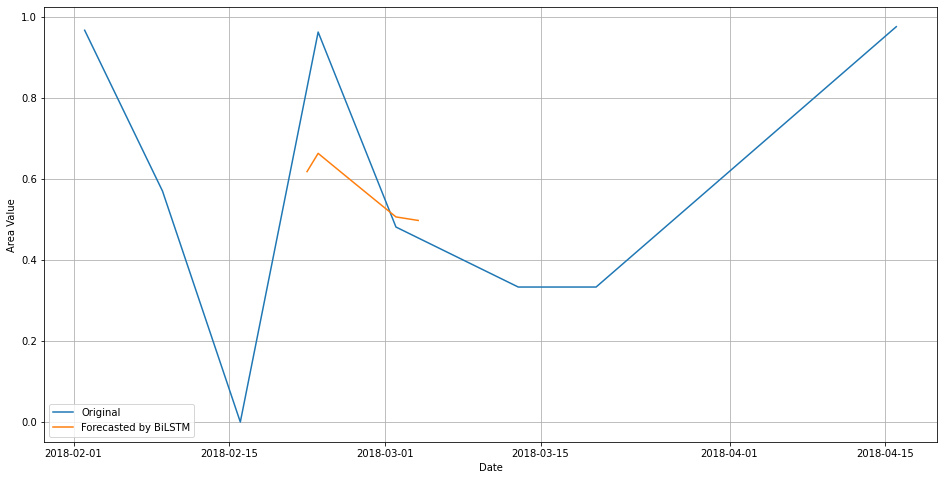

Done 0.11395629440943825 %
Wound: 18
6
9


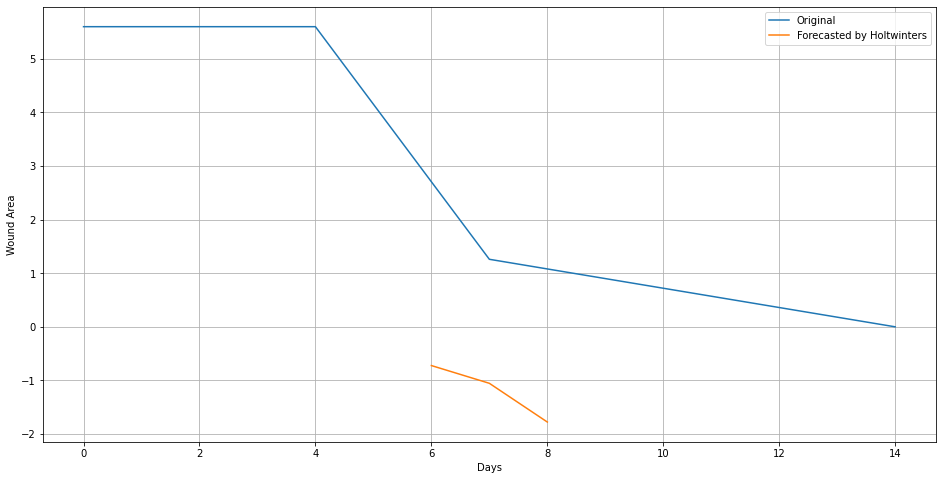

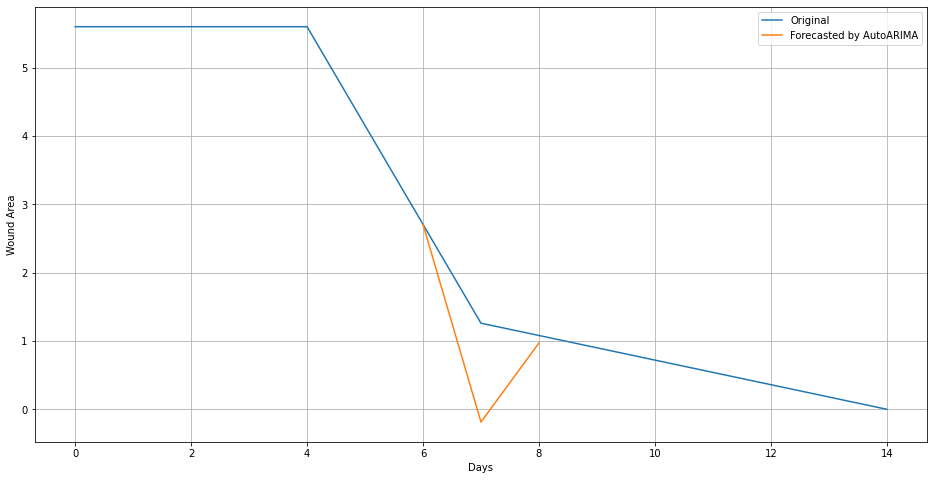

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 11.



Initial log joint probability = -41.0728
Iteration  1. Log joint probability =    13.5635. Improved by 54.6364.
Iteration  2. Log joint probability =    14.6355. Improved by 1.07194.
Iteration  3. Log joint probability =     15.817. Improved by 1.18153.
Iteration  4. Log joint probability =    16.4466. Improved by 0.629639.
Iteration  5. Log joint probability =    16.5428. Improved by 0.0961399.
Iteration  6. Log joint probability =    16.5831. Improved by 0.040317.
Iteration  7. Log joint probability =    16.6944. Improved by 0.111314.
Iteration  8. Log joint probability =    16.7991. Improved by 0.104681.
Iteration  9. Log joint probability =    16.8811. Improved by 0.0819887.
Iteration 10. Log joint probability =    16.9443. Improved by 0.0631851.
Iteration 11. Log joint probability =    16.9571. Improved by 0.0128854.
Iteration 12. Log joint probability =    16.9729. Improved by 0.01573.
Iteration 13. Log joint probability =    16.9944. Improved by 0.0215198.
Iteration 14. Log joi

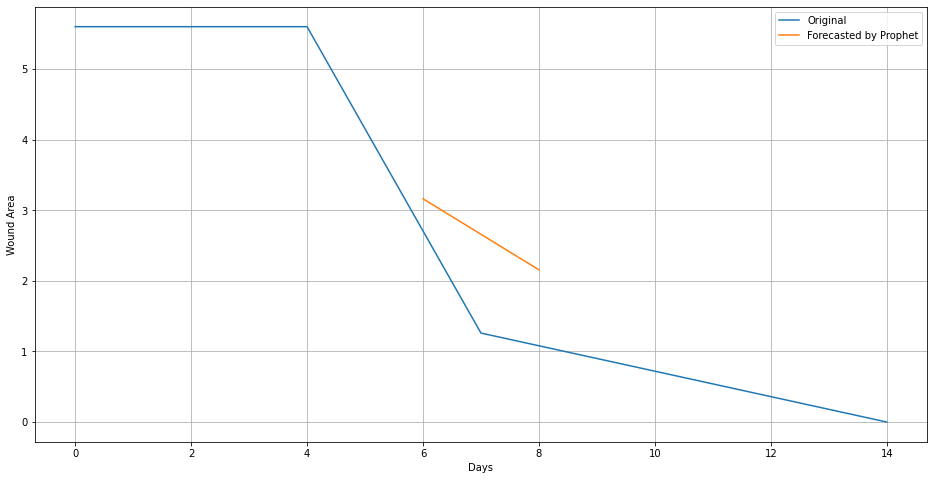

Total number of visit days after interpolation 15
1/1 [==============================] - 0s 8ms/step


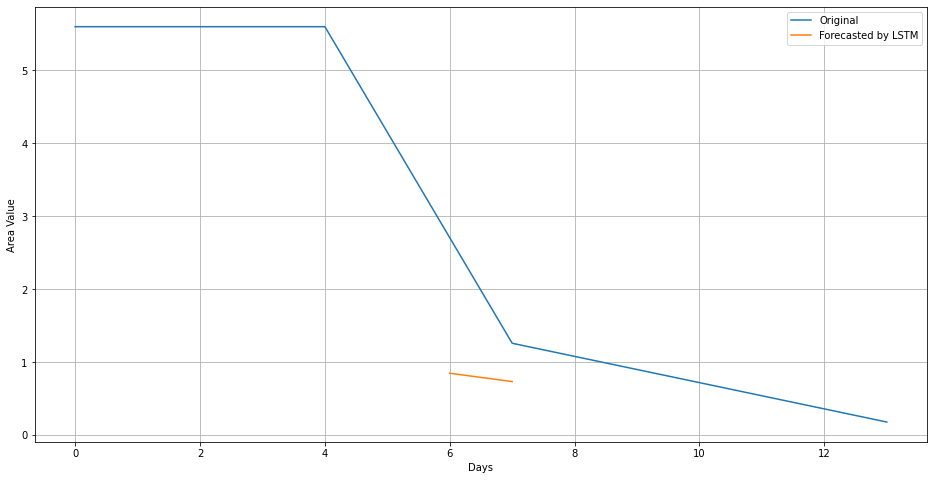

Total number of visit days after interpolation 15
1/1 [==============================] - 0s 218ms/step
test_dates shape: (2,)
predicted_values_test_inverse shape: (2, 1)


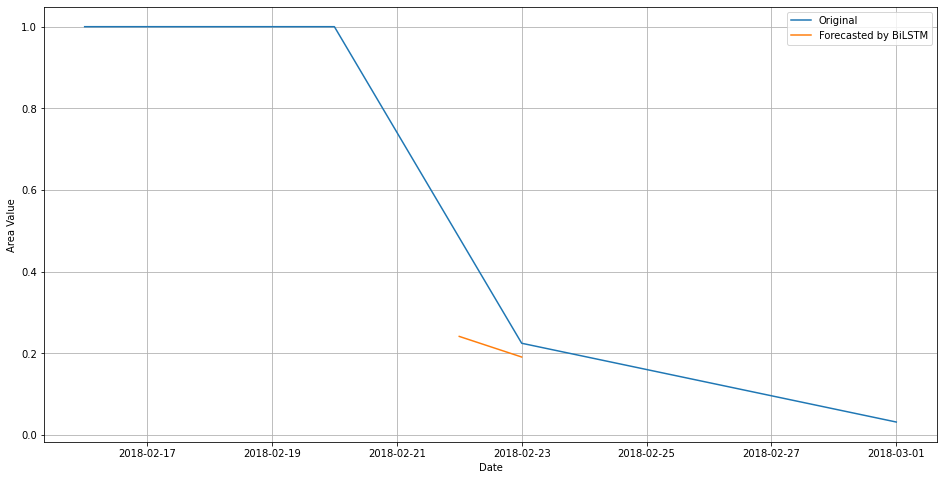

Done 0.12065960584528757 %
Wound: 19
1
10


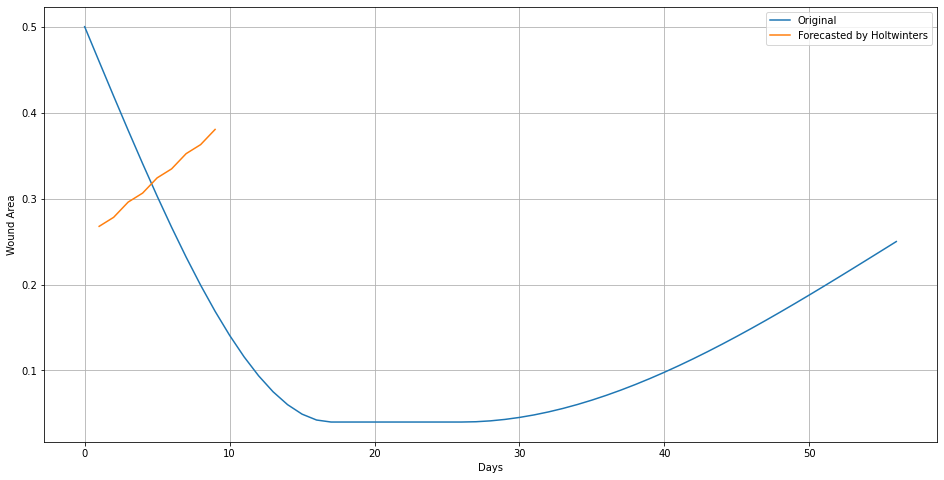

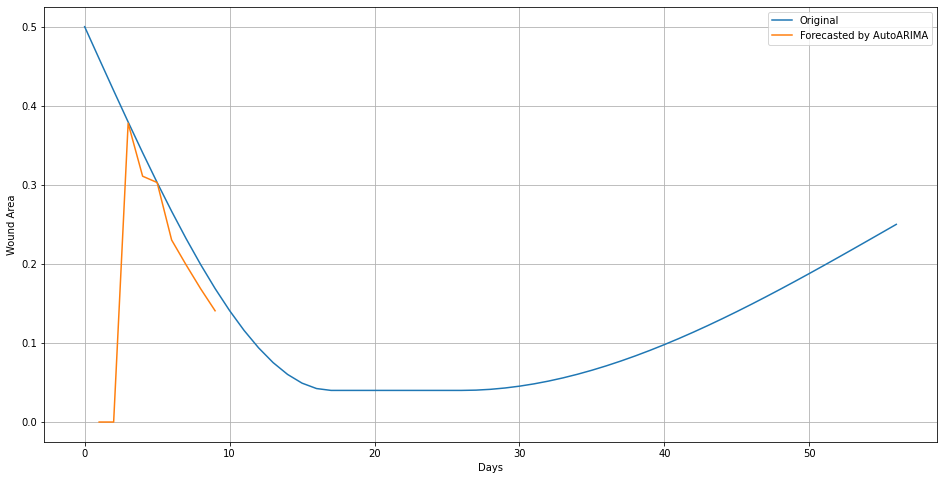

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Initial log joint probability = -55.2154
Iteration  1. Log joint probability =    25.0918. Improved by 80.3072.
Iteration  2. Log joint probability =    45.2795. Improved by 20.1878.
Iteration  3. Log joint probability =    54.9821. Improved by 9.70261.
Iteration  4. Log joint probability =    56.7281. Improved by 1.746.
Iteration  5. Log joint probability =     56.744. Improved by 0.0158853.
Iteration  6. Log joint probability =    56.7574. Improved by 0.0133373.
Iteration  7. Log joint probability =    56.8893. Improved by 0.131963.
Iteration  8. Log joint probability =    57.0108. Improved by 0.121494.
Iteration  9. Log joint probability =    57.0512. Improved by 0.0403389.
Iteration 10. Log joint probability =    57.2472. Improved by 0.195999.
Iteration 11. Log joint probability =    57.3812. Improved by 0.134024.
Iteration 12. Log joint probability =    57.4379. Improved by 0.0567115.
Iteration 13. Log joint probability =    57.4498. Improved by 0.0119021.
Iteration 14. Log joint

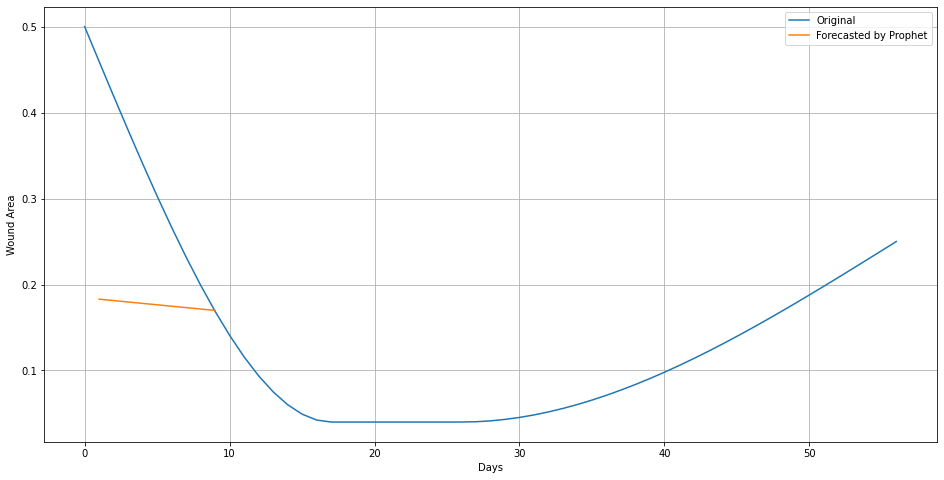

Total number of visit days after interpolation 57
2/2 [==============================] - 0s 1ms/step


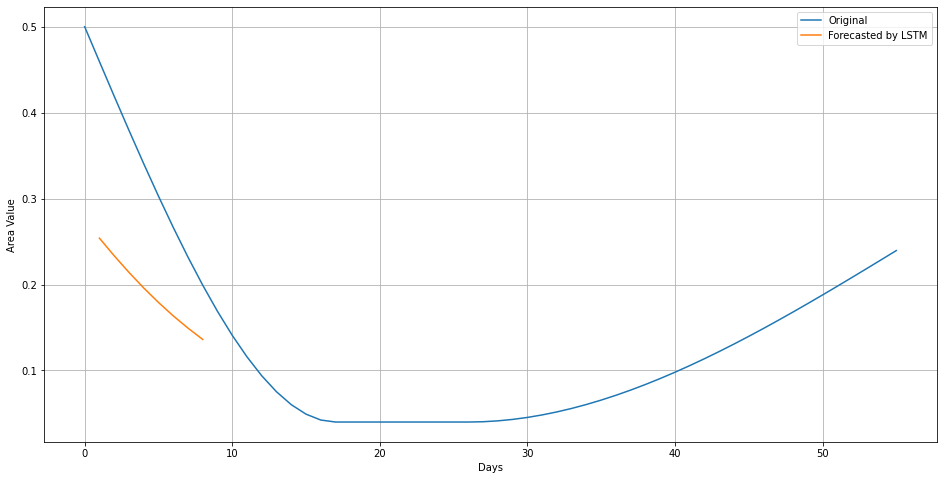

Total number of visit days after interpolation 57
1/1 [==============================] - 0s 221ms/step
test_dates shape: (8,)
predicted_values_test_inverse shape: (8, 1)


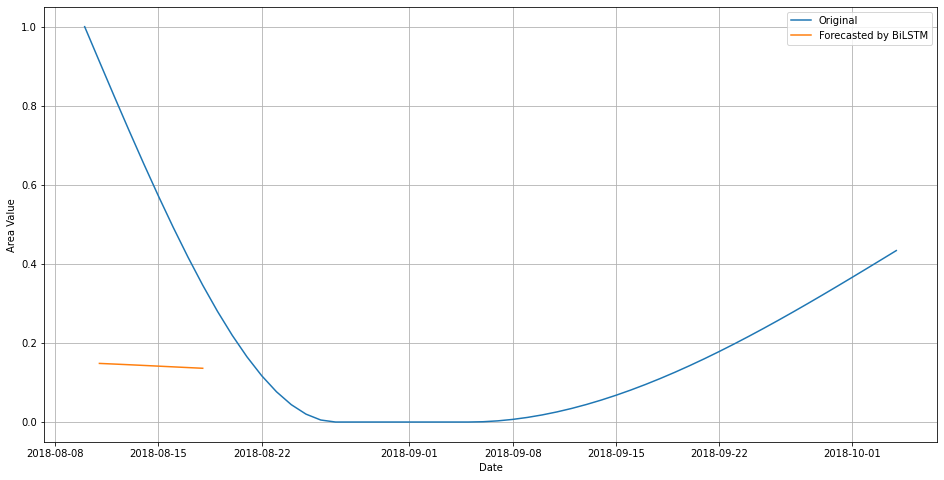

Done 0.12736291728113688 %
Wound: 20
151
199


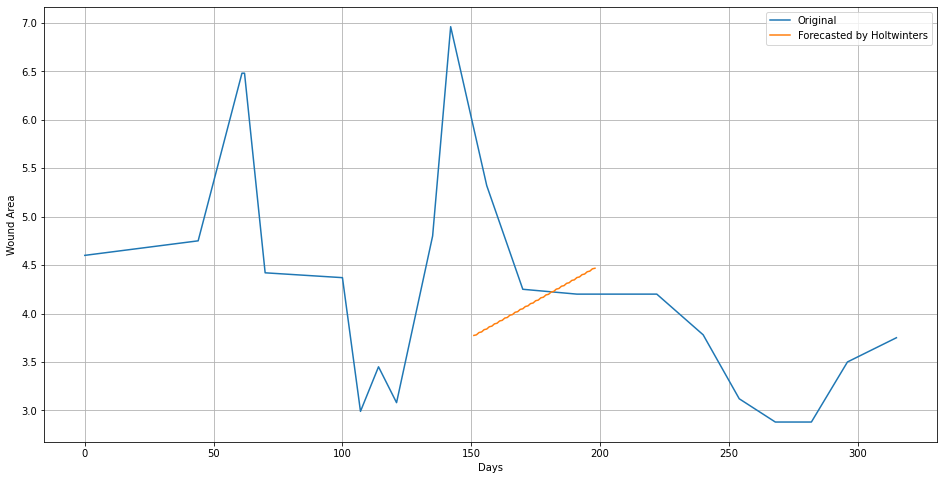

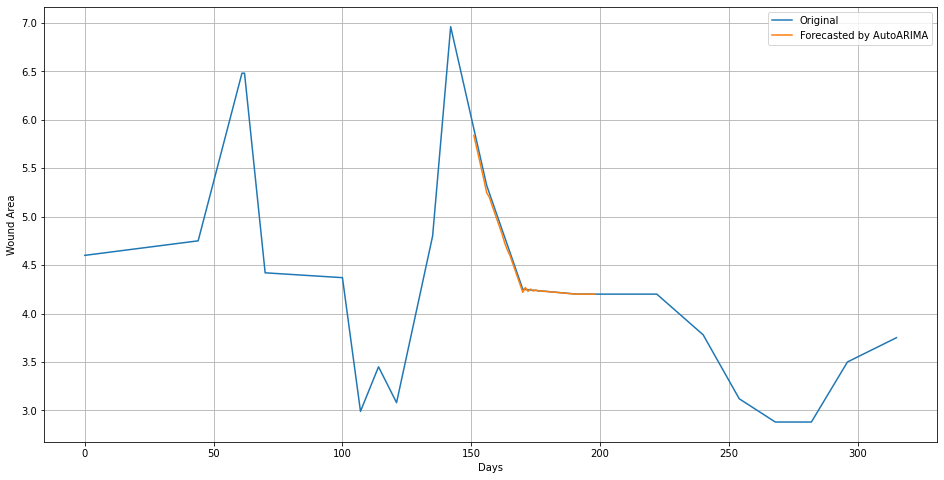

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.96383
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      74       567.539   0.000444833       78.5738   5.414e-06       0.001      121  LS failed, Hessian reset 
      99       567.647   8.74712e-05       76.1201       1.751      0.1751      157   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     182       567.667   0.000107679       85.1268   1.105e-06       0.001      324  LS failed, Hessian reset 
     199       567.672   8.19468e-07       74.8093      0.4855      0.4855      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     243       567.673   3.32177e-08       85.8504      0.7938      0.7938      405   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


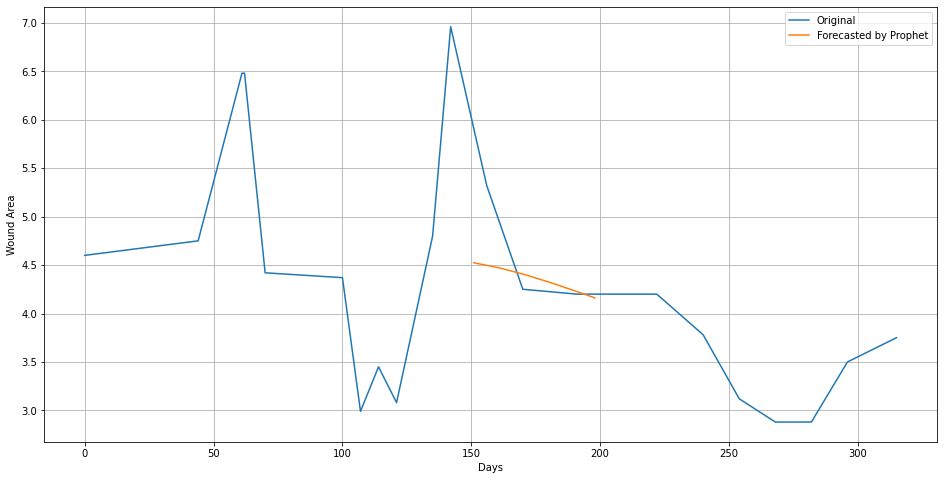

Total number of visit days after interpolation 316
9/9 [==============================] - 0s 684us/step


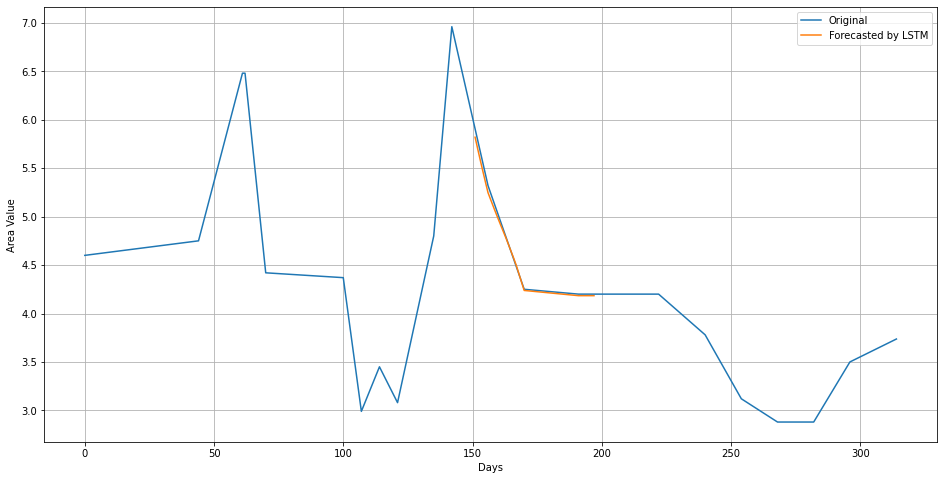

Total number of visit days after interpolation 316
2/2 [==============================] - 0s 2ms/step
test_dates shape: (47,)
predicted_values_test_inverse shape: (47, 1)


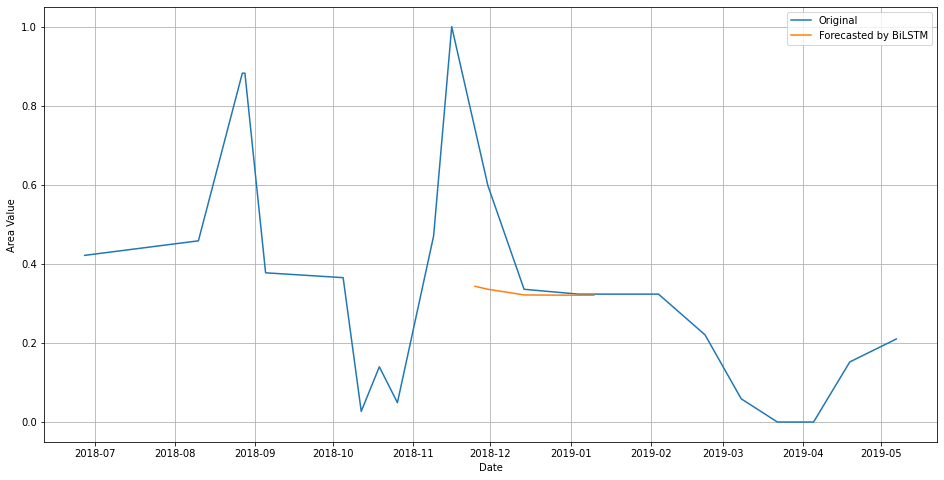

Done 0.1340662287169862 %
Wound: 21
58
76


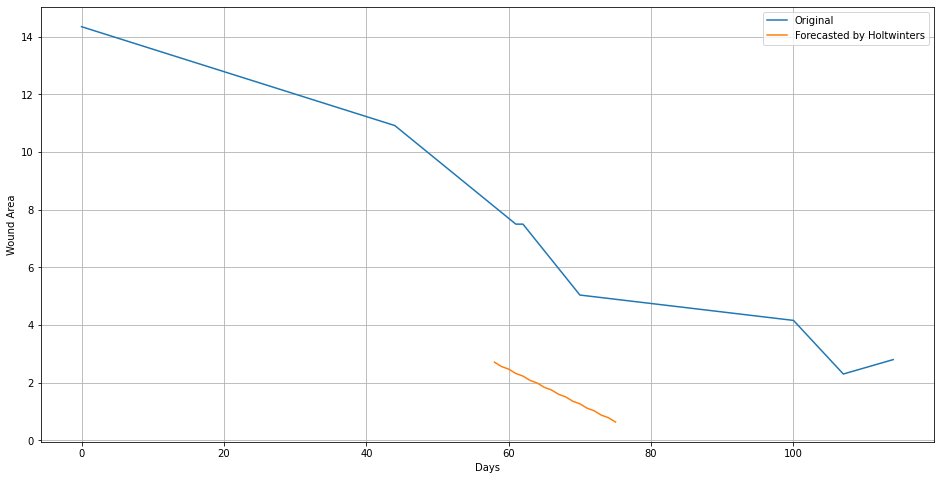

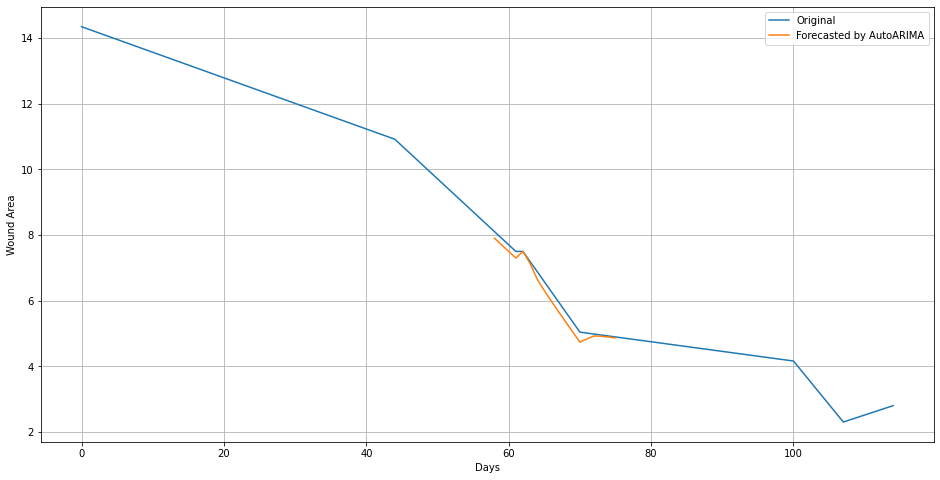

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.26496
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       377.657     0.0101474       101.642           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132       380.373   0.000118438       130.623   1.135e-06       0.001      211  LS failed, Hessian reset 
     191       383.096   0.000338217       213.127     4.7e-06       0.001      331  LS failed, Hessian reset 
     199       383.173   7.85453e-05       67.9256      0.1277      0.1277      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     209       383.265   8.06676e-05       86.8049   5.205e-07       0.001      390  LS failed, Hessian reset 
     299       385.494     0.0012872       114.737      0.4849      0.4849      497   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

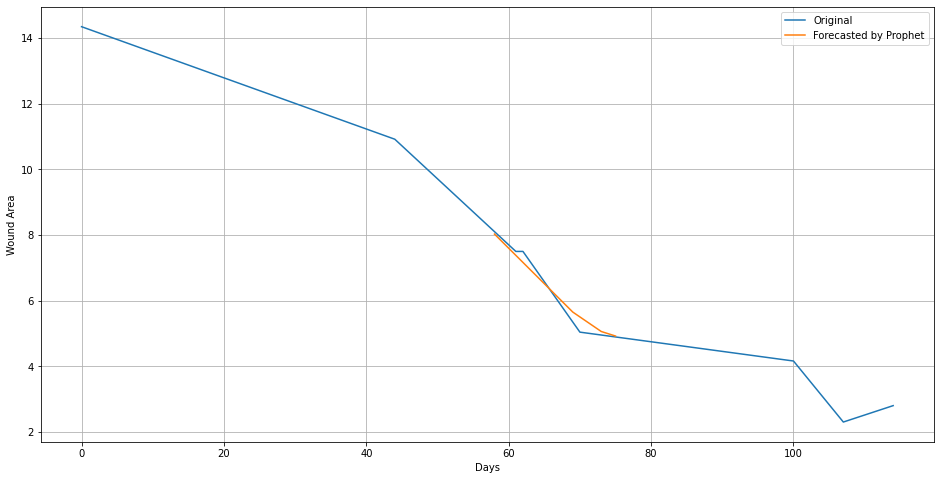

Total number of visit days after interpolation 115
3/3 [==============================] - 0s 897us/step


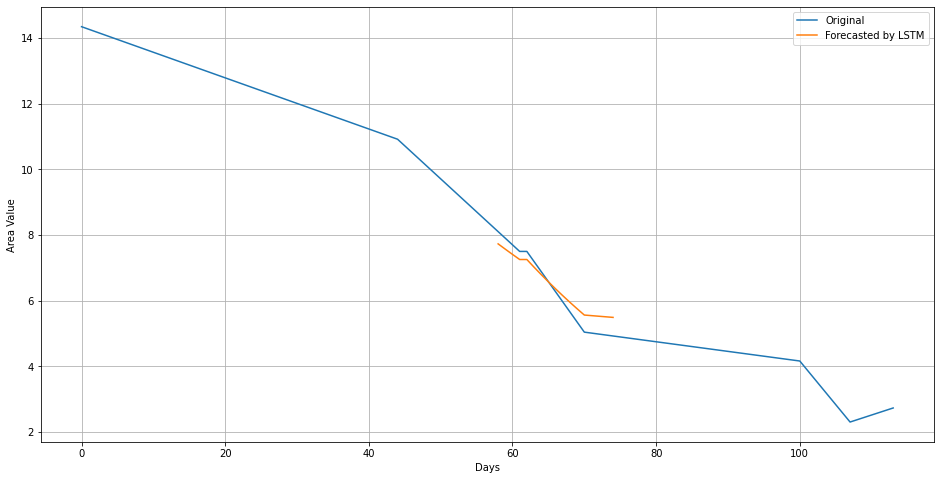

Total number of visit days after interpolation 115
1/1 [==============================] - 0s 209ms/step
test_dates shape: (17,)
predicted_values_test_inverse shape: (17, 1)


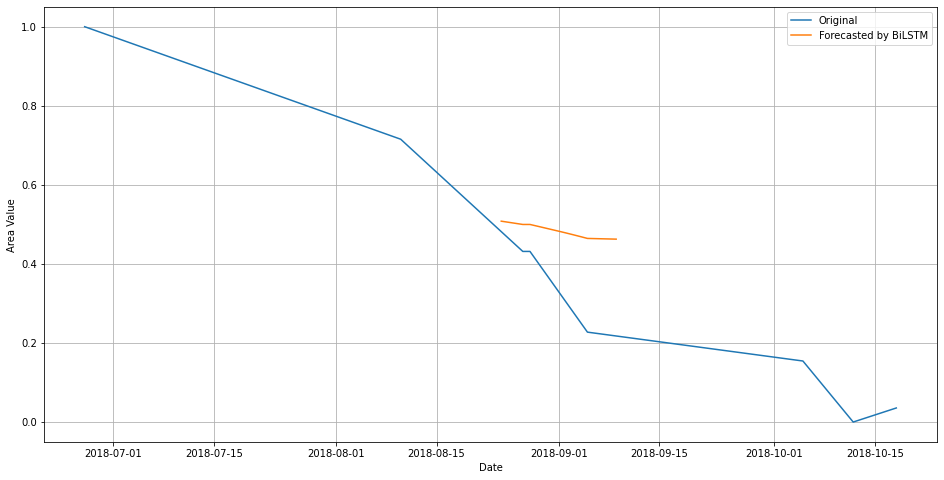

Done 0.14076954015283552 %
Wound: 22
11
20


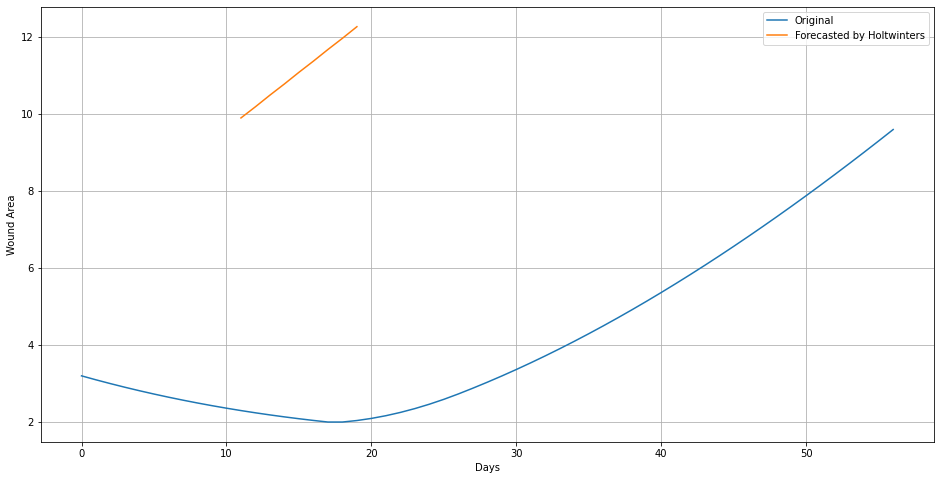

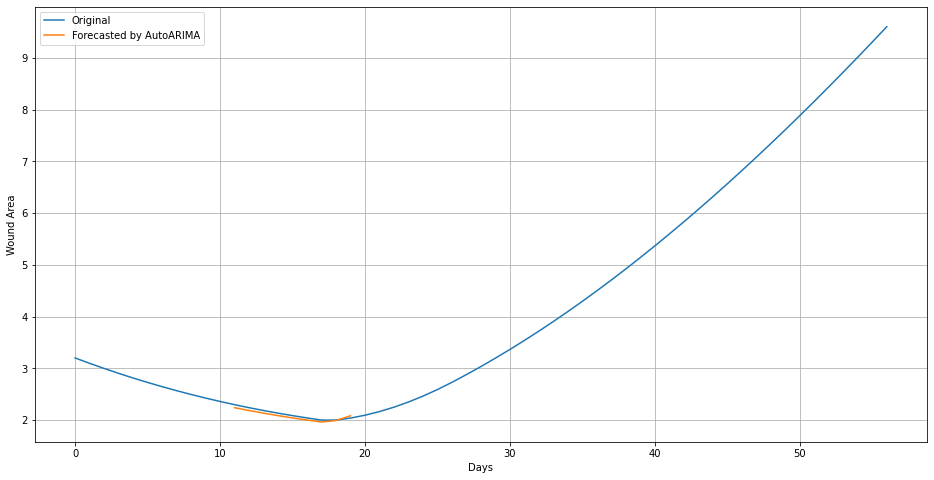

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Initial log joint probability = -48.9937
Iteration  1. Log joint probability =    42.4005. Improved by 91.3942.
Iteration  2. Log joint probability =     77.119. Improved by 34.7185.
Iteration  3. Log joint probability =    93.4237. Improved by 16.3047.
Iteration  4. Log joint probability =     95.645. Improved by 2.22131.
Iteration  5. Log joint probability =    95.7116. Improved by 0.0666325.
Iteration  6. Log joint probability =    95.7449. Improved by 0.0332972.
Iteration  7. Log joint probability =    95.7616. Improved by 0.0166482.
Iteration  8. Log joint probability =    95.8684. Improved by 0.106795.
Iteration  9. Log joint probability =     95.875. Improved by 0.00668438.
Iteration 10. Log joint probability =    95.8821. Improved by 0.00708068.
Iteration 11. Log joint probability =    95.9703. Improved by 0.0882169.
Iteration 12. Log joint probability =    96.0143. Improved by 0.0439184.
Iteration 13. Log joint probability =    96.0175. Improved by 0.00326042.
Iteration 14. L

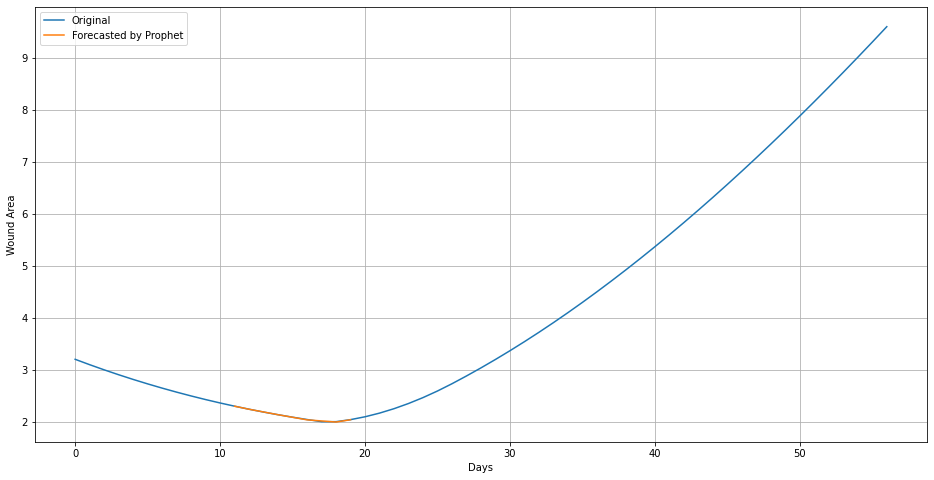

Total number of visit days after interpolation 57
2/2 [==============================] - 0s 1ms/step


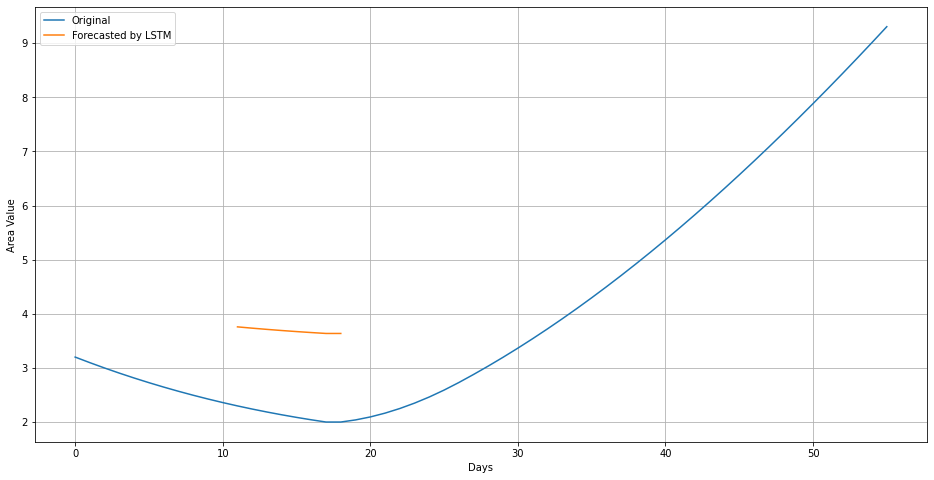

Total number of visit days after interpolation 57
1/1 [==============================] - 0s 211ms/step
test_dates shape: (8,)
predicted_values_test_inverse shape: (8, 1)


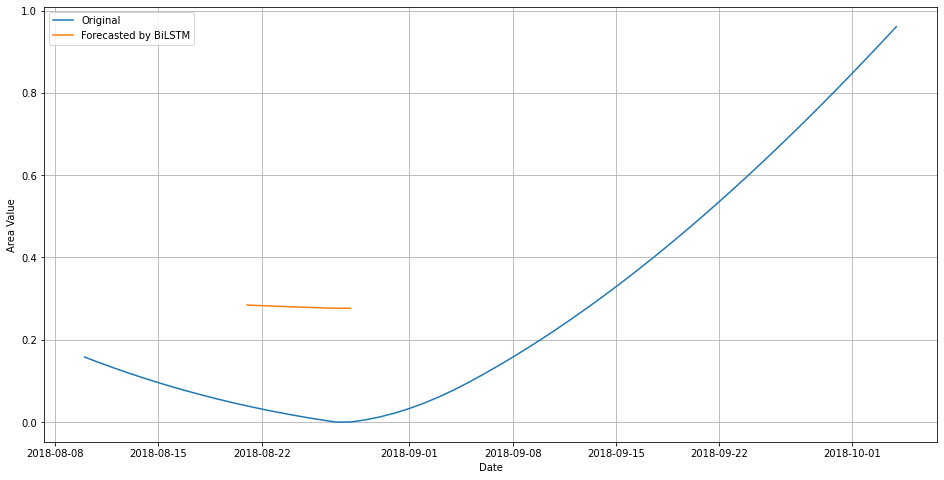

Done 0.1474728515886848 %
Wound: 23
44
53


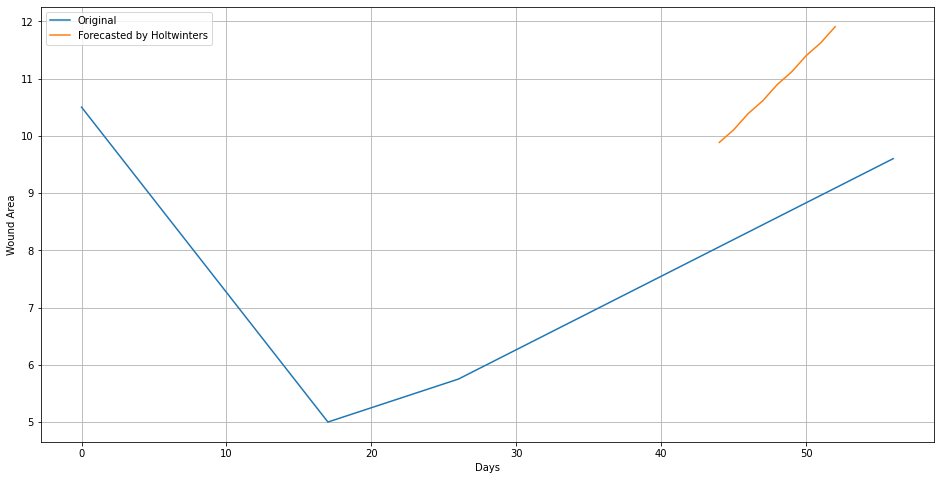

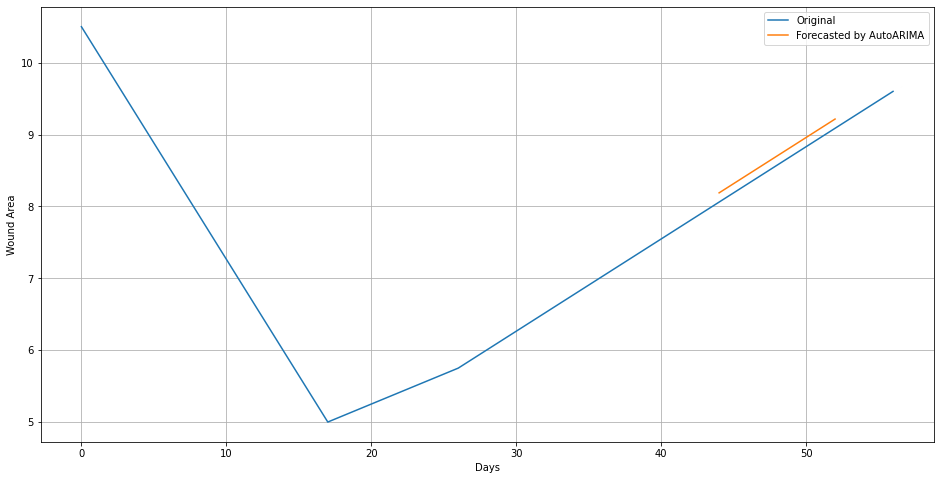

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Initial log joint probability = -49.709
Iteration  1. Log joint probability =     36.812. Improved by 86.521.
Iteration  2. Log joint probability =    66.4288. Improved by 29.6168.
Iteration  3. Log joint probability =    81.3105. Improved by 14.8816.
Iteration  4. Log joint probability =    82.4355. Improved by 1.12501.
Iteration  5. Log joint probability =    82.4627. Improved by 0.027209.
Iteration  6. Log joint probability =    82.5399. Improved by 0.0772236.
Iteration  7. Log joint probability =    82.5975. Improved by 0.0575698.
Iteration  8. Log joint probability =    82.7225. Improved by 0.124985.
Iteration  9. Log joint probability =    82.7972. Improved by 0.0747124.
Iteration 10. Log joint probability =    89.5275. Improved by 6.73036.
Iteration 11. Log joint probability =    89.7872. Improved by 0.259665.
Iteration 12. Log joint probability =    90.1586. Improved by 0.371437.
Iteration 13. Log joint probability =    90.2772. Improved by 0.118576.
Iteration 14. Log joint pr

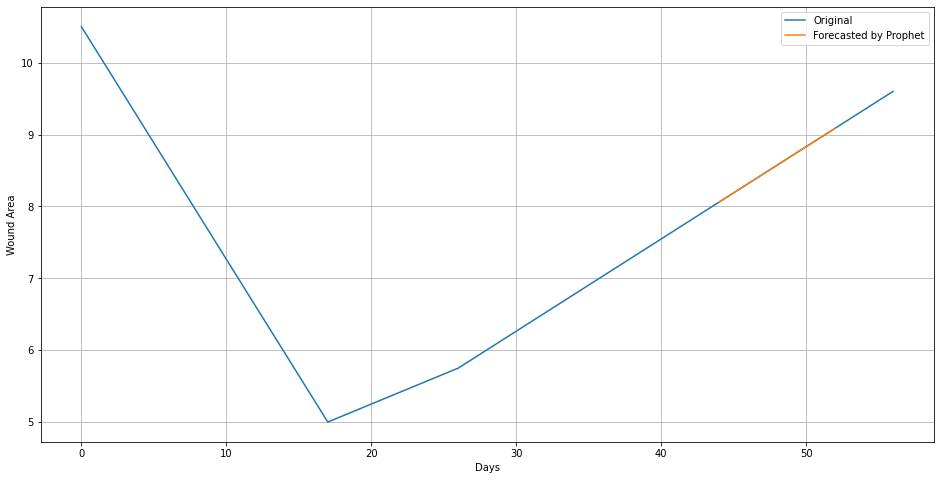

Total number of visit days after interpolation 57
2/2 [==============================] - 0s 1ms/step


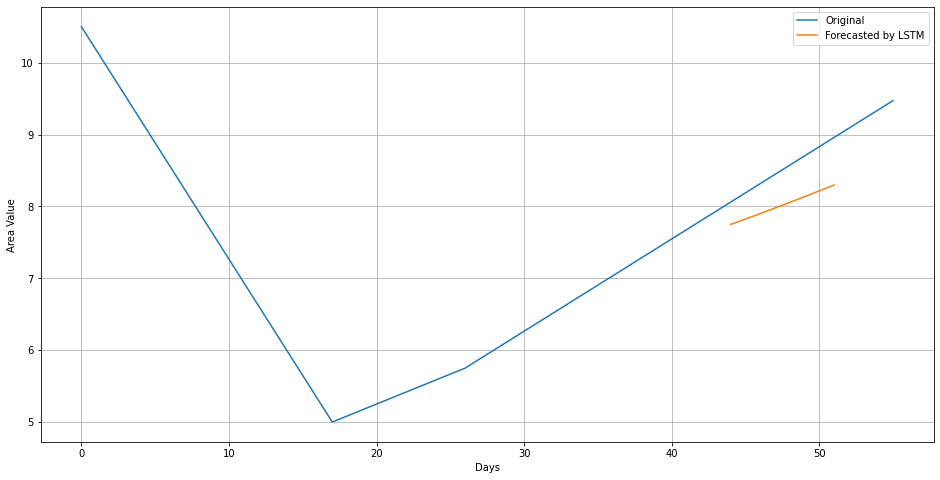

Total number of visit days after interpolation 57
1/1 [==============================] - 0s 219ms/step
test_dates shape: (8,)
predicted_values_test_inverse shape: (8, 1)


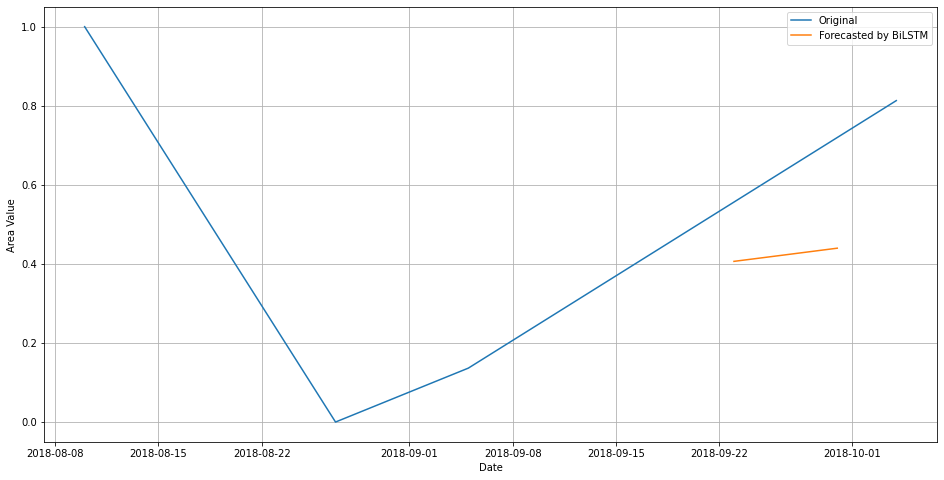

Done 0.15417616302453413 %
Wound: 24
90
112


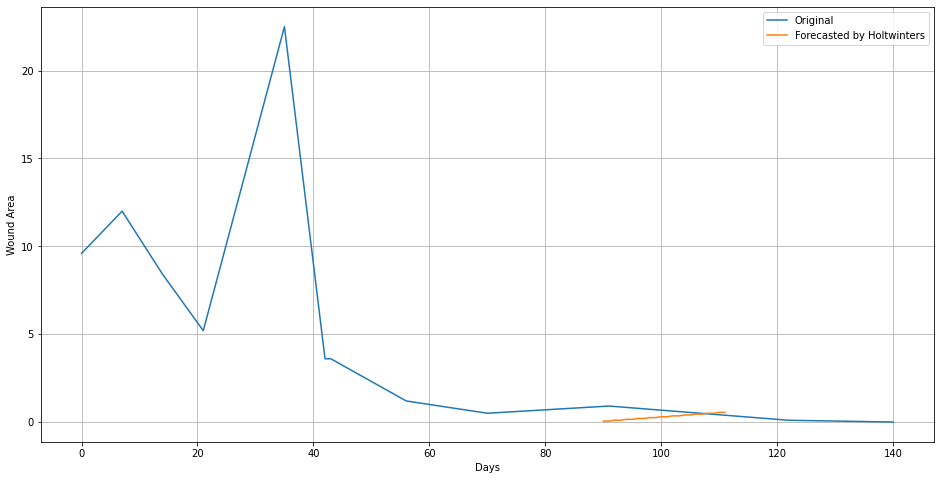

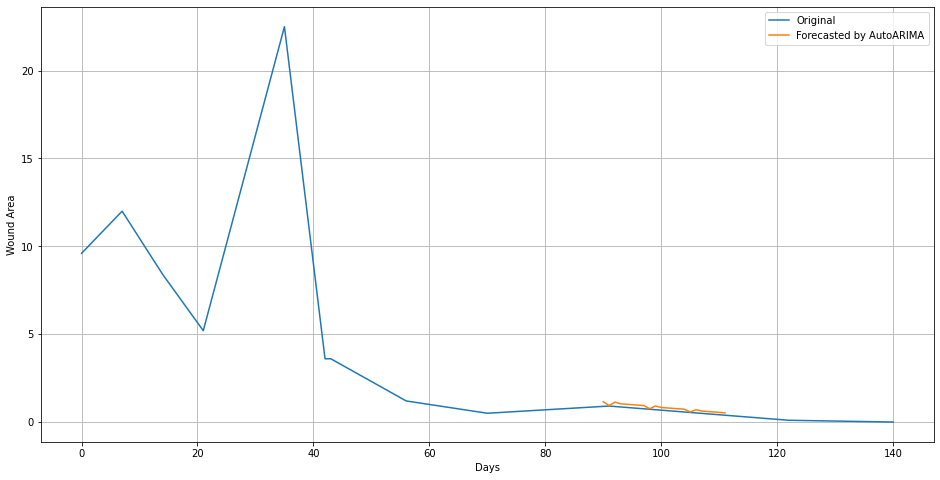

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.26284
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       182.608   0.000265804       84.5951       1.758      0.5825      142   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       182.693   1.24072e-05       77.6465           1           1      290   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     259       182.696   7.35127e-06       85.1709   9.546e-08       0.001      409  LS failed, Hessian reset 
     298       182.697   6.54765e-10       78.9182     0.02018     0.02018      464   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


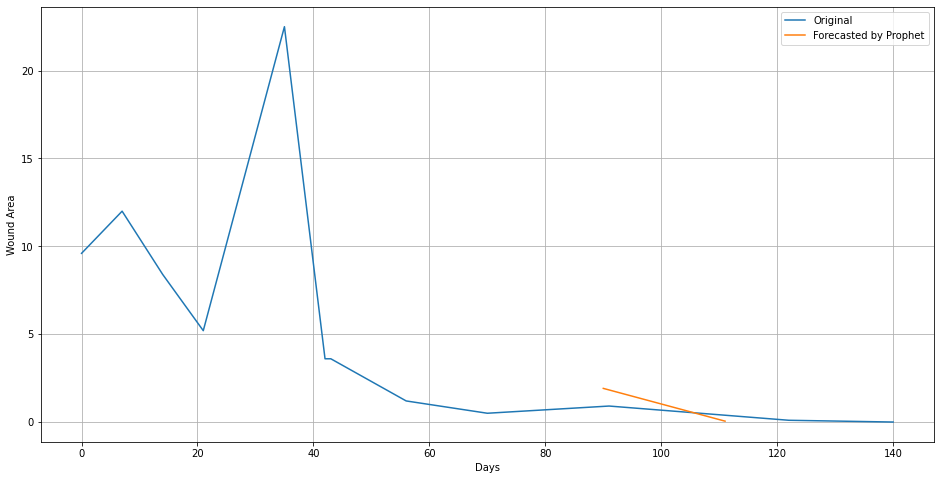

Total number of visit days after interpolation 141
4/4 [==============================] - 0s 828us/step


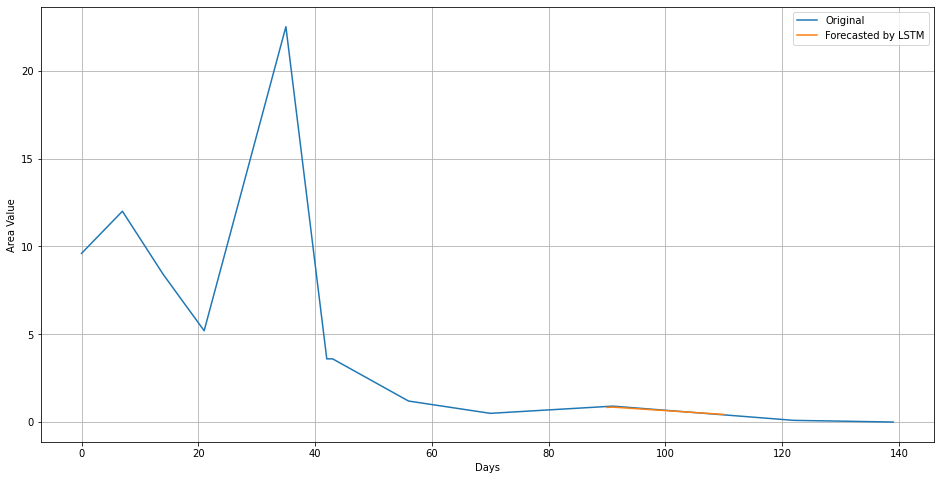

Total number of visit days after interpolation 141
1/1 [==============================] - 0s 217ms/step
test_dates shape: (21,)
predicted_values_test_inverse shape: (21, 1)


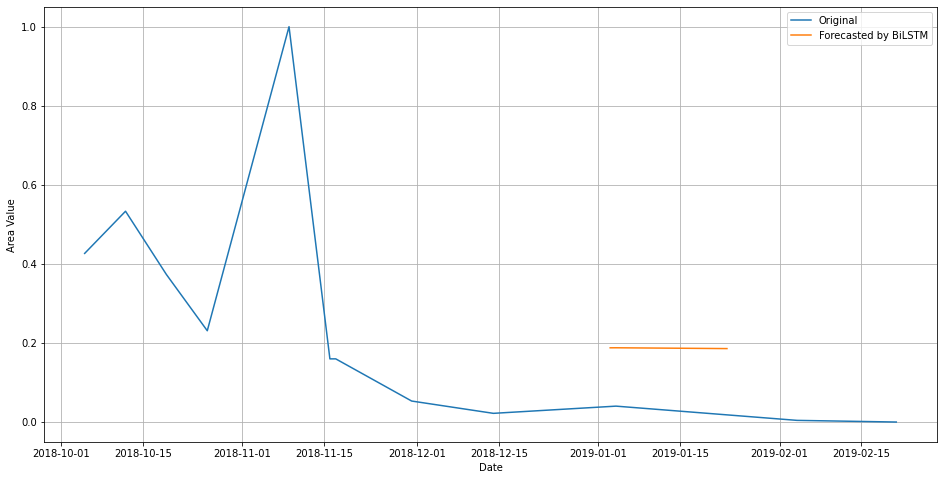

Done 0.16087947446038342 %
Wound: 25
148
176


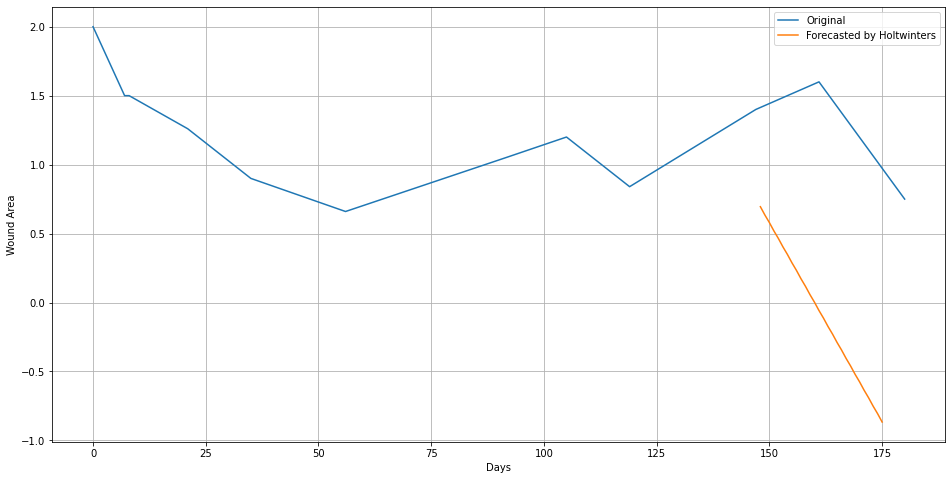

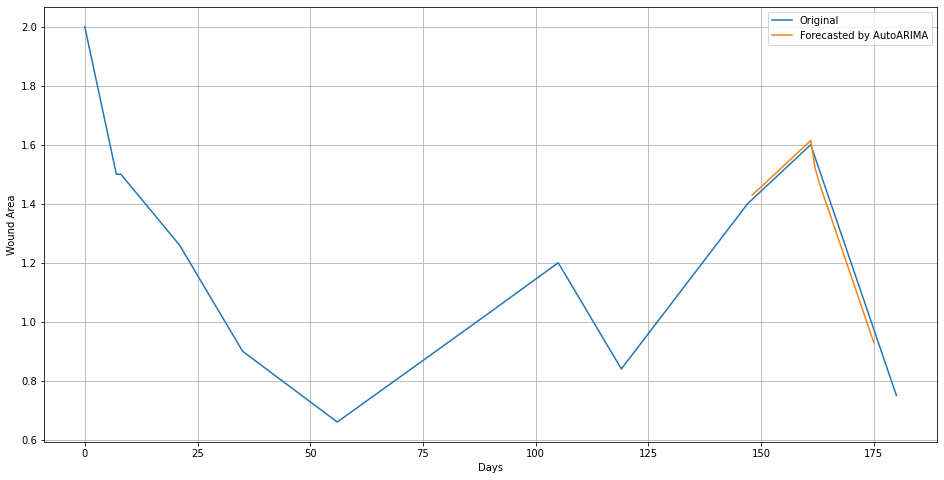

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -8.87675
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98         323.8    0.00239301       101.922   1.567e-05       0.001      170  LS failed, Hessian reset 
      99       323.876    0.00103126       82.1164           1           1      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       324.875    6.7163e-05       86.1115           1           1      298   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       325.561    0.00027964       81.7357      0.1771      0.1771      425   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     306       325.653   0.000736775       98.7716   1.191e-05       0.001      475  LS failed, Hessian reset 
     386       325.792   0.000391665        75.736   5.082e-06       0.001      615  LS failed, Hessian rese

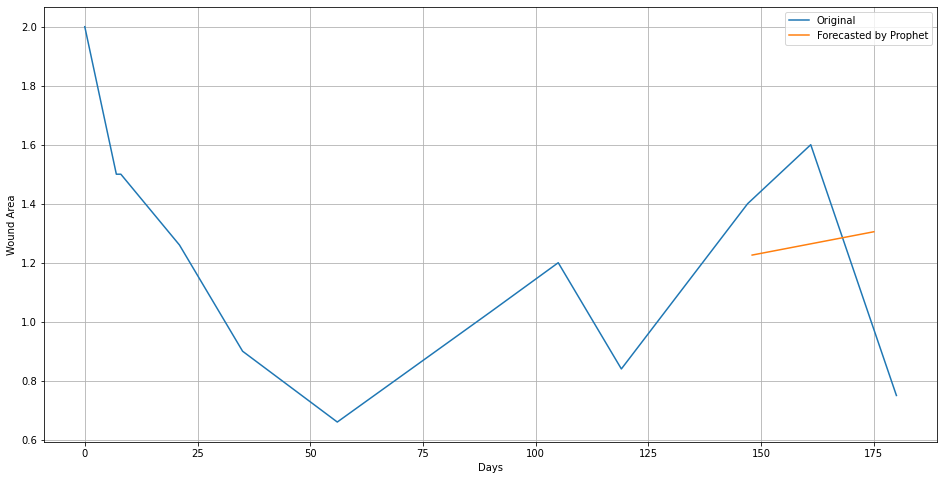

Total number of visit days after interpolation 181
5/5 [==============================] - 0s 764us/step


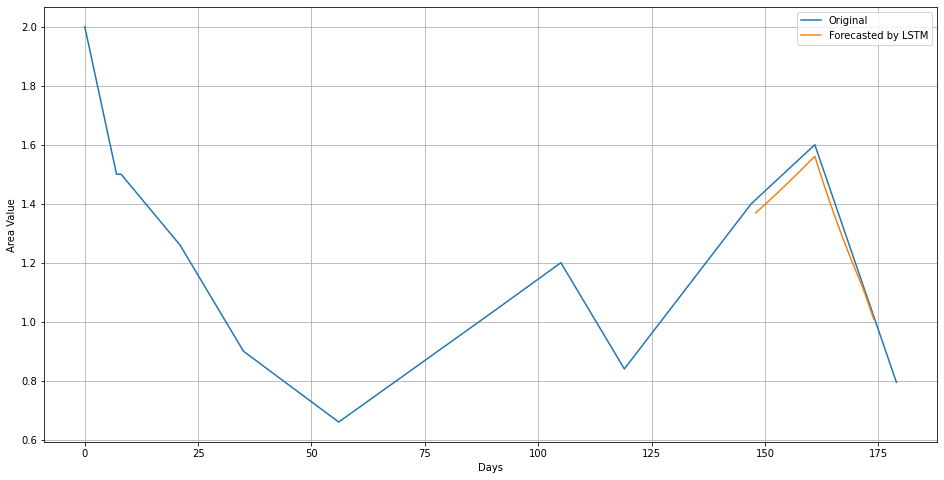

Total number of visit days after interpolation 181
1/1 [==============================] - 0s 218ms/step
test_dates shape: (27,)
predicted_values_test_inverse shape: (27, 1)


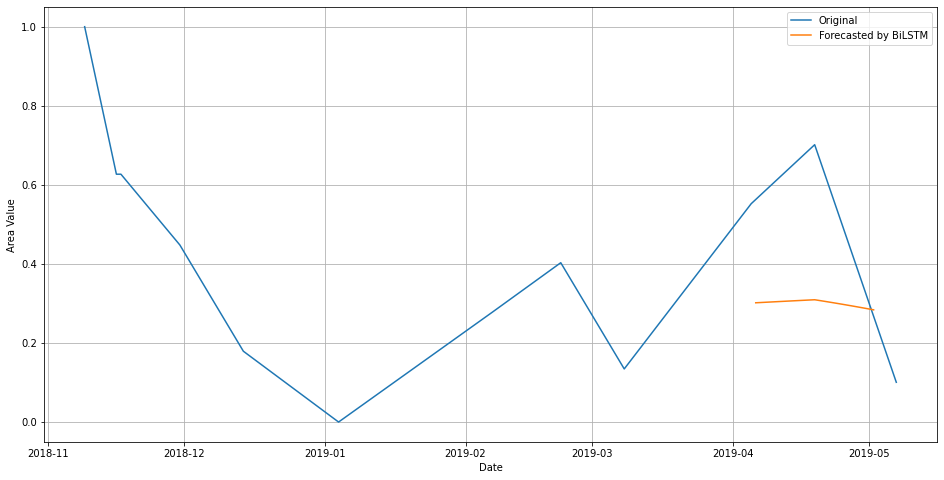

Done 0.16758278589623274 %
Wound: 26
17
89


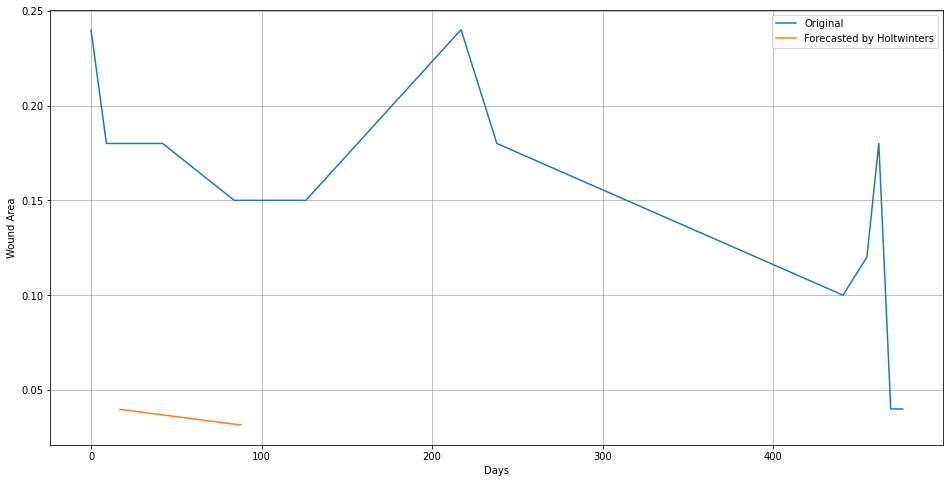

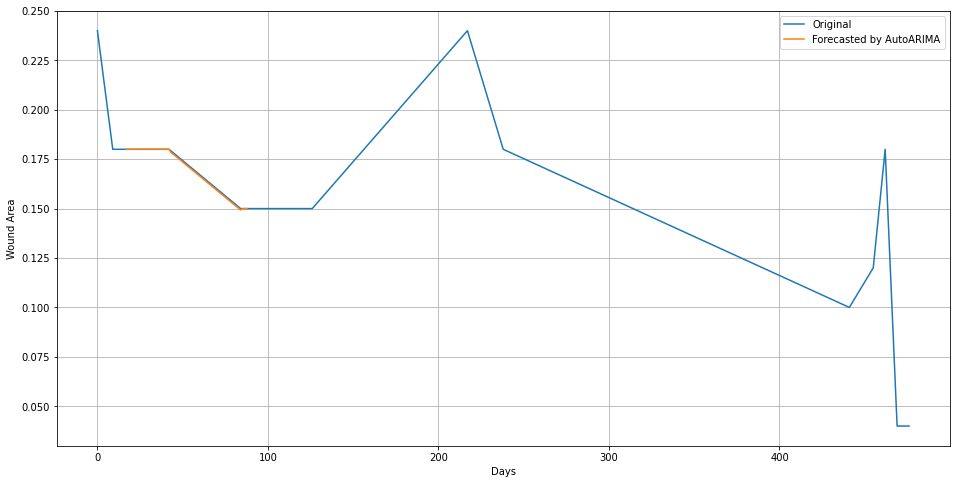

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -11.5924
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1010.45     0.0137684        190.54           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       1013.15   0.000366158       92.5404   4.825e-06       0.001      214  LS failed, Hessian reset 
     199       1019.92     0.0188711        95.666           1           1      297   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     230       1022.63   0.000391949        97.192   2.806e-06       0.001      369  LS failed, Hessian reset 
     299       1024.75   0.000380007       83.4642      0.2965      0.2965      455   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     345       1025.51   0.000605045       143.784   6.217e-06       0.001      551  LS failed, Hessian rese

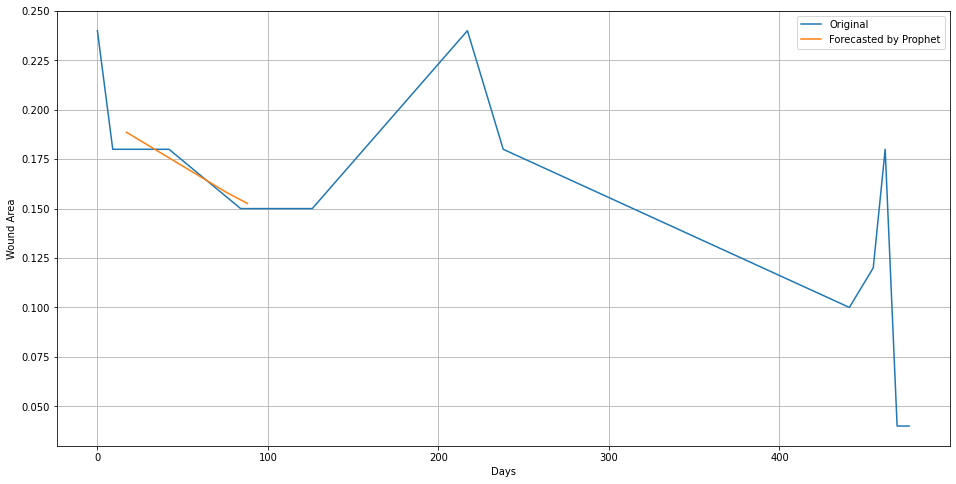

Total number of visit days after interpolation 477
13/13 [==============================] - 0s 959us/step


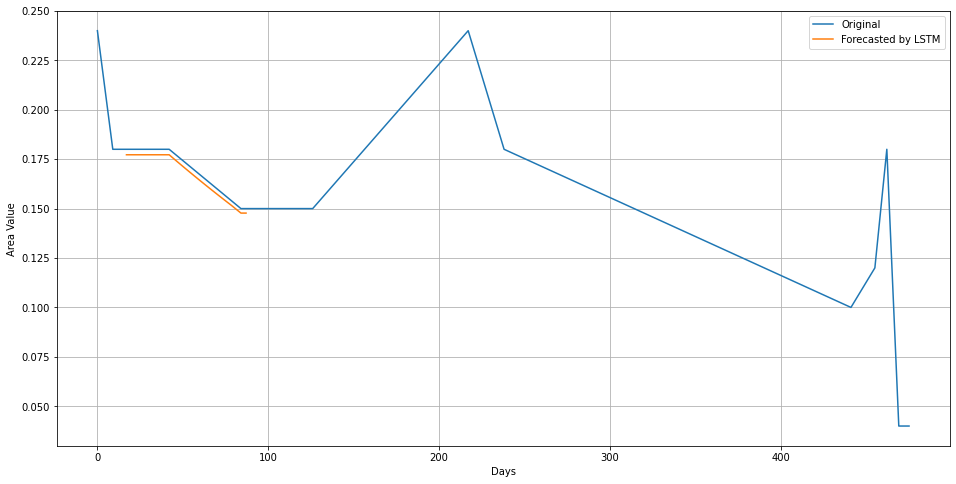

Total number of visit days after interpolation 477
3/3 [==============================] - 0s 1ms/step
test_dates shape: (71,)
predicted_values_test_inverse shape: (71, 1)


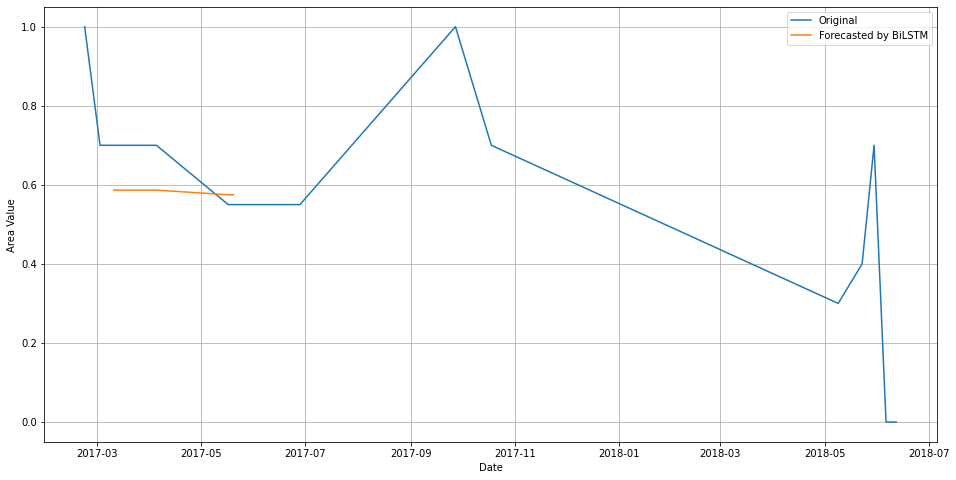

Done 0.17428609733208206 %
Wound: 27
5
33


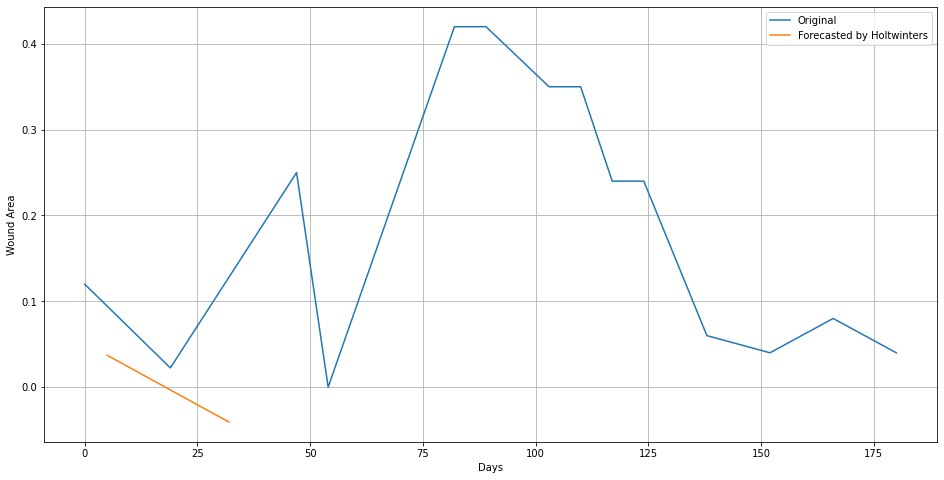

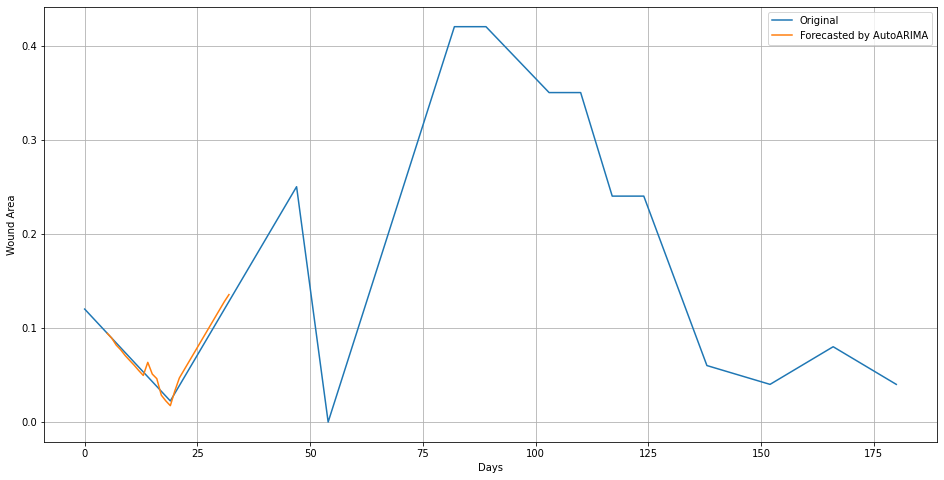

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -14.7367
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      89       171.015   0.000406579       81.6836   4.803e-06       0.001      160  LS failed, Hessian reset 
      99       171.045   5.20624e-05       73.6694           1           1      172   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147       171.051   4.96667e-06        87.945   6.103e-08       0.001      271  LS failed, Hessian reset 
     177       171.051   4.98585e-09       77.6059      0.6123      0.6123      307   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


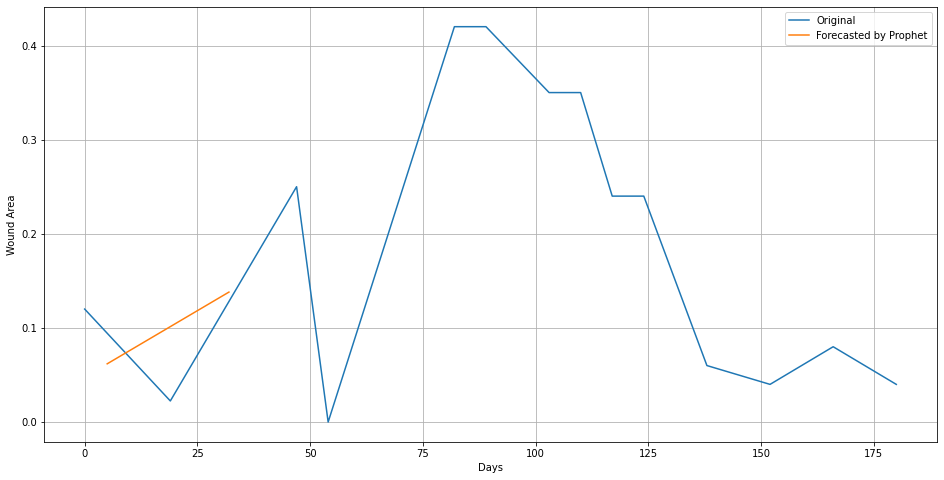

Total number of visit days after interpolation 181
5/5 [==============================] - 0s 1ms/step


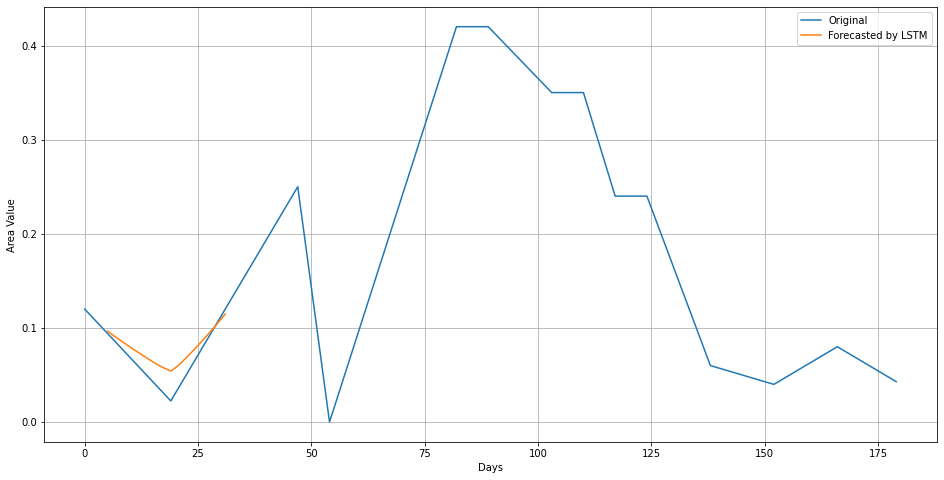

Total number of visit days after interpolation 181
1/1 [==============================] - 0s 215ms/step
test_dates shape: (27,)
predicted_values_test_inverse shape: (27, 1)


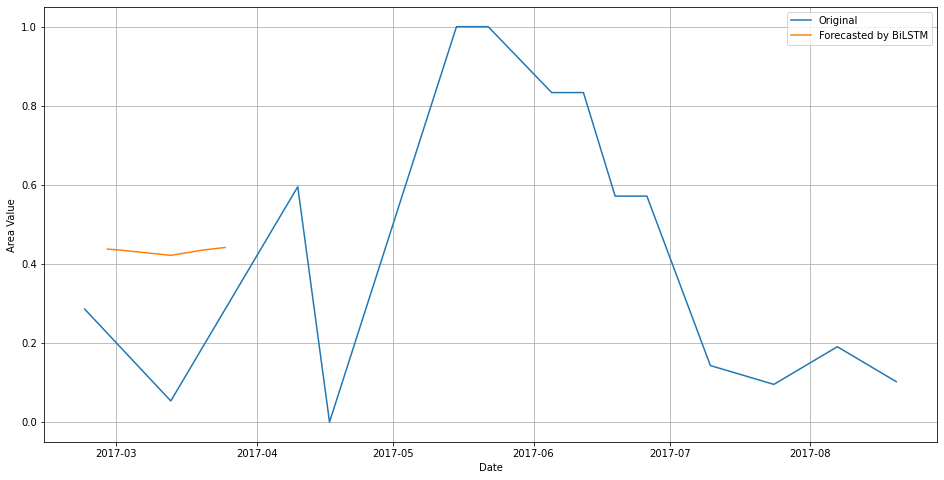

Done 0.18098940876793135 %
Wound: 28
21
34


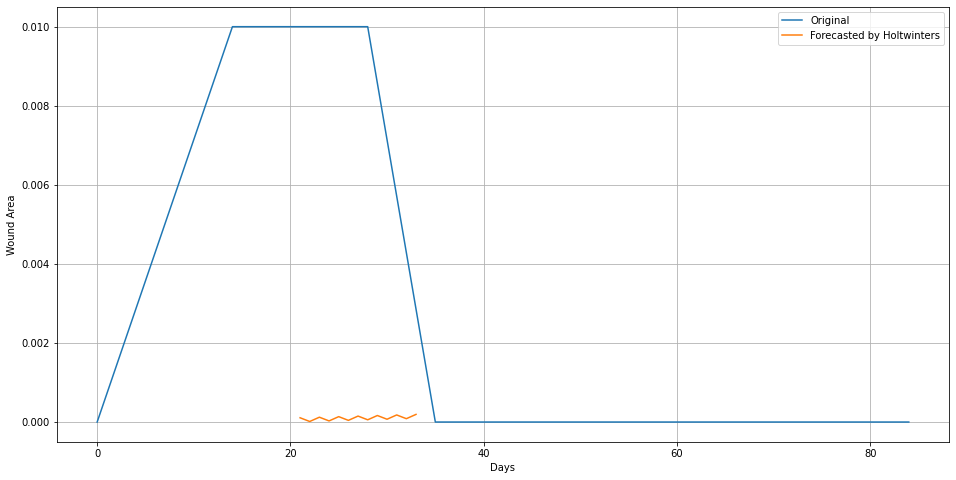

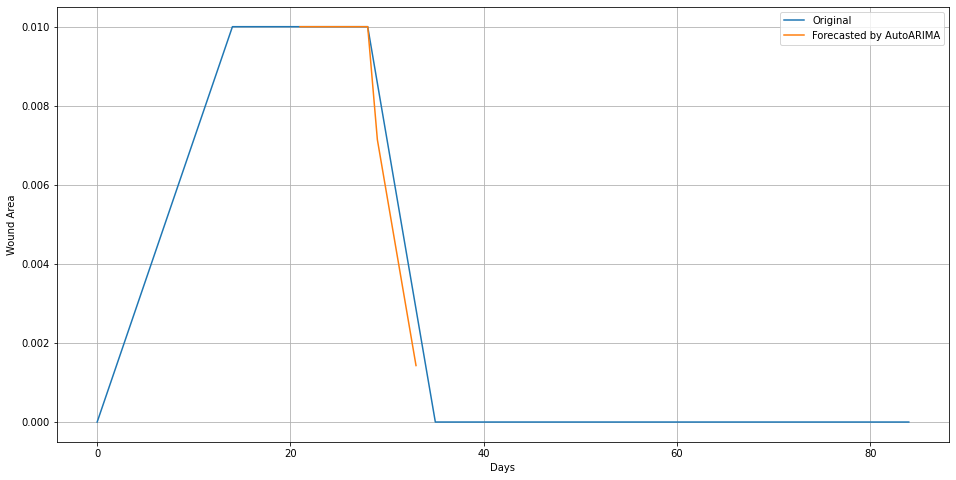

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Initial log joint probability = -83.4469
Iteration  1. Log joint probability =   -12.3071. Improved by 71.1398.
Iteration  2. Log joint probability =    26.8518. Improved by 39.1588.
Iteration  3. Log joint probability =    43.5846. Improved by 16.7328.
Iteration  4. Log joint probability =    44.0415. Improved by 0.456889.
Iteration  5. Log joint probability =    44.6023. Improved by 0.560862.
Iteration  6. Log joint probability =    44.6724. Improved by 0.0701079.
Iteration  7. Log joint probability =    45.1807. Improved by 0.508289.
Iteration  8. Log joint probability =    45.2443. Improved by 0.0635534.
Iteration  9. Log joint probability =    45.5142. Improved by 0.269939.
Iteration 10. Log joint probability =    45.6492. Improved by 0.134996.
Iteration 11. Log joint probability =     45.683. Improved by 0.0337526.
Iteration 12. Log joint probability =    45.6914. Improved by 0.00843837.
Iteration 13. Log joint probability =    45.6926. Improved by 0.00118433.
Iteration 14. Log 

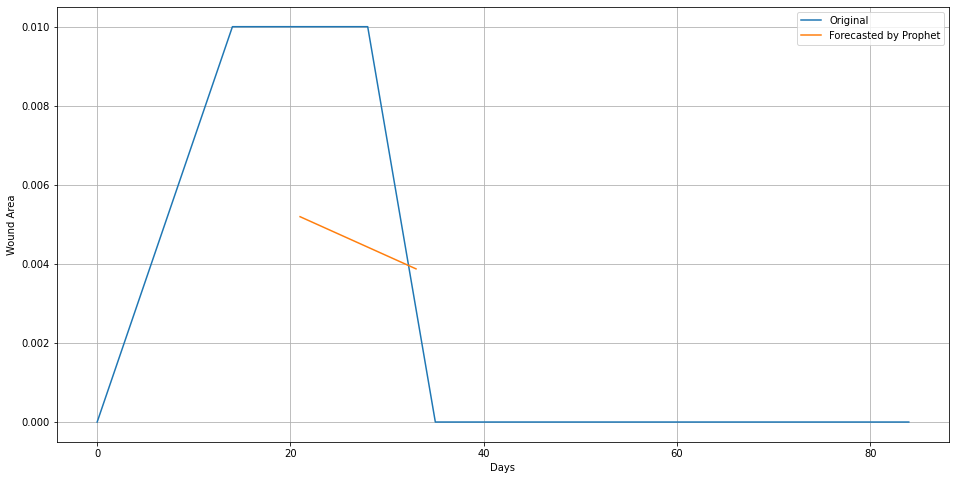

Total number of visit days after interpolation 85
3/3 [==============================] - 0s 947us/step


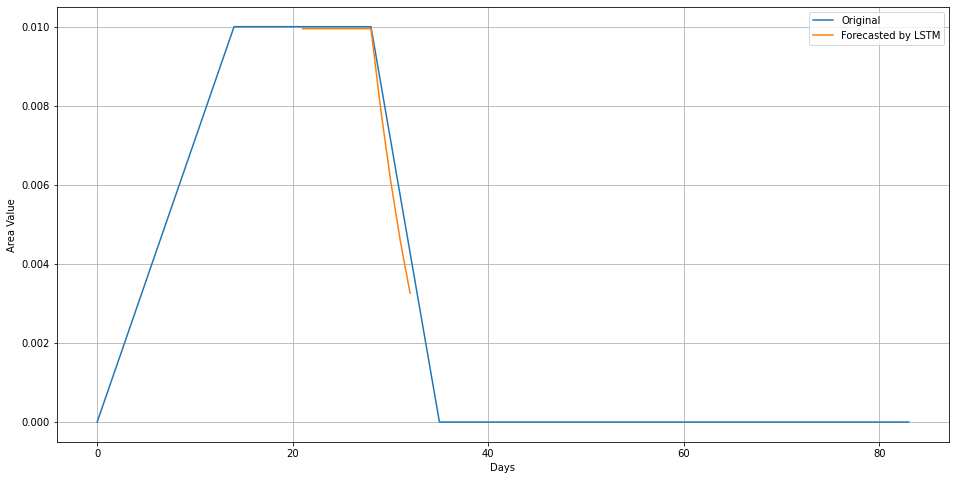

Total number of visit days after interpolation 85
1/1 [==============================] - 0s 226ms/step
test_dates shape: (12,)
predicted_values_test_inverse shape: (12, 1)


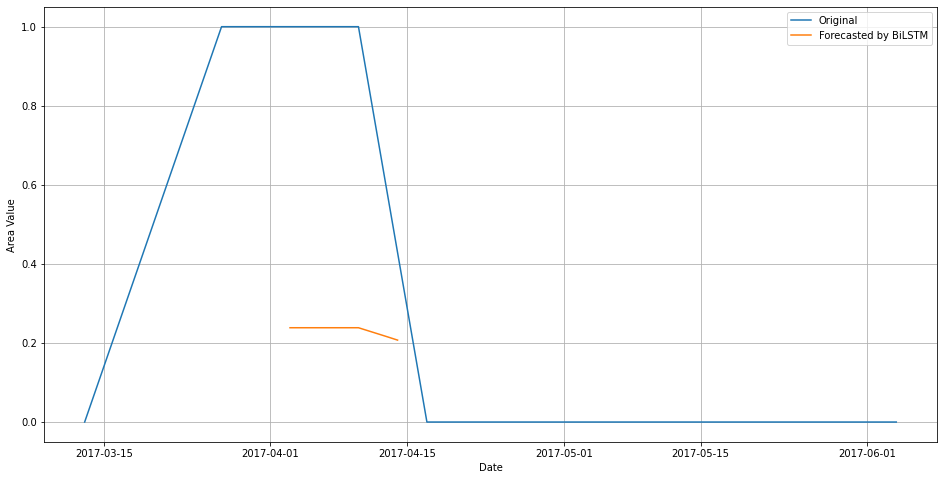

Done 0.18769272020378067 %
Wound: 29
8
15


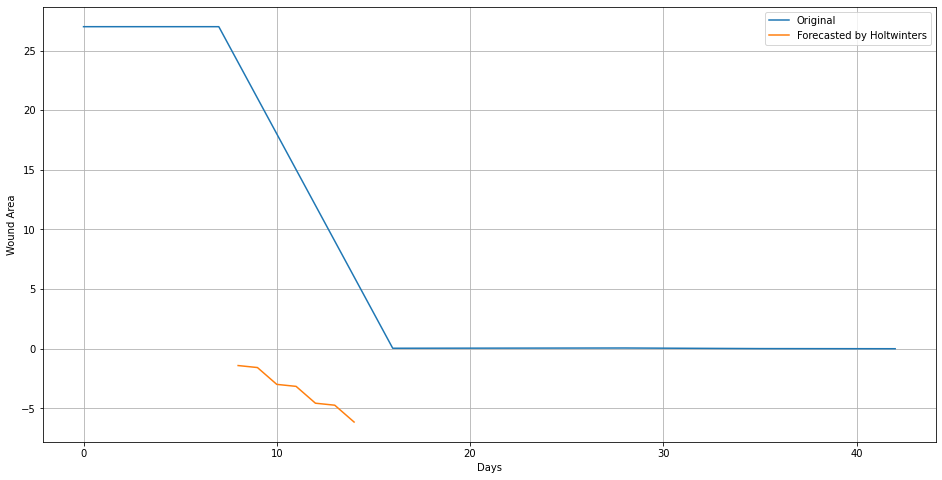

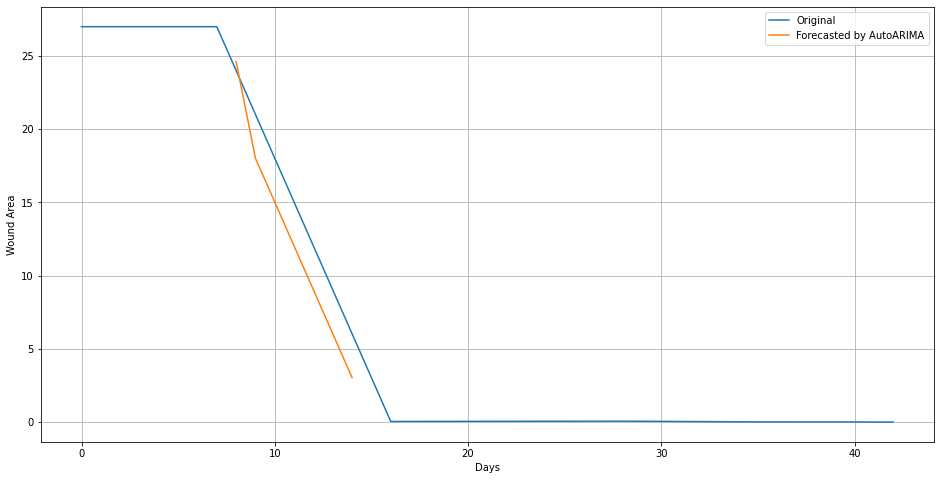

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Initial log joint probability = -36.5203
Iteration  1. Log joint probability =    24.3255. Improved by 60.8458.
Iteration  2. Log joint probability =    40.8134. Improved by 16.4879.
Iteration  3. Log joint probability =    42.1728. Improved by 1.35939.
Iteration  4. Log joint probability =     42.409. Improved by 0.236154.
Iteration  5. Log joint probability =    42.4287. Improved by 0.0197454.
Iteration  6. Log joint probability =    42.4513. Improved by 0.0225798.
Iteration  7. Log joint probability =    42.5198. Improved by 0.0685451.
Iteration  8. Log joint probability =    42.5776. Improved by 0.0577958.
Iteration  9. Log joint probability =    42.6595. Improved by 0.0818264.
Iteration 10. Log joint probability =    42.6801. Improved by 0.0206261.
Iteration 11. Log joint probability =    42.8424. Improved by 0.162303.
Iteration 12. Log joint probability =    42.8937. Improved by 0.0513087.
Iteration 13. Log joint probability =    42.9157. Improved by 0.0219764.
Iteration 14. Log

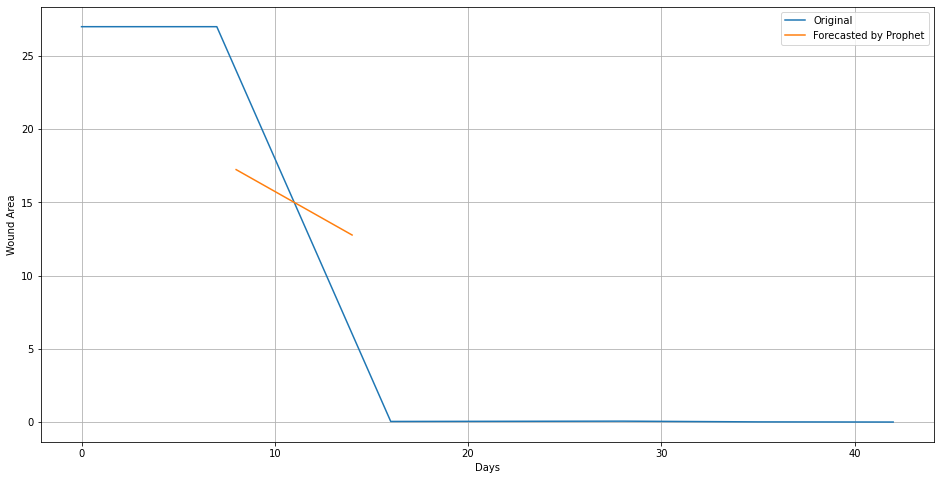

Total number of visit days after interpolation 43
2/2 [==============================] - 0s 1ms/step


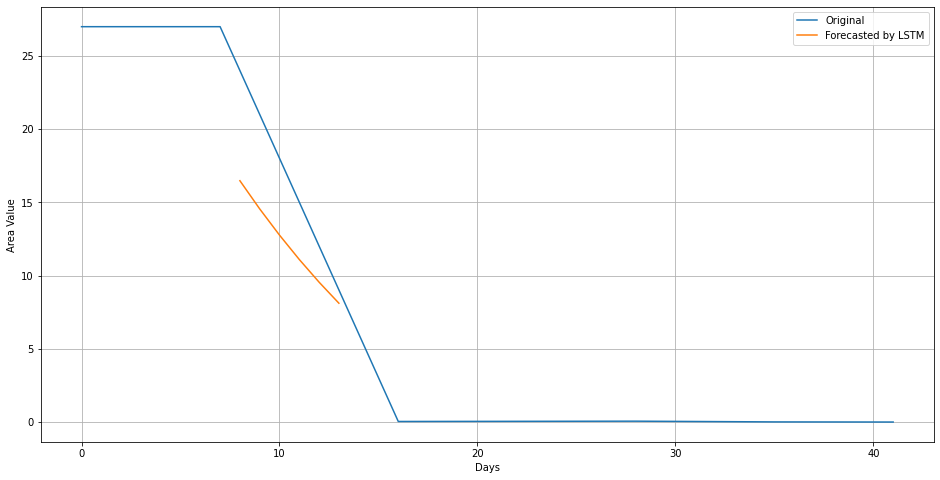

Total number of visit days after interpolation 43
1/1 [==============================] - 0s 215ms/step
test_dates shape: (6,)
predicted_values_test_inverse shape: (6, 1)


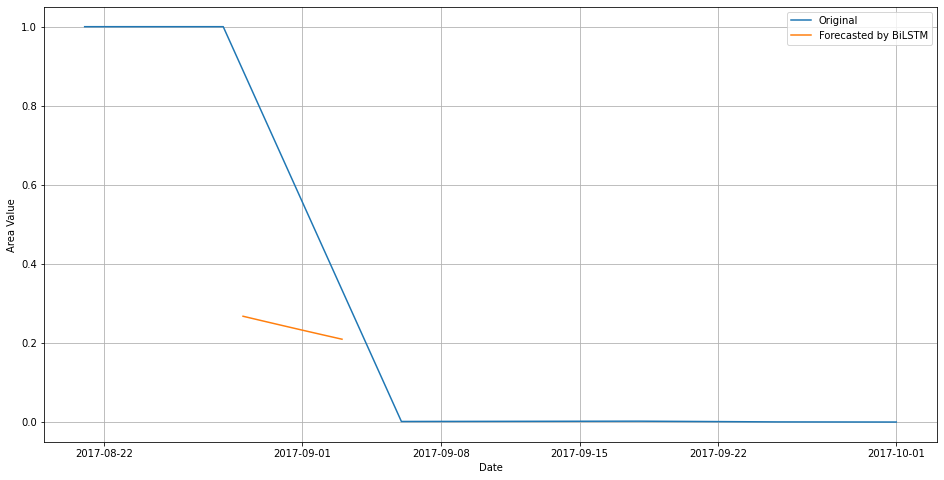

Done 0.19439603163962998 %
Wound: 30
38
49


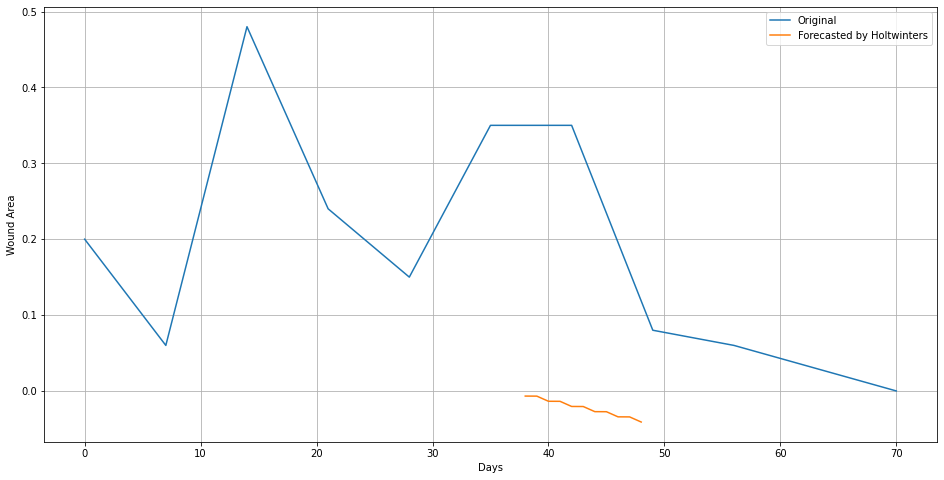

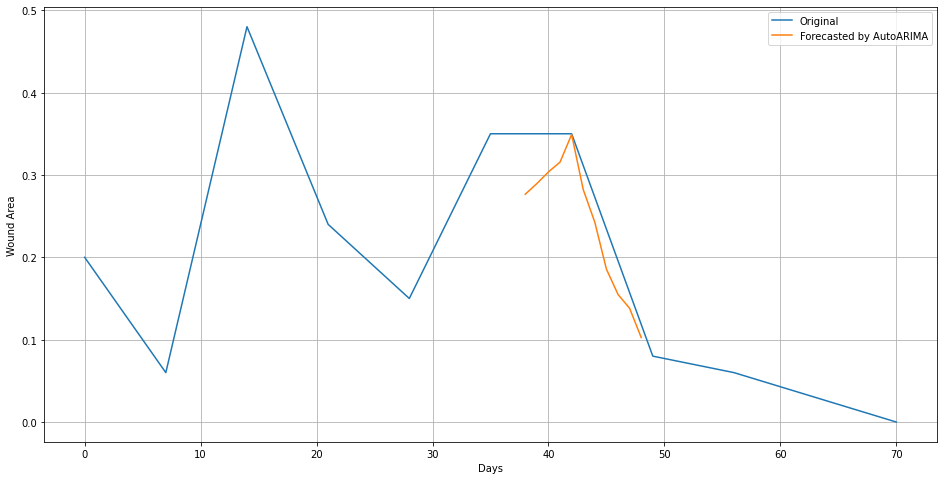

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Initial log joint probability = -63.1566
Iteration  1. Log joint probability =    44.9737. Improved by 108.13.
Iteration  2. Log joint probability =    66.7951. Improved by 21.8213.
Iteration  3. Log joint probability =    68.7267. Improved by 1.93164.
Iteration  4. Log joint probability =    68.7411. Improved by 0.0143978.
Iteration  5. Log joint probability =    68.7519. Improved by 0.0108442.
Iteration  6. Log joint probability =    68.7722. Improved by 0.0202426.
Iteration  7. Log joint probability =    68.8227. Improved by 0.050533.
Iteration  8. Log joint probability =     68.863. Improved by 0.0402439.
Iteration  9. Log joint probability =    68.9598. Improved by 0.0968768.
Iteration 10. Log joint probability =    69.0002. Improved by 0.0403811.
Iteration 11. Log joint probability =    69.0178. Improved by 0.0175601.
Iteration 12. Log joint probability =    69.0351. Improved by 0.0173143.
Iteration 13. Log joint probability =    69.0438. Improved by 0.0087537.
Iteration 14. Log

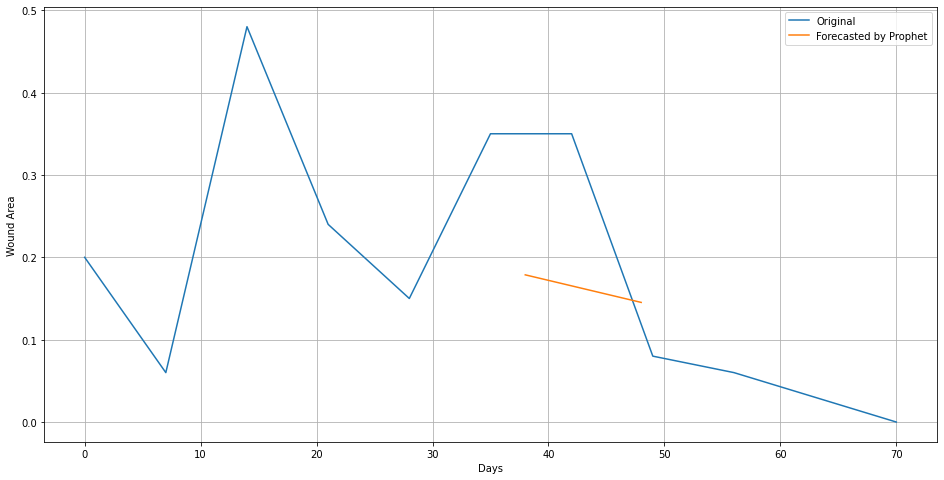

Total number of visit days after interpolation 71
2/2 [==============================] - 0s 2ms/step


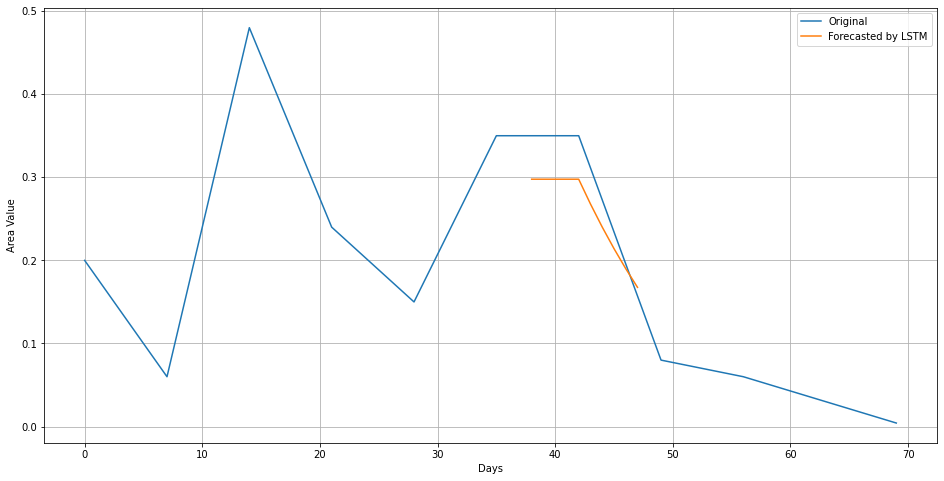

Total number of visit days after interpolation 71
1/1 [==============================] - 0s 211ms/step
test_dates shape: (10,)
predicted_values_test_inverse shape: (10, 1)


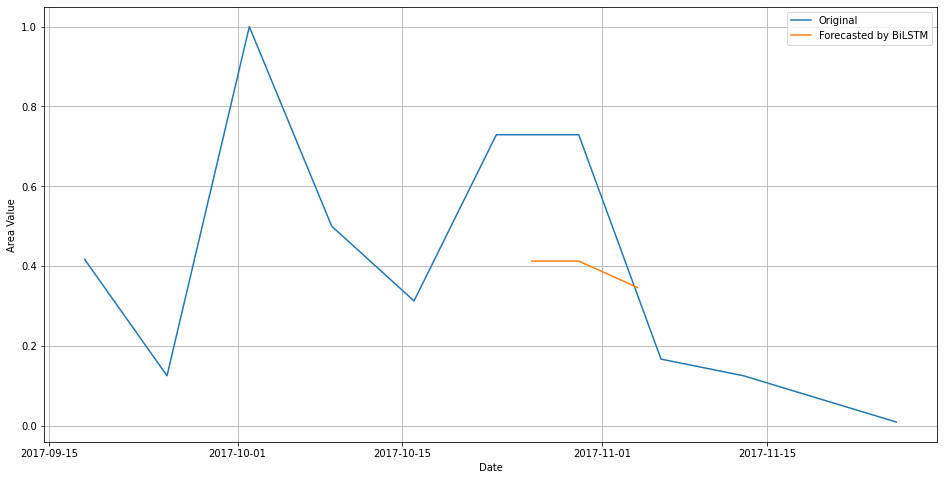

Done 0.2010993430754793 %
Wound: 31
14
18


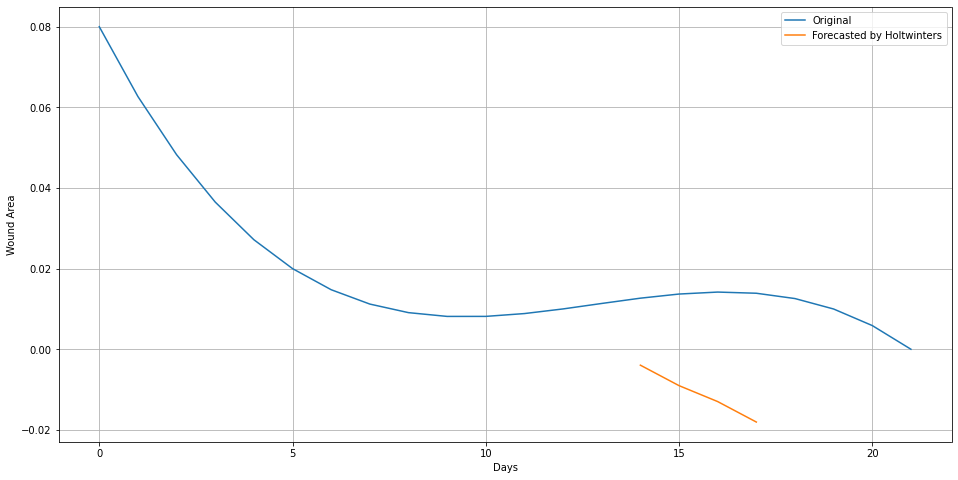

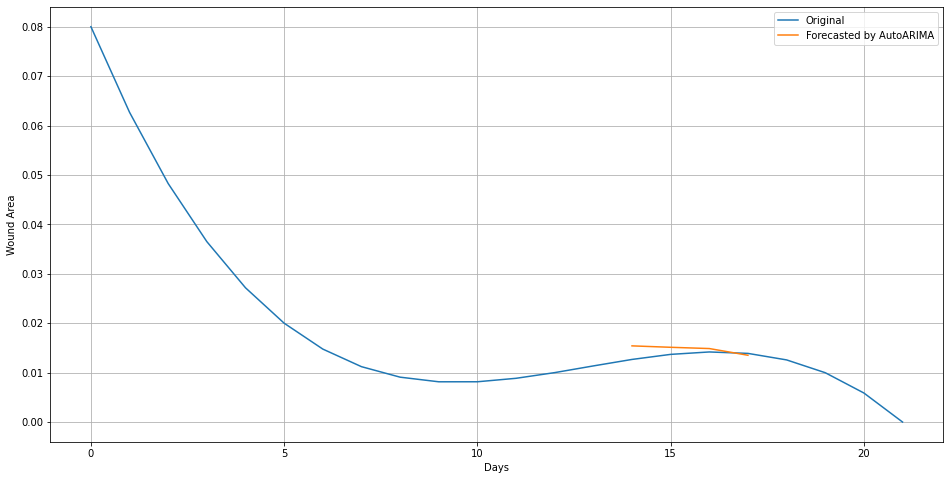

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 16.



Initial log joint probability = -36.953
Iteration  1. Log joint probability =    4.67656. Improved by 41.6296.
Iteration  2. Log joint probability =    20.3142. Improved by 15.6377.
Iteration  3. Log joint probability =    27.8805. Improved by 7.56624.
Iteration  4. Log joint probability =    28.1832. Improved by 0.302786.
Iteration  5. Log joint probability =    28.1933. Improved by 0.0101038.
Iteration  6. Log joint probability =     28.224. Improved by 0.0306686.
Iteration  7. Log joint probability =    28.4894. Improved by 0.26534.
Iteration  8. Log joint probability =      28.63. Improved by 0.140594.
Iteration  9. Log joint probability =    28.6785. Improved by 0.0485001.
Iteration 10. Log joint probability =     28.692. Improved by 0.0135781.
Iteration 11. Log joint probability =    28.6992. Improved by 0.00712998.
Iteration 12. Log joint probability =    28.7042. Improved by 0.00504663.
Iteration 13. Log joint probability =    28.7121. Improved by 0.00794326.
Iteration 14. Log

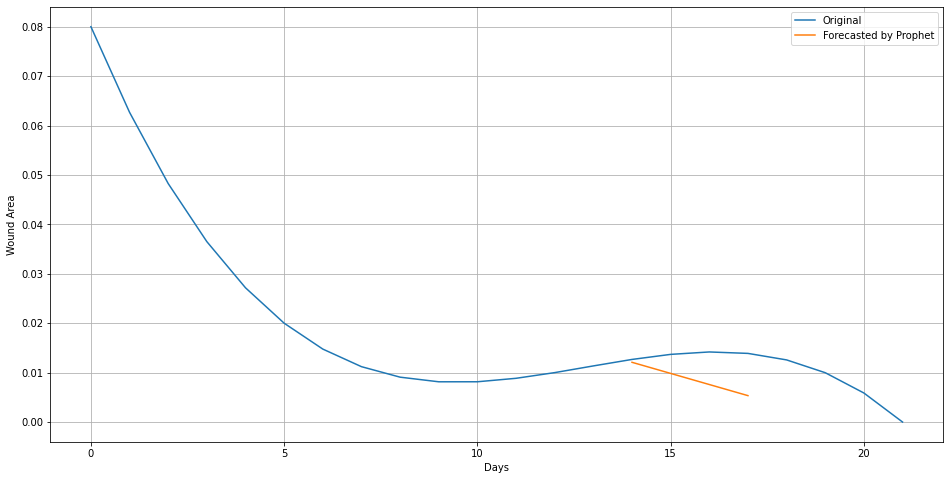

Total number of visit days after interpolation 22
1/1 [==============================] - 0s 9ms/step


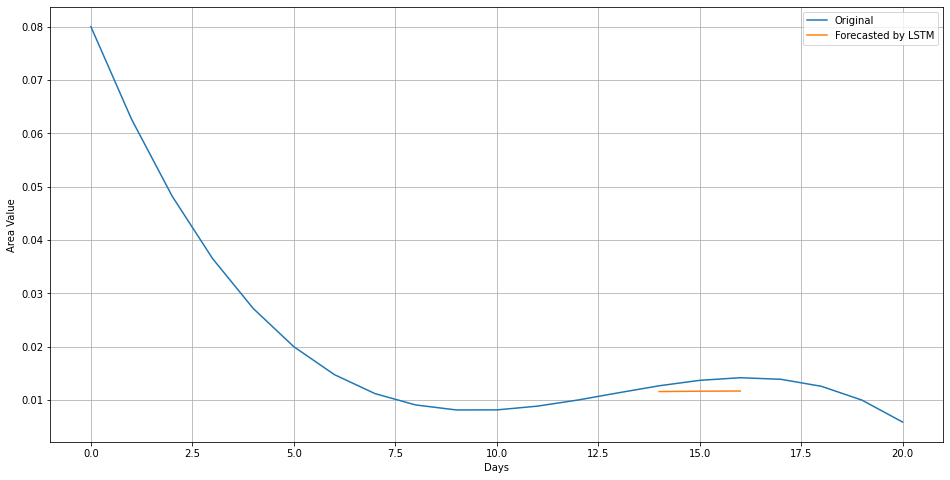

Total number of visit days after interpolation 22
1/1 [==============================] - 0s 209ms/step
test_dates shape: (3,)
predicted_values_test_inverse shape: (3, 1)


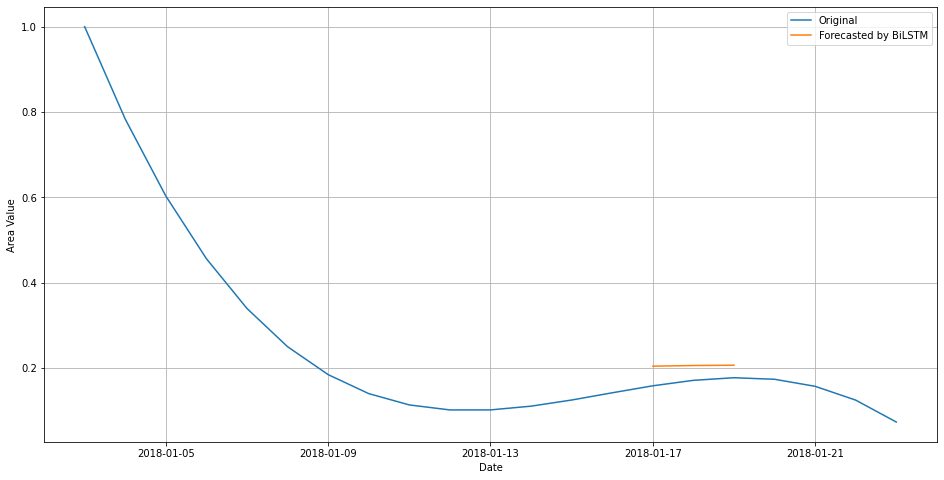

Done 0.2078026545113286 %
Wound: 32
103
127


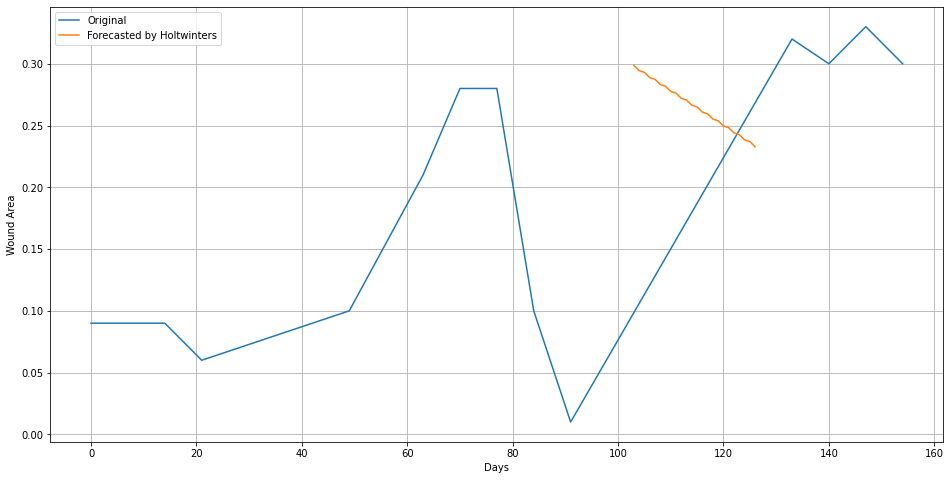

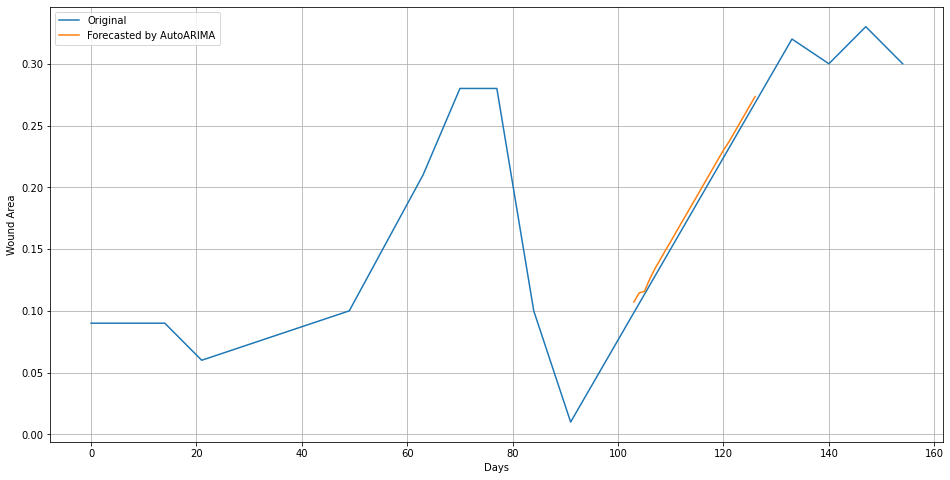

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -6.12802
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       165.343   4.46937e-06       59.4871           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     124       165.344   5.31072e-06       79.8079   1.018e-07       0.001      203  LS failed, Hessian reset 
     179       165.344   1.03054e-08       59.5108      0.7373      0.7373      280   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


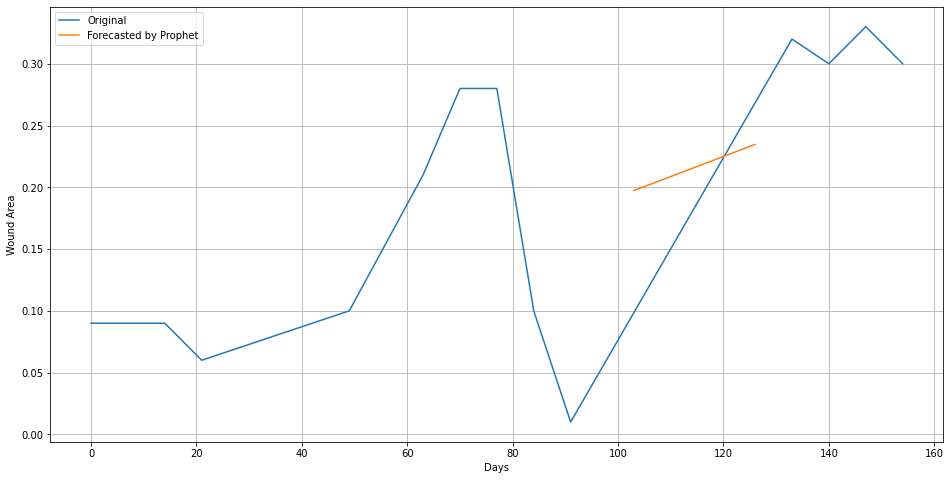

Total number of visit days after interpolation 155
5/5 [==============================] - 0s 900us/step


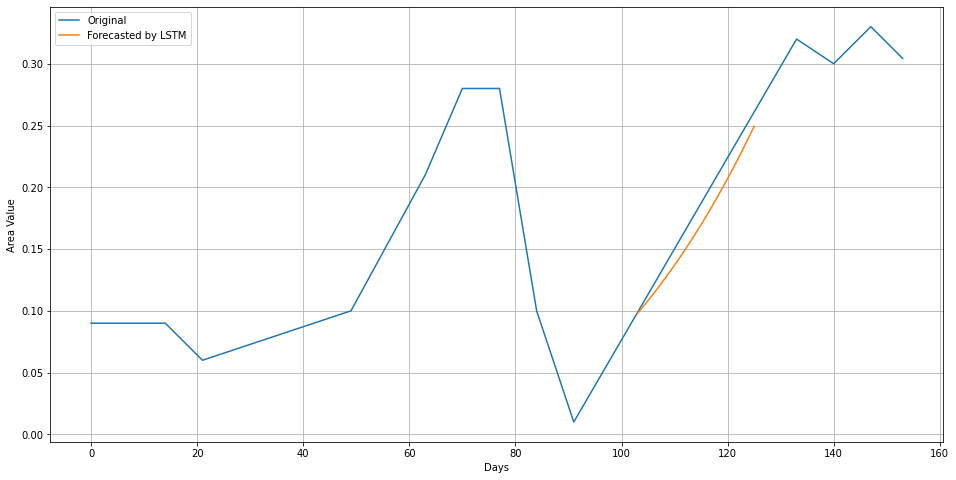

Total number of visit days after interpolation 155
1/1 [==============================] - 0s 213ms/step
test_dates shape: (23,)
predicted_values_test_inverse shape: (23, 1)


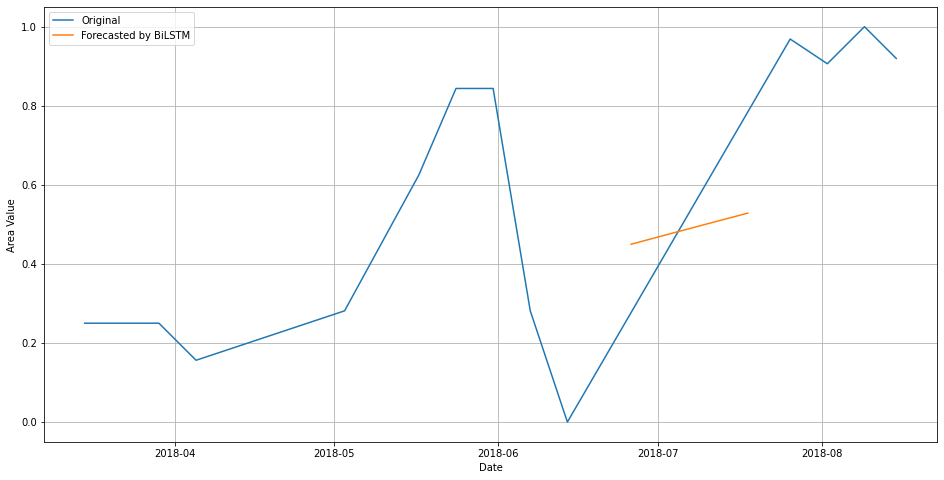

Done 0.2145059659471779 %
Wound: 33
14
18


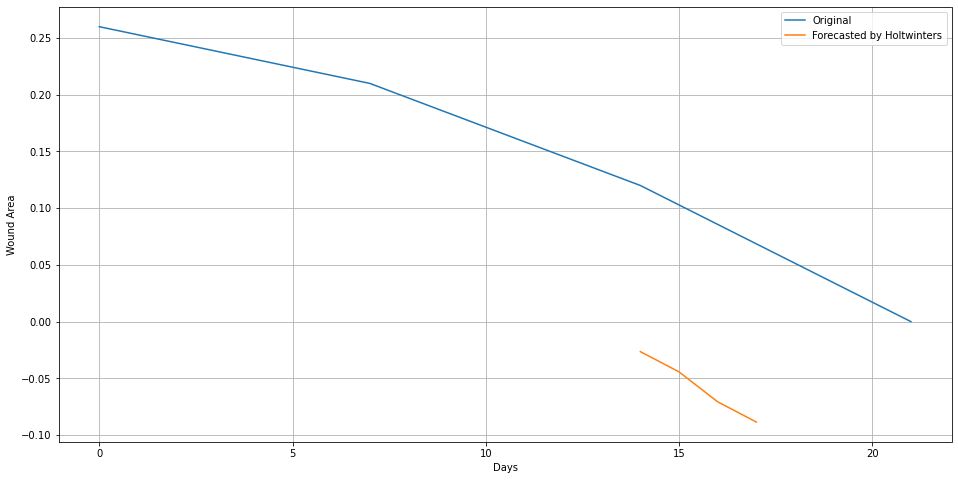

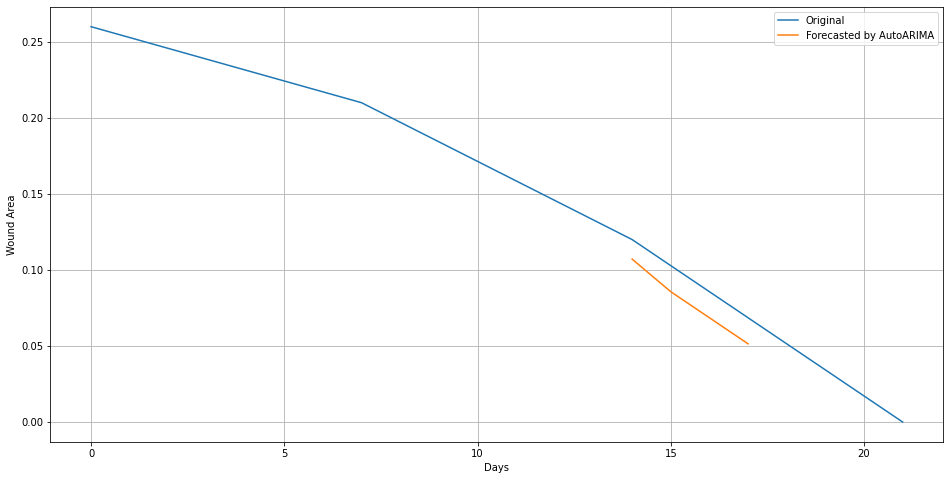

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 16.



Initial log joint probability = -35.9054
Iteration  1. Log joint probability =    20.4296. Improved by 56.3351.
Iteration  2. Log joint probability =    41.2798. Improved by 20.8501.
Iteration  3. Log joint probability =    45.5879. Improved by 4.3081.
Iteration  4. Log joint probability =    48.4792. Improved by 2.8913.
Iteration  5. Log joint probability =    56.9246. Improved by 8.4454.
Iteration  6. Log joint probability =    57.0509. Improved by 0.126367.
Iteration  7. Log joint probability =    57.0815. Improved by 0.0305923.
Iteration  8. Log joint probability =    57.1811. Improved by 0.099561.
Iteration  9. Log joint probability =    57.3761. Improved by 0.195034.
Iteration 10. Log joint probability =     57.396. Improved by 0.0198817.
Iteration 11. Log joint probability =    57.6084. Improved by 0.212386.
Iteration 12. Log joint probability =    57.7634. Improved by 0.155036.
Iteration 13. Log joint probability =    57.8127. Improved by 0.049288.
Iteration 14. Log joint prob

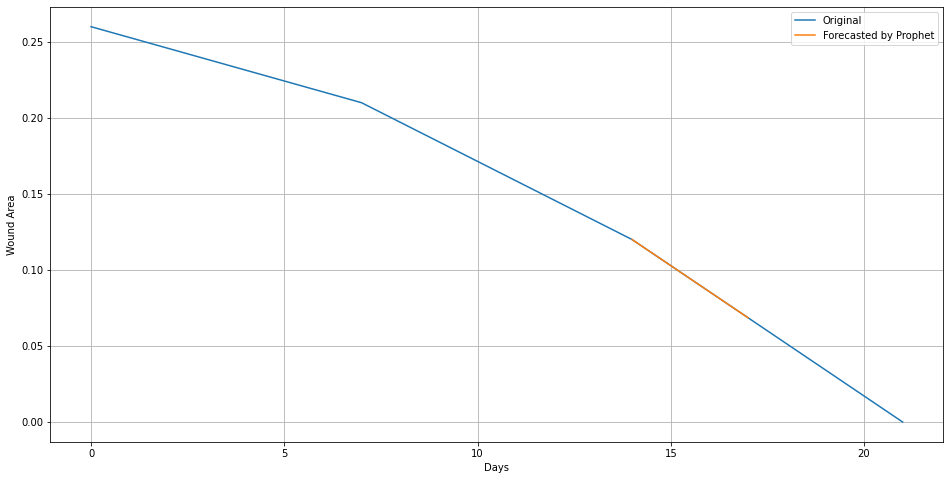

Total number of visit days after interpolation 22
1/1 [==============================] - 0s 9ms/step


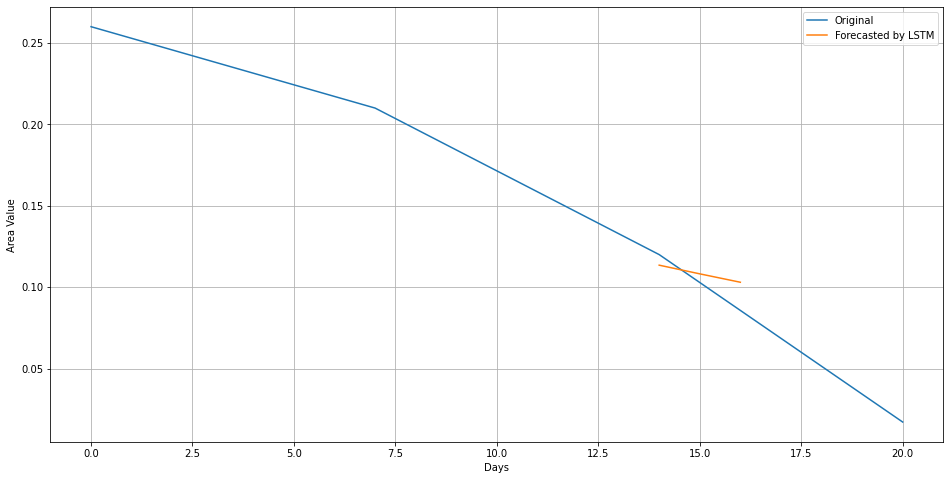

Total number of visit days after interpolation 22
1/1 [==============================] - 0s 232ms/step
test_dates shape: (3,)
predicted_values_test_inverse shape: (3, 1)


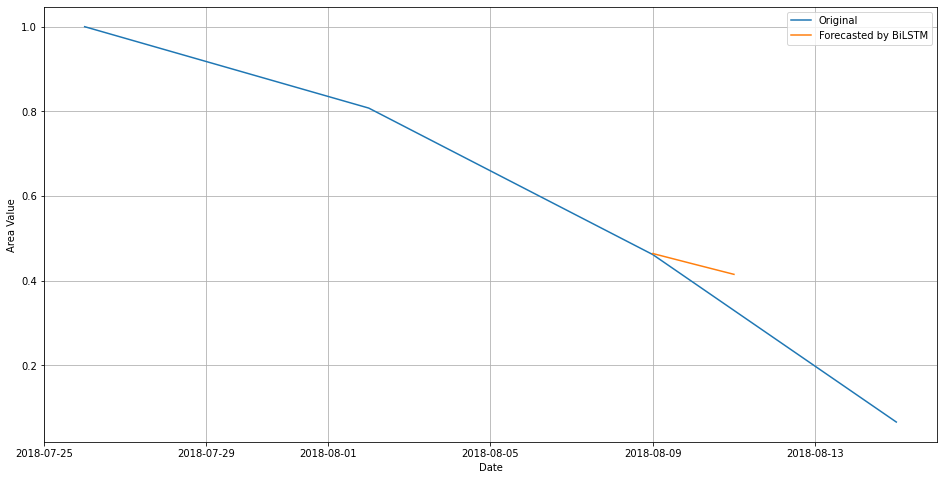

Done 0.2212092773830272 %
Wound: 34
356
430


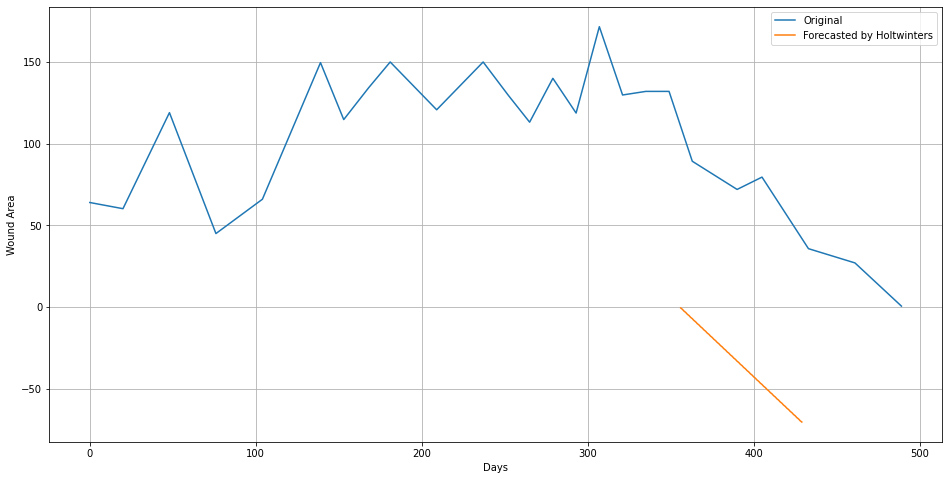

KeyboardInterrupt: 

In [12]:
list_wounds=df_for["Wound"].unique()

result_df=pd.DataFrame(index=np.arange(len(list_wounds)))

result_df["Wound"]=np.nan
result_df["Gender"]=np.nan
result_df["Race"]=np.nan
result_df["Ethinicity"]=np.nan

result_df["RMSE_Holtwinters"]=np.nan
result_df["R-squared_Holtwinters"]=np.nan

result_df["RMSE_AutoARIMA"]=np.nan
result_df["R-squared_AutoARIMA"]=np.nan

result_df["RMSE_Prophet"]=np.nan
result_df["R-squared_Prophet"]=np.nan

result_df["RMSE_LSTM"]=np.nan
result_df["R-squared_LSTM"]=np.nan

result_df["RMSE_BiLSTM"]=np.nan
result_df["R-squared_BiLSTM"]=np.nan
    

for i in range(0, len(list_wounds)):
    print("Done", i/len(list_wounds)*100,"%")
#     if i>4:
#         break
    print("Wound:",i+1)
    wound=list_wounds[i]
    df_1=df_for.query("Wound==@wound")
    #display(df_1)
    df=df_1[["Date","Area"]]
    test,train,random_number_start, random_number_end=make_input_for_arima(df)


    result_df["Wound"][i]=int(df_1["Wound"].unique()[0])
    result_df["Gender"][i]=str(df_1["Gender"].unique()[0])
    result_df["Race"][i]=str(df_1["Race"].unique()[0])
    result_df["Ethinicity"][i]=str(df_1["Ethinicity"].unique()[0])

    df=df.reset_index()
    df=df.drop(["index"],axis=1)


    if df.shape[0]>9 and df.shape[0]<1200:

                #Holt winters
                rmse_h, r_square_h=model_holtwinters(df, test, train)
                result_df["RMSE_Holtwinters"][i]=rmse_h
                result_df["R-squared_Holtwinters"][i]=r_square_h
            
                #Auto ARIMA
                df = df.rename(columns={'Date': 'ds', 'Area': 'y'})
                test = test.rename(columns={'Date': 'ds', 'Area': 'y'})
                train = train.rename(columns={'Date': 'ds', 'Area': 'y'})
                test=test.drop(['index'],axis=1)
                train=train.drop(['index'],axis=1)
                df['unique_id']='unique_wound'
                test['unique_id']='unique_wound'
                train['unique_id']='unique_wound'
                df=df.reset_index()
                df=df.drop(['index'],axis=1)
                rmse_a, r_square_a=model_arima(df, test, train)
                result_df["RMSE_AutoARIMA"][i]=rmse_a
                result_df["R-squared_AutoARIMA"][i]=r_square_a
                
                #Prophet
                df=df.drop(["unique_id"],axis=1)
                test=test.drop(["unique_id"],axis=1)
                train=train.drop(["unique_id"],axis=1)
                rmse_p, r_square_p=model_prophet(df, test, train)
                result_df["RMSE_Prophet"][i]=rmse_p
                result_df["R-squared_Prophet"][i]=r_square_p
                
                #LSTM
                df=df_1[["Date","Area"]]
                df=df.reset_index()
                df=df.drop(["index"],axis=1)
                rmse_l, r_square_l=model_LSTM(df, random_number_start,random_number_end)
                result_df["RMSE_LSTM"][i]=rmse_l
                result_df["R-squared_LSTM"][i]=r_square_l
                
                #BiLSTM
                rmse_b, r_square_b=model_BiLSTM(df, random_number_start,random_number_end)
                result_df["RMSE_BiLSTM"][i]=rmse_b
                result_df["R-squared_BiLSTM"][i]=r_square_b


result_df["Wound"]=result_df["Wound"].astype(int)

In [ ]:
i

In [153]:
#result_df

In [154]:
result_df=result_df.dropna(how='all')
#result_df

In [145]:
#result_df.drop(result_df.tail(1).index,inplace=True)
#result_df

In [ ]:
result_df_prev=pd.read_csv("final_updated_result.csv")
result_df_prev=result_df_prev.drop(["Unnamed: 0"],axis=1)
result_df_prev=result_df_prev.dropna(how='all')
result_df_prev

In [157]:
new_df=pd.concat([result_df_prev,result_df],axis=0)
#new_df

In [159]:
#new_df.to_csv("final_updated_result.csv")
new_df.to_csv("accuracy_metrics_forecasting_models.csv")

In [14]:
metrics=pd.read_csv("accuracy_metrics_forecasting_models.csv")
metrics=metrics.drop(["Unnamed: 0"],axis=1)
metrics=metrics.dropna()
metrics.describe()

Wound  RMSE_Holtwinters  R-squared_Holtwinters  RMSE_AutoARIMA  \
count  11928.000000      11928.000000           1.192800e+04    1.192800e+04   
mean    8923.322099         18.595235           7.608725e-01    1.464268e+00   
std     5174.296652        128.267536           2.990340e-01    1.214114e+01   
min        1.000000          0.000153           7.420216e-33    4.600754e-11   
25%     4415.500000          0.363147           6.242125e-01    1.785714e-02   
50%     8973.500000          1.565317           9.062963e-01    8.713428e-02   
75%    13395.250000          7.326375           9.892312e-01    4.136344e-01   
max    17880.000000       5938.736740           1.000000e+00    7.779987e+02   

       R-squared_AutoARIMA  RMSE_Prophet  R-squared_Prophet     RMSE_LSTM  \
count         1.192800e+04  11928.000000       1.192800e+04  1.192800e+04   
mean          8.735035e-01      3.104033       8.270907e-01  4.654391e+00   
std           2.312073e-01     17.062500       2.695193e-01  2.203384e+01   
min           1.470793e-07      0.000000       1.308232e-24  1.502252e-07   
25%           8.801339e-01      0.032074       7.690706e-01  1.218388e-01   
50%           9.797260e-01      0.214720       9.733363e-01  5.027760e-01   
75%           9.986473e-01      1.092368       1.000000e+00  2.189479e+00   
max           1.000000e+00    632.409377       1.000000e+00  7.821413e+02   

       R-squared_LSTM   RMSE_BiLSTM  R-squared_BiLSTM  
count    1.192800e+04  11928.000000      11928.000000  
mean     9.224357e-01      0.221529          0.922400  
std      1.762537e-01      0.135867          0.175968  
min      3.263213e-30      0.000582          0.000000  
25%      9.389575e-01      0.120238          0.938439  
50%      9.960561e-01      0.196160          0.995887  
75%      9.999160e-01      0.291620          0.999998  
max      1.000000e+00      0.839070          1.000000